### Goal
- 1.) LIST with all unique measurements
- 2.) For each measurement we need the UNIT + MEANING (Description) -> See CONFING
- 3.) For each measurement we define a RANGE (Min, Max) and combine this with OUTLIER DETECTION
- 4.) We VALIDATE that all measurement are within acceptable range

- 5.) We test electrotechnical formulars

In [10]:
# 1.) LIST with all unique measurements
from pathlib import Path

def unique_measurements_from_validation_results(base_dir: Path) -> list[str]:
    """validation_results/<MACHINE>/<MEASUREMENT>/<YEAR>_<MEASUREMENT>_stats.csv"""
    base_dir = Path(base_dir)
    measurements = set()
    for fp in base_dir.rglob("*_stats.csv"):
        try:
            rel = fp.relative_to(base_dir)
        except Exception:
            continue
        parts = rel.parts
        if len(parts) < 3:
            continue
        measurement = parts[1]  # <MEASUREMENT>
        measurements.add(measurement)
    return sorted(measurements)

def unique_measurements_from_dataset_clean(base_dir: Path) -> list[str]:
    """
    dataset_clean/<MACHINE>/<MEASUREMENT or MEASUREMENT_EMPTY>/<YEAR>_<MEASUREMENT or MEASUREMENT_EMPTY>.csv.xz
    - Exclude measurements whose folder ends with '_EMPTY'
    - Exclude years whose file stem contains '_EMPTY'
    - Include a measurement if there exists at least one non-EMPTY file
    """
    base_dir = Path(base_dir)
    measurements = set()
    for machine_dir in base_dir.iterdir():
        if not machine_dir.is_dir():
            continue
        for meas_dir in machine_dir.iterdir():
            if not meas_dir.is_dir():
                continue
            meas_name_folder = meas_dir.name
            # Skip if whole folder is marked empty
            if meas_name_folder.endswith("_EMPTY"):
                continue
            # Accept if any non-empty file exists
            has_non_empty = False
            for fp in meas_dir.glob("*.csv.xz"):
                if "_EMPTY" not in fp.stem:
                    has_non_empty = True
                    break
            if has_non_empty:
                measurements.add(meas_name_folder)
    return sorted(measurements)

if __name__ == "__main__":
    vr_base = Path("../validation_results")
    dc_base = Path("../dataset_clean")

    measurements_validation_results = unique_measurements_from_validation_results(vr_base)
    measurements_dataset_clean = unique_measurements_from_dataset_clean(dc_base)

    print("Validation Results: ", len(measurements_validation_results))
    print("Dataset Clean: ", len(measurements_dataset_clean))
    print("Dataset Clean: ", measurements_dataset_clean)


Validation Results:  0
Dataset Clean:  256
Dataset Clean:  ['AC_ActivePower', 'Angle_U1', 'Angle_U2', 'Angle_U2_f', 'Angle_U3', 'Angle_U3_f', 'DailyYield', 'Freq', 'Freq_f', 'I1', 'I1_f', 'I1_h11', 'I1_h13', 'I1_h15', 'I1_h17', 'I1_h19', 'I1_h2', 'I1_h21', 'I1_h23', 'I1_h25', 'I1_h27', 'I1_h29', 'I1_h3', 'I1_h31', 'I1_h4', 'I1_h5', 'I1_h7', 'I1_h9', 'I2', 'I2_f', 'I2_h11', 'I2_h13', 'I2_h15', 'I2_h17', 'I2_h19', 'I2_h2', 'I2_h21', 'I2_h23', 'I2_h25', 'I2_h27', 'I2_h29', 'I2_h3', 'I2_h31', 'I2_h4', 'I2_h5', 'I2_h7', 'I2_h9', 'I3', 'I3_f', 'I3_h11', 'I3_h13', 'I3_h15', 'I3_h17', 'I3_h19', 'I3_h2', 'I3_h21', 'I3_h23', 'I3_h25', 'I3_h27', 'I3_h29', 'I3_h3', 'I3_h31', 'I3_h4', 'I3_h5', 'I3_h7', 'I3_h9', 'IN', 'IN_f', 'IN_h11', 'IN_h13', 'IN_h15', 'IN_h17', 'IN_h19', 'IN_h2', 'IN_h21', 'IN_h23', 'IN_h25', 'IN_h27', 'IN_h29', 'IN_h3', 'IN_h31', 'IN_h4', 'IN_h5', 'IN_h7', 'IN_h9', 'I_sys', 'I_sys_f', 'LoadType1', 'LoadType1_f', 'LoadType2', 'LoadType2_f', 'LoadType3', 'LoadType3_f', 'OpHours',

In [6]:
#2.) For each measurement we need the UNIT + MEANING (Description) -> See CONFING
from __future__ import annotations

from pathlib import Path
import importlib.util
from typing import Dict, Tuple, List
import pandas as pd

# ---------- Collect unique measurements from folders ----------

def unique_measurements_from_validation_results(base_dir: Path) -> List[str]:
    """validation_results/<MACHINE>/<MEASUREMENT>/<YEAR>_<MEASUREMENT>_stats.csv"""
    base_dir = Path(base_dir)
    measurements = set()
    for fp in base_dir.rglob("*_stats.csv"):
        try:
            rel = fp.relative_to(base_dir)
        except Exception:
            continue
        parts = rel.parts
        if len(parts) < 3:
            continue
        measurement = parts[1]  # <MEASUREMENT>
        measurements.add(measurement)
    return sorted(measurements)

def unique_measurements_from_dataset_clean(base_dir: Path) -> List[str]:
    """
    dataset_clean/<MACHINE>/<MEASUREMENT or MEASUREMENT_EMPTY>/<YEAR>_<MEASUREMENT or MEASUREMENT_EMPTY>.csv.xz
    - Exclude measurements whose folder ends with '_EMPTY'
    - Exclude years whose file stem contains '_EMPTY'
    - Include a measurement if there exists at least one non-EMPTY file
    """
    base_dir = Path(base_dir)
    measurements = set()
    for machine_dir in base_dir.iterdir():
        if not machine_dir.is_dir():
            continue
        for meas_dir in machine_dir.iterdir():
            if not meas_dir.is_dir():
                continue
            meas_name_folder = meas_dir.name
            if meas_name_folder.endswith("_EMPTY"):
                continue
            has_non_empty = any("_EMPTY" not in fp.stem for fp in meas_dir.glob("*.csv.xz"))
            if has_non_empty:
                measurements.add(meas_name_folder)
    return sorted(measurements)

# ---------- Load measurement_dict from CONFIG *.py files ----------

def _load_measurement_dict_from_file(py_file: Path) -> Dict[str, Tuple[str, str]]:
    """
    Load `measurement_dict` from a config Python file and return:
      { short_desc: (unit, long_desc) }
    """
    py_file = Path(py_file)
    if not py_file.exists():
        return {}

    spec = importlib.util.spec_from_file_location(py_file.stem, str(py_file))
    if spec is None or spec.loader is None:
        return {}

    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)  # type: ignore[attr-defined]

    md = getattr(module, "measurement_dict", {})
    out: Dict[str, Tuple[str, str]] = {}
    for entry in md.values():
        short = entry.get("short_desc")
        unit = entry.get("unit")
        long_desc = entry.get("long_desc")
        if short and unit is not None and long_desc is not None:
            out[str(short)] = (str(unit), str(long_desc))
    return out

def _merge_config_maps_in_preference_order(config_files: List[Path]) -> Dict[str, Tuple[str, str]]:
    """
    Merge multiple config maps with FIRST-WINS precedence in the given file order.
    Returns {measurement_name: (unit, description)}.
    """
    merged: Dict[str, Tuple[str, str]] = {}
    for cfg in config_files:
        mp = _load_measurement_dict_from_file(cfg)
        for k, v in mp.items():
            if k not in merged:  # first-wins
                merged[k] = v
    return merged

# ---------- Main builder (returns DataFrame) ----------

def build_final_measurement_df(
    config_dir: Path = Path("config"),
    dataset_clean_dir: Path = Path("dataset_clean"),
    validation_results_dir: Path = Path("validation_results"),
) -> pd.DataFrame:
    """
    Return a DataFrame with columns:
      ['measurement', 'unit', 'description']
    for all unique measurements found in dataset_clean ∪ validation_results,
    using CONFIG files to fill unit/description. Missing entries are left blank.
    Precedence (first-wins) among configs:
      1) avt_channels_3.py (EPI 3-phase)
      2) th_channels.py    (TEC)
      3) avt_channels_1.py (EPI 1-phase)
      4) pv_channels.py    (PV)
    """

    # Collect unique measurement names
    meas_dc = set(unique_measurements_from_dataset_clean(dataset_clean_dir))
    meas_vr = set(unique_measurements_from_validation_results(validation_results_dir))
    all_measurements = sorted(meas_dc | meas_vr)

    # Load configs (first-wins precedence)
    cfg_files = [
        config_dir / "avt_channels_3.py",
        config_dir / "th_channels.py",
        config_dir / "avt_channels_1.py",
        config_dir / "pv_channels.py",
    ]
    config_map = _merge_config_maps_in_preference_order(cfg_files)  # {name: (unit, desc)}

    # Build rows
    rows = []
    for m in all_measurements:
        if m in config_map:
            unit, desc = config_map[m]
        else:
            unit, desc = "", ""
        rows.append({"measurement": m, "unit": unit, "description": desc})

    return pd.DataFrame(rows, columns=["measurement", "unit", "description"]).sort_values("measurement").reset_index(drop=True)


# Example:
df_measurements = build_final_measurement_df(Path("../old/config"), Path("../dataset_clean"), Path("../validation_results"))
print(df_measurements.shape)
print(df_measurements.head())


(277, 3)
      measurement unit                              description
0  AC_ActivePower    W   AC active power output of the inverter
1        Angle_U1    °                Voltage angle of phase U1
2        Angle_U2    °                Voltage angle of phase U2
3      Angle_U2_f    °  Voltage angle of phase U2 (fundamental)
4        Angle_U3    °                Voltage angle of phase U3


In [7]:
# ===== 1) Paste your dictionaries here (no external imports needed) =====
EPI_CHANNELS_1_MEASUREMENT_DICT  = {
    #0: {'unit': 'h', 'short_desc': 'OpHours', 'long_desc': 'Operating hours counted'},
    1: {'unit': 'V', 'short_desc': 'U1', 'long_desc': 'Effective value of the Phase voltage of phase 1 to neutral (U1)'},
    2: {'unit': 'Hz', 'short_desc': 'Freq', 'long_desc': 'Network frequency'},
    3: {'unit': 'A', 'short_desc': 'I1', 'long_desc': 'Effective value of the Current in phase 1 (I1)'},
    4: {'unit': 'kW', 'short_desc': 'P_total', 'long_desc': 'Total active power (DIN EN 61557-12 >0: Demand)'},
    5: {'unit': 'kvar', 'short_desc': 'Q_total', 'long_desc': 'Total reactive power (vectorial sum, >0: Demand)'},
    6: {'unit': 'kVA', 'short_desc': 'S_total', 'long_desc': 'Total apparent power (vectorial sum)'},
    7: {'unit': '-', 'short_desc': 'PF_total', 'long_desc': 'Power factor from vectorial power (>0: Inductive, <0: Capacitive)'},
    #8: {'unit': 'kWh', 'short_desc': 'Ea_pos', 'long_desc': 'Positive active energy'},
    #9: {'unit': 'kvarh', 'short_desc': 'Er_pos', 'long_desc': 'Positive reactive energy'},
    #10: {'unit': 'kVAh', 'short_desc': 'Es_total', 'long_desc': 'Total apparent energy (kVAh)'},
    #11: {'unit': 'kWh', 'short_desc': 'Ea_neg', 'long_desc': 'Negative active energy'},
    #12: {'unit': 'kvarh', 'short_desc': 'Er_neg', 'long_desc': 'Negative reactive energy'},

    13: {'unit': '%', 'short_desc': 'THD_U1', 'long_desc': 'Total Harmonic Distortion of phase voltage U1'},
    14: {'unit': '%', 'short_desc': 'THD_I1', 'long_desc': 'Total Harmonic Distortion of current I1'},
    15: {'unit': '%', 'short_desc': 'THD_IN', 'long_desc': 'Total Harmonic Distortion of neutral current IN'},
    
    #16: {'unit': 'R', 'short_desc': 'Max_Harmonic', 'long_desc': 'Highest detectable harmonic (63)'},

    17: {'unit': '%', 'short_desc': 'I1_h3', 'long_desc': '3th harmonic of current I1 relative to fundamental'},
    18: {'unit': '%', 'short_desc': 'IN_h3', 'long_desc': '3th harmonic of neutral current IN relative to fundamental'},
    
    19: {'unit': '%', 'short_desc': 'I1_h5', 'long_desc': '5th harmonic of current I1 relative to fundamental'},
    20: {'unit': '%', 'short_desc': 'IN_h5', 'long_desc': '5th harmonic of neutral current IN relative to fundamental'},
    
    21: {'unit': '%', 'short_desc': 'I1_h7', 'long_desc': '7th harmonic of current I1 relative to fundamental'},
    22: {'unit': '%', 'short_desc': 'IN_h7', 'long_desc': '7th harmonic of neutral current IN relative to fundamental'},
    
    23: {'unit': '%', 'short_desc': 'I1_h9', 'long_desc': '9th harmonic of current I1 relative to fundamental'},
    24: {'unit': '%', 'short_desc': 'IN_h9', 'long_desc': '9th harmonic of neutral current IN relative to fundamental'},
    
    25: {'unit': '%', 'short_desc': 'I1_h11', 'long_desc': '11th harmonic of current I1 relative to fundamental'},
    26: {'unit': '%', 'short_desc': 'IN_h11', 'long_desc': '11th harmonic of neutral current IN relative to fundamental'},
    
    27: {'unit': '%', 'short_desc': 'I1_h13', 'long_desc': '13th harmonic of current I1 relative to fundamental'},
    28: {'unit': '%', 'short_desc': 'IN_h13', 'long_desc': '13th harmonic of neutral current IN relative to fundamental'},
    
    29: {'unit': '%', 'short_desc': 'I1_h15', 'long_desc': '15th harmonic of current I1 relative to fundamental'},
    30: {'unit': '%', 'short_desc': 'IN_h15', 'long_desc': '15th harmonic of neutral current IN relative to fundamental'},
    
    31: {'unit': '%', 'short_desc': 'I1_h17', 'long_desc': '17th harmonic of current I1 relative to fundamental'},
    32: {'unit': '%', 'short_desc': 'IN_h17', 'long_desc': '17th harmonic of neutral current IN relative to fundamental'},
    
    33: {'unit': '%', 'short_desc': 'I1_h19', 'long_desc': '19th harmonic of current I1 relative to fundamental'},
    34: {'unit': '%', 'short_desc': 'IN_h19', 'long_desc': '19th harmonic of neutral current IN relative to fundamental'},
    
    35: {'unit': '%', 'short_desc': 'I1_h21', 'long_desc': '21th harmonic of current I1 relative to fundamental'},
    36: {'unit': '%', 'short_desc': 'IN_h21', 'long_desc': '21th harmonic of neutral current IN relative to fundamental'},
    
    37: {'unit': '%', 'short_desc': 'I1_h23', 'long_desc': '23th harmonic of current I1 relative to fundamental'},
    38: {'unit': '%', 'short_desc': 'IN_h23', 'long_desc': '23th harmonic of neutral current IN relative to fundamental'},
    
    39: {'unit': '%', 'short_desc': 'I1_h25', 'long_desc': '25th harmonic of current I1 relative to fundamental'},
    40: {'unit': '%', 'short_desc': 'IN_h25', 'long_desc': '25th harmonic of neutral current IN relative to fundamental'},
    
    41: {'unit': '%', 'short_desc': 'I1_h27', 'long_desc': '27th harmonic of current I1 relative to fundamental'},
    42: {'unit': '%', 'short_desc': 'IN_h27', 'long_desc': '27th harmonic of neutral current IN relative to fundamental'},
    
    43: {'unit': '%', 'short_desc': 'I1_h29', 'long_desc': '29th harmonic of current I1 relative to fundamental'},
    44: {'unit': '%', 'short_desc': 'IN_h29', 'long_desc': '29th harmonic of neutral current IN relative to fundamental'},
    
    45: {'unit': '%', 'short_desc': 'I1_h31', 'long_desc': '31th harmonic of current I1 relative to fundamental'},
    46: {'unit': '%', 'short_desc': 'IN_h31', 'long_desc': '31th harmonic of neutral current IN relative to fundamental'},
    
    #47: {'unit': '0.10%', 'short_desc': 'I1_h33', 'long_desc': '33th harmonic of current I1 relative to fundamental'},
    #48: {'unit': '0.10%', 'short_desc': 'IN_h33', 'long_desc': '33th harmonic of neutral current IN relative to fundamental'},
    #49: {'unit': '0.10%', 'short_desc': 'I1_h35', 'long_desc': '35th harmonic of current I1 relative to fundamental'},
    #50: {'unit': '0.10%', 'short_desc': 'IN_h35', 'long_desc': '35th harmonic of neutral current IN relative to fundamental'},
    #51: {'unit': '0.10%', 'short_desc': 'I1_h37', 'long_desc': '37th harmonic of current I1 relative to fundamental'},
    #52: {'unit': '0.10%', 'short_desc': 'IN_h37', 'long_desc': '37th harmonic of neutral current IN relative to fundamental'},
    #53: {'unit': '0.10%', 'short_desc': 'I1_h39', 'long_desc': '39th harmonic of current I1 relative to fundamental'},
    #54: {'unit': '0.10%', 'short_desc': 'IN_h39', 'long_desc': '39th harmonic of neutral current IN relative to fundamental'},
    #55: {'unit': '0.10%', 'short_desc': 'I1_h41', 'long_desc': '41th harmonic of current I1 relative to fundamental'},
    #56: {'unit': '0.10%', 'short_desc': 'IN_h41', 'long_desc': '41th harmonic of neutral current IN relative to fundamental'},
    #57: {'unit': '0.10%', 'short_desc': 'I1_h43', 'long_desc': '43th harmonic of current I1 relative to fundamental'},
    #58: {'unit': '0.10%', 'short_desc': 'IN_h43', 'long_desc': '43th harmonic of neutral current IN relative to fundamental'},
    #59: {'unit': '0.10%', 'short_desc': 'I1_h45', 'long_desc': '45th harmonic of current I1 relative to fundamental'},
    #60: {'unit': '0.10%', 'short_desc': 'IN_h45', 'long_desc': '45th harmonic of neutral current IN relative to fundamental'},
    #61: {'unit': '0.10%', 'short_desc': 'I1_h47', 'long_desc': '47th harmonic of current I1 relative to fundamental'},
    #62: {'unit': '0.10%', 'short_desc': 'IN_h47', 'long_desc': '47th harmonic of neutral current IN relative to fundamental'},
    #63: {'unit': '0.10%', 'short_desc': 'I1_h49', 'long_desc': '49th harmonic of current I1 relative to fundamental'},
    #64: {'unit': '0.10%', 'short_desc': 'IN_h49', 'long_desc': '49th harmonic of neutral current IN relative to fundamental'},
    #65: {'unit': '0.10%', 'short_desc': 'I1_h51', 'long_desc': '51th harmonic of current I1 relative to fundamental'},
    #66: {'unit': '0.10%', 'short_desc': 'IN_h51', 'long_desc': '51th harmonic of neutral current IN relative to fundamental'},
    #67: {'unit': '0.10%', 'short_desc': 'I1_h53', 'long_desc': '53th harmonic of current I1 relative to fundamental'},
    #68: {'unit': '0.10%', 'short_desc': 'IN_h53', 'long_desc': '53th harmonic of neutral current IN relative to fundamental'},
    #69: {'unit': '0.10%', 'short_desc': 'I1_h55', 'long_desc': '55th harmonic of current I1 relative to fundamental'},
    #70: {'unit': '0.10%', 'short_desc': 'IN_h55', 'long_desc': '55th harmonic of neutral current IN relative to fundamental'},
    #71: {'unit': '0.10%', 'short_desc': 'I1_h57', 'long_desc': '57th harmonic of current I1 relative to fundamental'},
    #72: {'unit': '0.10%', 'short_desc': 'IN_h57', 'long_desc': '57th harmonic of neutral current IN relative to fundamental'},
    #73: {'unit': '0.10%', 'short_desc': 'I1_h59', 'long_desc': '59th harmonic of current I1 relative to fundamental'},
    #74: {'unit': '0.10%', 'short_desc': 'IN_h59', 'long_desc': '59th harmonic of neutral current IN relative to fundamental'},
    #75: {'unit': '0.10%', 'short_desc': 'I1_h61', 'long_desc': '61th harmonic of current I1 relative to fundamental'},
    #76: {'unit': '0.10%', 'short_desc': 'IN_h61', 'long_desc': '61th harmonic of neutral current IN relative to fundamental'},
    #77: {'unit': '0.10%', 'short_desc': 'I1_h63', 'long_desc': '63th harmonic of current I1 relative to fundamental'},
    #78: {'unit': '0.10%', 'short_desc': 'IN_h63', 'long_desc': '63th harmonic of neutral current IN relative to fundamental'},
    
    80: {'unit': '%', 'short_desc': 'U1_h3', 'long_desc': '3th harmonic of phase voltage U1 relative to fundamental'},
    81: {'unit': '%', 'short_desc': 'U1_h5', 'long_desc': '5th harmonic of phase voltage U1 relative to fundamental'},
    82: {'unit': '%', 'short_desc': 'U1_h7', 'long_desc': '7th harmonic of phase voltage U1 relative to fundamental'},
    83: {'unit': '%', 'short_desc': 'U1_h9', 'long_desc': '9th harmonic of phase voltage U1 relative to fundamental'},
    84: {'unit': '%', 'short_desc': 'U1_h11', 'long_desc': '11th harmonic of phase voltage U1 relative to fundamental'},
    85: {'unit': '%', 'short_desc': 'U1_h13', 'long_desc': '13th harmonic of phase voltage U1 relative to fundamental'},
    86: {'unit': '%', 'short_desc': 'U1_h15', 'long_desc': '15th harmonic of phase voltage U1 relative to fundamental'},
    87: {'unit': '%', 'short_desc': 'U1_h17', 'long_desc': '17th harmonic of phase voltage U1 relative to fundamental'},
    88: {'unit': '%', 'short_desc': 'U1_h19', 'long_desc': '19th harmonic of phase voltage U1 relative to fundamental'},
    89: {'unit': '%', 'short_desc': 'U1_h21', 'long_desc': '21th harmonic of phase voltage U1 relative to fundamental'},
    90: {'unit': '%', 'short_desc': 'U1_h23', 'long_desc': '23th harmonic of phase voltage U1 relative to fundamental'},
    91: {'unit': '%', 'short_desc': 'U1_h25', 'long_desc': '25th harmonic of phase voltage U1 relative to fundamental'},
    92: {'unit': '%', 'short_desc': 'U1_h27', 'long_desc': '27th harmonic of phase voltage U1 relative to fundamental'},
    93: {'unit': '%', 'short_desc': 'U1_h29', 'long_desc': '29th harmonic of phase voltage U1 relative to fundamental'},
    94: {'unit': '%', 'short_desc': 'U1_h31', 'long_desc': '31th harmonic of phase voltage U1 relative to fundamental'},
    
    #95: {'unit': '0.10%', 'short_desc': 'V1_h33', 'long_desc': '33th harmonic of phase voltage V1 relative to fundamental'},
    #96: {'unit': '0.10%', 'short_desc': 'V1_h35', 'long_desc': '35th harmonic of phase voltage V1 relative to fundamental'},
    #97: {'unit': '0.10%', 'short_desc': 'V1_h37', 'long_desc': '37th harmonic of phase voltage V1 relative to fundamental'},
    #98: {'unit': '0.10%', 'short_desc': 'V1_h39', 'long_desc': '39th harmonic of phase voltage V1 relative to fundamental'},
    #99: {'unit': '0.10%', 'short_desc': 'V1_h41', 'long_desc': '41th harmonic of phase voltage V1 relative to fundamental'},
    #100: {'unit': '0.10%', 'short_desc': 'V1_h43', 'long_desc': '43th harmonic of phase voltage V1 relative to fundamental'},
    #101: {'unit': '0.10%', 'short_desc': 'V1_h45', 'long_desc': '45th harmonic of phase voltage V1 relative to fundamental'},
    #102: {'unit': '0.10%', 'short_desc': 'V1_h47', 'long_desc': '47th harmonic of phase voltage V1 relative to fundamental'},
    #103: {'unit': '0.10%', 'short_desc': 'V1_h49', 'long_desc': '49th harmonic of phase voltage V1 relative to fundamental'},
    #104: {'unit': '0.10%', 'short_desc': 'V1_h51', 'long_desc': '51th harmonic of phase voltage V1 relative to fundamental'},
    #105: {'unit': '0.10%', 'short_desc': 'V1_h53', 'long_desc': '53th harmonic of phase voltage V1 relative to fundamental'},
    #106: {'unit': '0.10%', 'short_desc': 'V1_h55', 'long_desc': '55th harmonic of phase voltage V1 relative to fundamental'},
    #107: {'unit': '0.10%', 'short_desc': 'V1_h57', 'long_desc': '57th harmonic of phase voltage V1 relative to fundamental'},
    #108: {'unit': '0.10%', 'short_desc': 'V1_h59', 'long_desc': '59th harmonic of phase voltage V1 relative to fundamental'},
    #109: {'unit': '0.10%', 'short_desc': 'V1_h61', 'long_desc': '61th harmonic of phase voltage V1 relative to fundamental'},
    #110: {'unit': '0.10%', 'short_desc': 'V1_h63', 'long_desc': '63th harmonic of phase voltage V1 relative to fundamental'},
}

EPI_CHANNELS_3_MEASUREMENT_DICT  = {
    #0: {'unit': 'h', 'short_desc': 'OpHours', 'long_desc': 'Operating hours counter'},
    
    1: {'unit': 'V', 'short_desc': 'U12', 'long_desc': 'Effective value of the Line voltage between phase 1 and 2 (U12)'},
    2: {'unit': 'V', 'short_desc': 'U23', 'long_desc': 'Effective value of the Line voltage between phase 2 and 3 (U23)'},
    3: {'unit': 'V', 'short_desc': 'U31', 'long_desc': 'Effective value of the Line voltage between phase 3 and 1 (U31)'},
    4: {'unit': 'V', 'short_desc': 'U1', 'long_desc': 'Effective value of the Phase voltage of phase 1 to neutral (U1)'},
    5: {'unit': 'V', 'short_desc': 'U2', 'long_desc': 'Effective value of the Phase voltage of phase 2 to neutral (U2)'},
    6: {'unit': 'V', 'short_desc': 'U3', 'long_desc': 'Effective value of the Phase voltage of phase 3 to neutral (U3)'},
    
    7: {'unit': 'Hz', 'short_desc': 'Freq', 'long_desc': 'Network frequency'},
    
    8: {'unit': 'A', 'short_desc': 'I1', 'long_desc': 'Effective value of the Current in phase 1 (I1)'},
    9: {'unit': 'A', 'short_desc': 'I2', 'long_desc': 'Effective value of the Current in phase 2 (I2)'},
    10: {'unit': 'A', 'short_desc': 'I3', 'long_desc': 'Effective value of the Current in phase 3 (I3)'},
    11: {'unit': 'A', 'short_desc': 'IN', 'long_desc': 'Effective value of the Current in neutral conductor (IN)'},
    
    12: {'unit': 'kW', 'short_desc': 'P_total', 'long_desc': 'Total active power (DIN EN 61557-12 >0: Demand)'},
    13: {'unit': 'kvar', 'short_desc': 'Q_total_vec', 'long_desc': 'Total reactive power (vectorial sum, >0: Demand)'},
    14: {'unit': 'kVA', 'short_desc': 'S_total_vec', 'long_desc': 'Total apparent power (vectorial sum)'},
    15: {'unit': '-', 'short_desc': 'PF_total_vec', 'long_desc': 'Power factor from vectorial power (>0: Inductive, <0: Capacitive)'},
    
    16: {'unit': 'kW', 'short_desc': 'P1', 'long_desc': 'Active power in phase 1 (>0: Demand)'},
    17: {'unit': 'kW', 'short_desc': 'P2', 'long_desc': 'Active power in phase 2 (>0: Demand)'},
    18: {'unit': 'kW', 'short_desc': 'P3', 'long_desc': 'Active power in phase 3 (>0: Demand)'},
    19: {'unit': 'kvar', 'short_desc': 'Q1', 'long_desc': 'Reactive power in phase 1 (>0: Demand)'},
    20: {'unit': 'kvar', 'short_desc': 'Q2', 'long_desc': 'Reactive power in phase 2 (>0: Demand)'},
    21: {'unit': 'kvar', 'short_desc': 'Q3', 'long_desc': 'Reactive power in phase 3 (>0: Demand)'},
    22: {'unit': 'kVA', 'short_desc': 'S1', 'long_desc': 'Apparent power in phase 1 (unsigned)'},
    23: {'unit': 'kVA', 'short_desc': 'S2', 'long_desc': 'Apparent power in phase 2 (unsigned)'},
    24: {'unit': 'kVA', 'short_desc': 'S3', 'long_desc': 'Apparent power in phase 3 (unsigned)'},
    
    25: {'unit': '-', 'short_desc': 'PF1', 'long_desc': 'Power factor of phase 1 (>0: Demand)'},
    26: {'unit': '-', 'short_desc': 'PF2', 'long_desc': 'Power factor of phase 2 (>0: Demand)'},
    27: {'unit': '-', 'short_desc': 'PF3', 'long_desc': 'Power factor of phase 3 (>0: Demand)'},
    
    #28: {'unit': 'kWh', 'short_desc': 'Ea_pos', 'long_desc': 'Current positive active energy'},
    #29: {'unit': 'kvarh', 'short_desc': 'Er_pos', 'long_desc': 'Current positive reactive energy'},
    #30: {'unit': 'kVAh', 'short_desc': 'Es', 'long_desc': 'Current apparent energy'},
    #31: {'unit': 'kWh', 'short_desc': 'Ea_neg', 'long_desc': 'Current negative active energy'},
    #32: {'unit': 'kvarh', 'short_desc': 'Er_neg', 'long_desc': 'Current negative reactive energy'},
    
    33: {'unit': 'A', 'short_desc': 'I_sys', 'long_desc': 'Average phase current (I1+I2+I3)/3'},
    34: {'unit': 'V', 'short_desc': 'U_line_avg', 'long_desc': 'Average line voltage (U12+U23+U31)/3'},
    35: {'unit': 'V', 'short_desc': 'U_phase_avg', 'long_desc': 'Average phase voltage (V1+V2+V3)/3'},
    
    36: {'unit': '%', 'short_desc': 'THD_U12', 'long_desc': 'Total Harmonic Distortion of line voltage U12'},
    37: {'unit': '%', 'short_desc': 'THD_U23', 'long_desc': 'Total Harmonic Distortion of line voltage U23'},
    38: {'unit': '%', 'short_desc': 'THD_U31', 'long_desc': 'Total Harmonic Distortion of line voltage U31'},
    39: {'unit': '%', 'short_desc': 'THD_U1', 'long_desc': 'Total Harmonic Distortion of phase voltage U1'},
    40: {'unit': '%', 'short_desc': 'THD_U2', 'long_desc': 'Total Harmonic Distortion of phase voltage U2'},
    41: {'unit': '%', 'short_desc': 'THD_U3', 'long_desc': 'Total Harmonic Distortion of phase voltage U3'},
    42: {'unit': '%', 'short_desc': 'THD_I1', 'long_desc': 'Total Harmonic Distortion of current I1'},
    43: {'unit': '%', 'short_desc': 'THD_I2', 'long_desc': 'Total Harmonic Distortion of current I2'},
    44: {'unit': '%', 'short_desc': 'THD_I3', 'long_desc': 'Total Harmonic Distortion of current I3'},
    45: {'unit': '%', 'short_desc': 'THD_IN', 'long_desc': 'Total Harmonic Distortion of neutral current IN'},
    
    #46: {'unit': '-', 'short_desc': 'Harm_Max', 'long_desc': 'Highest detectable harmonic (63)'},
    
    47: {'unit': '%', 'short_desc': 'I1_h3', 'long_desc': '3th harmonic of I1 relative to fundamental'},
    48: {'unit': '%', 'short_desc': 'I2_h3', 'long_desc': '3th harmonic of I2 relative to fundamental'},
    49: {'unit': '%', 'short_desc': 'I3_h3', 'long_desc': '3th harmonic of I3 relative to fundamental'},
    50: {'unit': '%', 'short_desc': 'IN_h3', 'long_desc': '3th harmonic of IN relative to fundamental'},
    
    51: {'unit': '%', 'short_desc': 'I1_h5', 'long_desc': '5th harmonic of I1 relative to fundamental'},
    52: {'unit': '%', 'short_desc': 'I2_h5', 'long_desc': '5th harmonic of I2 relative to fundamental'},
    53: {'unit': '%', 'short_desc': 'I3_h5', 'long_desc': '5th harmonic of I3 relative to fundamental'},
    54: {'unit': '%', 'short_desc': 'IN_h5', 'long_desc': '5th harmonic of IN relative to fundamental'},
    
    55: {'unit': '%', 'short_desc': 'I1_h7', 'long_desc': '7th harmonic of I1 relative to fundamental'},
    56: {'unit': '%', 'short_desc': 'I2_h7', 'long_desc': '7th harmonic of I2 relative to fundamental'},
    57: {'unit': '%', 'short_desc': 'I3_h7', 'long_desc': '7th harmonic of I3 relative to fundamental'},
    58: {'unit': '%', 'short_desc': 'IN_h7', 'long_desc': '7th harmonic of IN relative to fundamental'},
    
    59: {'unit': '%', 'short_desc': 'I1_h9', 'long_desc': '9th harmonic of I1 relative to fundamental'},
    60: {'unit': '%', 'short_desc': 'I2_h9', 'long_desc': '9th harmonic of I2 relative to fundamental'},
    61: {'unit': '%', 'short_desc': 'I3_h9', 'long_desc': '9th harmonic of I3 relative to fundamental'},
    62: {'unit': '%', 'short_desc': 'IN_h9', 'long_desc': '9th harmonic of IN relative to fundamental'},
    
    63: {'unit': '%', 'short_desc': 'I1_h11', 'long_desc': '11th harmonic of I1 relative to fundamental'},
    64: {'unit': '%', 'short_desc': 'I2_h11', 'long_desc': '11th harmonic of I2 relative to fundamental'},
    65: {'unit': '%', 'short_desc': 'I3_h11', 'long_desc': '11th harmonic of I3 relative to fundamental'},
    66: {'unit': '%', 'short_desc': 'IN_h11', 'long_desc': '11th harmonic of IN relative to fundamental'},
    
    67: {'unit': '%', 'short_desc': 'I1_h13', 'long_desc': '13th harmonic of I1 relative to fundamental'},
    68: {'unit': '%', 'short_desc': 'I2_h13', 'long_desc': '13th harmonic of I2 relative to fundamental'},
    69: {'unit': '%', 'short_desc': 'I3_h13', 'long_desc': '13th harmonic of I3 relative to fundamental'},
    70: {'unit': '%', 'short_desc': 'IN_h13', 'long_desc': '13th harmonic of IN relative to fundamental'},
    
    71: {'unit': '%', 'short_desc': 'I1_h15', 'long_desc': '15th harmonic of I1 relative to fundamental'},
    72: {'unit': '%', 'short_desc': 'I2_h15', 'long_desc': '15th harmonic of I2 relative to fundamental'},
    73: {'unit': '%', 'short_desc': 'I3_h15', 'long_desc': '15th harmonic of I3 relative to fundamental'},
    74: {'unit': '%', 'short_desc': 'IN_h15', 'long_desc': '15th harmonic of IN relative to fundamental'},
    
    75: {'unit': '%', 'short_desc': 'I1_h17', 'long_desc': '17th harmonic of I1 relative to fundamental'},
    76: {'unit': '%', 'short_desc': 'I2_h17', 'long_desc': '17th harmonic of I2 relative to fundamental'},
    77: {'unit': '%', 'short_desc': 'I3_h17', 'long_desc': '17th harmonic of I3 relative to fundamental'},
    78: {'unit': '%', 'short_desc': 'IN_h17', 'long_desc': '17th harmonic of IN relative to fundamental'},
    
    79: {'unit': '%', 'short_desc': 'I1_h19', 'long_desc': '19th harmonic of I1 relative to fundamental'},
    80: {'unit': '%', 'short_desc': 'I2_h19', 'long_desc': '19th harmonic of I2 relative to fundamental'},
    81: {'unit': '%', 'short_desc': 'I3_h19', 'long_desc': '19th harmonic of I3 relative to fundamental'},
    82: {'unit': '%', 'short_desc': 'IN_h19', 'long_desc': '19th harmonic of IN relative to fundamental'},
    
    83: {'unit': '%', 'short_desc': 'I1_h21', 'long_desc': '21th harmonic of I1 relative to fundamental'},
    84: {'unit': '%', 'short_desc': 'I2_h21', 'long_desc': '21th harmonic of I2 relative to fundamental'},
    85: {'unit': '%', 'short_desc': 'I3_h21', 'long_desc': '21th harmonic of I3 relative to fundamental'},
    86: {'unit': '%', 'short_desc': 'IN_h21', 'long_desc': '21th harmonic of IN relative to fundamental'},
    
    87: {'unit': '%', 'short_desc': 'I1_h23', 'long_desc': '23th harmonic of I1 relative to fundamental'},
    88: {'unit': '%', 'short_desc': 'I2_h23', 'long_desc': '23th harmonic of I2 relative to fundamental'},
    89: {'unit': '%', 'short_desc': 'I3_h23', 'long_desc': '23th harmonic of I3 relative to fundamental'},
    90: {'unit': '%', 'short_desc': 'IN_h23', 'long_desc': '23th harmonic of IN relative to fundamental'},
    
    91: {'unit': '%', 'short_desc': 'I1_h25', 'long_desc': '25th harmonic of I1 relative to fundamental'},
    92: {'unit': '%', 'short_desc': 'I2_h25', 'long_desc': '25th harmonic of I2 relative to fundamental'},
    93: {'unit': '%', 'short_desc': 'I3_h25', 'long_desc': '25th harmonic of I3 relative to fundamental'},
    94: {'unit': '%', 'short_desc': 'IN_h25', 'long_desc': '25th harmonic of IN relative to fundamental'},
    
    95: {'unit': '%', 'short_desc': 'I1_h27', 'long_desc': '27th harmonic of I1 relative to fundamental'},
    96: {'unit': '%', 'short_desc': 'I2_h27', 'long_desc': '27th harmonic of I2 relative to fundamental'},
    97: {'unit': '%', 'short_desc': 'I3_h27', 'long_desc': '27th harmonic of I3 relative to fundamental'},
    98: {'unit': '%', 'short_desc': 'IN_h27', 'long_desc': '27th harmonic of IN relative to fundamental'},
    
    99: {'unit': '%', 'short_desc': 'I1_h29', 'long_desc': '29th harmonic of I1 relative to fundamental'},
    100: {'unit': '%', 'short_desc': 'I2_h29', 'long_desc': '29th harmonic of I2 relative to fundamental'},
    101: {'unit': '%', 'short_desc': 'I3_h29', 'long_desc': '29th harmonic of I3 relative to fundamental'},
    102: {'unit': '%', 'short_desc': 'IN_h29', 'long_desc': '29th harmonic of IN relative to fundamental'},
    
    103: {'unit': '%', 'short_desc': 'I1_h31', 'long_desc': '31th harmonic of I1 relative to fundamental'},
    104: {'unit': '%', 'short_desc': 'I2_h31', 'long_desc': '31th harmonic of I2 relative to fundamental'},
    105: {'unit': '%', 'short_desc': 'I3_h31', 'long_desc': '31th harmonic of I3 relative to fundamental'},
    106: {'unit': '%', 'short_desc': 'IN_h31', 'long_desc': '31th harmonic of IN relative to fundamental'},
    
    #107: {'unit': '%', 'short_desc': 'I1_h33', 'long_desc': '33th harmonic of I1 relative to fundamental'},
    #108: {'unit': '%', 'short_desc': 'I2_h33', 'long_desc': '33th harmonic of I2 relative to fundamental'},
    #109: {'unit': '%', 'short_desc': 'I3_h33', 'long_desc': '33th harmonic of I3 relative to fundamental'},
    #110: {'unit': '%', 'short_desc': 'IN_h33', 'long_desc': '33th harmonic of IN relative to fundamental'},
    #111: {'unit': '%', 'short_desc': 'I1_h35', 'long_desc': '35th harmonic of I1 relative to fundamental'},
    #112: {'unit': '%', 'short_desc': 'I2_h35', 'long_desc': '35th harmonic of I2 relative to fundamental'},
    # 113: {'unit': '%', 'short_desc': 'I3_h35', 'long_desc': '35th harmonic of I3 relative to fundamental'},
    # 114: {'unit': '%', 'short_desc': 'IN_h35', 'long_desc': '35th harmonic of IN relative to fundamental'},
    # 115: {'unit': '%', 'short_desc': 'I1_h37', 'long_desc': '37th harmonic of I1 relative to fundamental'},
    # 116: {'unit': '%', 'short_desc': 'I2_h37', 'long_desc': '37th harmonic of I2 relative to fundamental'},
    # 117: {'unit': '%', 'short_desc': 'I3_h37', 'long_desc': '37th harmonic of I3 relative to fundamental'},
    # 118: {'unit': '%', 'short_desc': 'IN_h37', 'long_desc': '37th harmonic of IN relative to fundamental'},
    # 119: {'unit': '%', 'short_desc': 'I1_h39', 'long_desc': '39th harmonic of I1 relative to fundamental'},
    # 120: {'unit': '%', 'short_desc': 'I2_h39', 'long_desc': '39th harmonic of I2 relative to fundamental'},
    # 121: {'unit': '%', 'short_desc': 'I3_h39', 'long_desc': '39th harmonic of I3 relative to fundamental'},
    # 122: {'unit': '%', 'short_desc': 'IN_h39', 'long_desc': '39th harmonic of IN relative to fundamental'},
    # 123: {'unit': '%', 'short_desc': 'I1_h41', 'long_desc': '41th harmonic of I1 relative to fundamental'},
    # 124: {'unit': '%', 'short_desc': 'I2_h41', 'long_desc': '41th harmonic of I2 relative to fundamental'},
    # 125: {'unit': '%', 'short_desc': 'I3_h41', 'long_desc': '41th harmonic of I3 relative to fundamental'},
    # 126: {'unit': '%', 'short_desc': 'IN_h41', 'long_desc': '41th harmonic of IN relative to fundamental'},
    # 127: {'unit': '%', 'short_desc': 'I1_h43', 'long_desc': '43th harmonic of I1 relative to fundamental'},
    # 128: {'unit': '%', 'short_desc': 'I2_h43', 'long_desc': '43th harmonic of I2 relative to fundamental'},
    # 129: {'unit': '%', 'short_desc': 'I3_h43', 'long_desc': '43th harmonic of I3 relative to fundamental'},
    # 130: {'unit': '%', 'short_desc': 'IN_h43', 'long_desc': '43th harmonic of IN relative to fundamental'},
    # 131: {'unit': '%', 'short_desc': 'I1_h45', 'long_desc': '45th harmonic of I1 relative to fundamental'},
    # 132: {'unit': '%', 'short_desc': 'I2_h45', 'long_desc': '45th harmonic of I2 relative to fundamental'},
    # 133: {'unit': '%', 'short_desc': 'I3_h45', 'long_desc': '45th harmonic of I3 relative to fundamental'},
    # 134: {'unit': '%', 'short_desc': 'IN_h45', 'long_desc': '45th harmonic of IN relative to fundamental'},
    # 135: {'unit': '%', 'short_desc': 'I1_h47', 'long_desc': '47th harmonic of I1 relative to fundamental'},
    # 136: {'unit': '%', 'short_desc': 'I2_h47', 'long_desc': '47th harmonic of I2 relative to fundamental'},
    # 137: {'unit': '%', 'short_desc': 'I3_h47', 'long_desc': '47th harmonic of I3 relative to fundamental'},
    # 138: {'unit': '%', 'short_desc': 'IN_h47', 'long_desc': '47th harmonic of IN relative to fundamental'},
    # 139: {'unit': '%', 'short_desc': 'I1_h49', 'long_desc': '49th harmonic of I1 relative to fundamental'},
    # 140: {'unit': '%', 'short_desc': 'I2_h49', 'long_desc': '49th harmonic of I2 relative to fundamental'},
    # 141: {'unit': '%', 'short_desc': 'I3_h49', 'long_desc': '49th harmonic of I3 relative to fundamental'},
    # 142: {'unit': '%', 'short_desc': 'IN_h49', 'long_desc': '49th harmonic of IN relative to fundamental'},
    # 143: {'unit': '%', 'short_desc': 'I1_h51', 'long_desc': '51th harmonic of I1 relative to fundamental'},
    # 144: {'unit': '%', 'short_desc': 'I2_h51', 'long_desc': '51th harmonic of I2 relative to fundamental'},
    # 145: {'unit': '%', 'short_desc': 'I3_h51', 'long_desc': '51th harmonic of I3 relative to fundamental'},
    # 146: {'unit': '%', 'short_desc': 'IN_h51', 'long_desc': '51th harmonic of IN relative to fundamental'},
    # 147: {'unit': '%', 'short_desc': 'I1_h53', 'long_desc': '53th harmonic of I1 relative to fundamental'},
    # 148: {'unit': '%', 'short_desc': 'I2_h53', 'long_desc': '53th harmonic of I2 relative to fundamental'},
    # 149: {'unit': '%', 'short_desc': 'I3_h53', 'long_desc': '53th harmonic of I3 relative to fundamental'},
    # 150: {'unit': '%', 'short_desc': 'IN_h53', 'long_desc': '53th harmonic of IN relative to fundamental'},
    # 151: {'unit': '%', 'short_desc': 'I1_h55', 'long_desc': '55th harmonic of I1 relative to fundamental'},
    # 152: {'unit': '%', 'short_desc': 'I2_h55', 'long_desc': '55th harmonic of I2 relative to fundamental'},
    # 153: {'unit': '%', 'short_desc': 'I3_h55', 'long_desc': '55th harmonic of I3 relative to fundamental'},
    # 154: {'unit': '%', 'short_desc': 'IN_h55', 'long_desc': '55th harmonic of IN relative to fundamental'},
    # 155: {'unit': '%', 'short_desc': 'I1_h57', 'long_desc': '57th harmonic of I1 relative to fundamental'},
    # 156: {'unit': '%', 'short_desc': 'I2_h57', 'long_desc': '57th harmonic of I2 relative to fundamental'},
    # 157: {'unit': '%', 'short_desc': 'I3_h57', 'long_desc': '57th harmonic of I3 relative to fundamental'},
    # 158: {'unit': '%', 'short_desc': 'IN_h57', 'long_desc': '57th harmonic of IN relative to fundamental'},
    # 159: {'unit': '%', 'short_desc': 'I1_h59', 'long_desc': '59th harmonic of I1 relative to fundamental'},
    # 160: {'unit': '%', 'short_desc': 'I2_h59', 'long_desc': '59th harmonic of I2 relative to fundamental'},
    # 161: {'unit': '%', 'short_desc': 'I3_h59', 'long_desc': '59th harmonic of I3 relative to fundamental'},
    # 162: {'unit': '%', 'short_desc': 'IN_h59', 'long_desc': '59th harmonic of IN relative to fundamental'},
    # 163: {'unit': '%', 'short_desc': 'I1_h61', 'long_desc': '61th harmonic of I1 relative to fundamental'},
    # 164: {'unit': '%', 'short_desc': 'I2_h61', 'long_desc': '61th harmonic of I2 relative to fundamental'},
    # 165: {'unit': '%', 'short_desc': 'I3_h61', 'long_desc': '61th harmonic of I3 relative to fundamental'},
    # 166: {'unit': '%', 'short_desc': 'IN_h61', 'long_desc': '61th harmonic of IN relative to fundamental'},
    # 167: {'unit': '%', 'short_desc': 'I1_h63', 'long_desc': '63th harmonic of I1 relative to fundamental'},
    # 168: {'unit': '%', 'short_desc': 'I2_h63', 'long_desc': '63th harmonic of I2 relative to fundamental'},
    # 169: {'unit': '%', 'short_desc': 'I3_h63', 'long_desc': '63th harmonic of I3 relative to fundamental'},
    # 170: {'unit': '%', 'short_desc': 'IN_h63', 'long_desc': '63th harmonic of IN relative to fundamental'},
    # 171: ({'unit': '-', 'short_desc': 'Harm_Max', 'long_desc': 'Highest detectable harmonic (63)'},),
    
    172: {'unit': '%', 'short_desc': 'U12_h3', 'long_desc': '3th harmonic of U12 relative to fundamental'},
    173: {'unit': '%', 'short_desc': 'U23_h3', 'long_desc': '3th harmonic of U23 relative to fundamental'},
    174: {'unit': '%', 'short_desc': 'U31_h3', 'long_desc': '3th harmonic of U31 relative to fundamental'},
    
    175: {'unit': '%', 'short_desc': 'U12_h5', 'long_desc': '5th harmonic of U12 relative to fundamental'},
    176: {'unit': '%', 'short_desc': 'U23_h5', 'long_desc': '5th harmonic of U23 relative to fundamental'},
    177: {'unit': '%', 'short_desc': 'U31_h5', 'long_desc': '5th harmonic of U31 relative to fundamental'},
    
    178: {'unit': '%', 'short_desc': 'U12_h7', 'long_desc': '7th harmonic of U12 relative to fundamental'},
    179: {'unit': '%', 'short_desc': 'U23_h7', 'long_desc': '7th harmonic of U23 relative to fundamental'},
    180: {'unit': '%', 'short_desc': 'U31_h7', 'long_desc': '7th harmonic of U31 relative to fundamental'},
    
    181: {'unit': '%', 'short_desc': 'U12_h9', 'long_desc': '9th harmonic of U12 relative to fundamental'},
    182: {'unit': '%', 'short_desc': 'U23_h9', 'long_desc': '9th harmonic of U23 relative to fundamental'},
    183: {'unit': '%', 'short_desc': 'U31_h9', 'long_desc': '9th harmonic of U31 relative to fundamental'},
    
    184: {'unit': '%', 'short_desc': 'U12_h11', 'long_desc': '11th harmonic of U12 relative to fundamental'},
    185: {'unit': '%', 'short_desc': 'U23_h11', 'long_desc': '11th harmonic of U23 relative to fundamental'},
    186: {'unit': '%', 'short_desc': 'U31_h11', 'long_desc': '11th harmonic of U31 relative to fundamental'},
    
    187: {'unit': '%', 'short_desc': 'U12_h13', 'long_desc': '13th harmonic of U12 relative to fundamental'},
    188: {'unit': '%', 'short_desc': 'U23_h13', 'long_desc': '13th harmonic of U23 relative to fundamental'},
    189: {'unit': '%', 'short_desc': 'U31_h13', 'long_desc': '13th harmonic of U31 relative to fundamental'},
    
    190: {'unit': '%', 'short_desc': 'U12_h15', 'long_desc': '15th harmonic of U12 relative to fundamental'},
    191: {'unit': '%', 'short_desc': 'U23_h15', 'long_desc': '15th harmonic of U23 relative to fundamental'},
    192: {'unit': '%', 'short_desc': 'U31_h15', 'long_desc': '15th harmonic of U31 relative to fundamental'},
    
    193: {'unit': '%', 'short_desc': 'U12_h17', 'long_desc': '17th harmonic of U12 relative to fundamental'},
    194: {'unit': '%', 'short_desc': 'U23_h17', 'long_desc': '17th harmonic of U23 relative to fundamental'},
    195: {'unit': '%', 'short_desc': 'U31_h17', 'long_desc': '17th harmonic of U31 relative to fundamental'},
    
    196: {'unit': '%', 'short_desc': 'U12_h19', 'long_desc': '19th harmonic of U12 relative to fundamental'},
    197: {'unit': '%', 'short_desc': 'U23_h19', 'long_desc': '19th harmonic of U23 relative to fundamental'},
    198: {'unit': '%', 'short_desc': 'U31_h19', 'long_desc': '19th harmonic of U31 relative to fundamental'},
    
    199: {'unit': '%', 'short_desc': 'U12_h21', 'long_desc': '21th harmonic of U12 relative to fundamental'},
    200: {'unit': '%', 'short_desc': 'U23_h21', 'long_desc': '21th harmonic of U23 relative to fundamental'},
    201: {'unit': '%', 'short_desc': 'U31_h21', 'long_desc': '21th harmonic of U31 relative to fundamental'},
    
    202: {'unit': '%', 'short_desc': 'U12_h23', 'long_desc': '23th harmonic of U12 relative to fundamental'},
    203: {'unit': '%', 'short_desc': 'U23_h23', 'long_desc': '23th harmonic of U23 relative to fundamental'},
    204: {'unit': '%', 'short_desc': 'U31_h23', 'long_desc': '23th harmonic of U31 relative to fundamental'},
    
    205: {'unit': '%', 'short_desc': 'U12_h25', 'long_desc': '25th harmonic of U12 relative to fundamental'},
    206: {'unit': '%', 'short_desc': 'U23_h25', 'long_desc': '25th harmonic of U23 relative to fundamental'},
    207: {'unit': '%', 'short_desc': 'U31_h25', 'long_desc': '25th harmonic of U31 relative to fundamental'},
    
    208: {'unit': '%', 'short_desc': 'U12_h27', 'long_desc': '27th harmonic of U12 relative to fundamental'},
    209: {'unit': '%', 'short_desc': 'U23_h27', 'long_desc': '27th harmonic of U23 relative to fundamental'},
    210: {'unit': '%', 'short_desc': 'U31_h27', 'long_desc': '27th harmonic of U31 relative to fundamental'},
    
    211: {'unit': '%', 'short_desc': 'U12_h29', 'long_desc': '29th harmonic of U12 relative to fundamental'},
    212: {'unit': '%', 'short_desc': 'U23_h29', 'long_desc': '29th harmonic of U23 relative to fundamental'},
    213: {'unit': '%', 'short_desc': 'U31_h29', 'long_desc': '29th harmonic of U31 relative to fundamental'},
    
    214: {'unit': '%', 'short_desc': 'U12_h31', 'long_desc': '31th harmonic of U12 relative to fundamental'},
    215: {'unit': '%', 'short_desc': 'U23_h31', 'long_desc': '31th harmonic of U23 relative to fundamental'},
    216: {'unit': '%', 'short_desc': 'U31_h31', 'long_desc': '31th harmonic of U31 relative to fundamental'},
    
    # 217: {'unit': '%', 'short_desc': 'U12_h33', 'long_desc': '33th harmonic of U12 relative to fundamental'},
    # 218: {'unit': '%', 'short_desc': 'U23_h33', 'long_desc': '33th harmonic of U23 relative to fundamental'},
    # 219: {'unit': '%', 'short_desc': 'U31_h33', 'long_desc': '33th harmonic of U31 relative to fundamental'},
    # 220: {'unit': '%', 'short_desc': 'U12_h35', 'long_desc': '35th harmonic of U12 relative to fundamental'},
    # 221: {'unit': '%', 'short_desc': 'U23_h35', 'long_desc': '35th harmonic of U23 relative to fundamental'},
    # 222: {'unit': '%', 'short_desc': 'U31_h35', 'long_desc': '35th harmonic of U31 relative to fundamental'},
    # 223: {'unit': '%', 'short_desc': 'U12_h37', 'long_desc': '37th harmonic of U12 relative to fundamental'},
    # 224: {'unit': '%', 'short_desc': 'U23_h37', 'long_desc': '37th harmonic of U23 relative to fundamental'},
    # 225: {'unit': '%', 'short_desc': 'U31_h37', 'long_desc': '37th harmonic of U31 relative to fundamental'},
    # 226: {'unit': '%', 'short_desc': 'U12_h39', 'long_desc': '39th harmonic of U12 relative to fundamental'},
    # 227: {'unit': '%', 'short_desc': 'U23_h39', 'long_desc': '39th harmonic of U23 relative to fundamental'},
    # 228: {'unit': '%', 'short_desc': 'U31_h39', 'long_desc': '39th harmonic of U31 relative to fundamental'},
    # 229: {'unit': '%', 'short_desc': 'U12_h41', 'long_desc': '41th harmonic of U12 relative to fundamental'},
    # 230: {'unit': '%', 'short_desc': 'U23_h41', 'long_desc': '41th harmonic of U23 relative to fundamental'},
    # 231: {'unit': '%', 'short_desc': 'U31_h41', 'long_desc': '41th harmonic of U31 relative to fundamental'},
    # 232: {'unit': '%', 'short_desc': 'U12_h43', 'long_desc': '43th harmonic of U12 relative to fundamental'},
    # 233: {'unit': '%', 'short_desc': 'U23_h43', 'long_desc': '43th harmonic of U23 relative to fundamental'},
    # 234: {'unit': '%', 'short_desc': 'U31_h43', 'long_desc': '43th harmonic of U31 relative to fundamental'},
    # 235: {'unit': '%', 'short_desc': 'U12_h45', 'long_desc': '45th harmonic of U12 relative to fundamental'},
    # 236: {'unit': '%', 'short_desc': 'U23_h45', 'long_desc': '45th harmonic of U23 relative to fundamental'},
    # 237: {'unit': '%', 'short_desc': 'U31_h45', 'long_desc': '45th harmonic of U31 relative to fundamental'},
    # 238: {'unit': '%', 'short_desc': 'U12_h47', 'long_desc': '47th harmonic of U12 relative to fundamental'},
    # 239: {'unit': '%', 'short_desc': 'U23_h47', 'long_desc': '47th harmonic of U23 relative to fundamental'},
    # 240: {'unit': '%', 'short_desc': 'U31_h47', 'long_desc': '47th harmonic of U31 relative to fundamental'},
    # 241: {'unit': '%', 'short_desc': 'U12_h49', 'long_desc': '49th harmonic of U12 relative to fundamental'},
    # 242: {'unit': '%', 'short_desc': 'U23_h49', 'long_desc': '49th harmonic of U23 relative to fundamental'},
    # 243: {'unit': '%', 'short_desc': 'U31_h49', 'long_desc': '49th harmonic of U31 relative to fundamental'},
    # 244: {'unit': '%', 'short_desc': 'U12_h51', 'long_desc': '51th harmonic of U12 relative to fundamental'},
    # 245: {'unit': '%', 'short_desc': 'U23_h51', 'long_desc': '51th harmonic of U23 relative to fundamental'},
    # 246: {'unit': '%', 'short_desc': 'U31_h51', 'long_desc': '51th harmonic of U31 relative to fundamental'},
    # 247: {'unit': '%', 'short_desc': 'U12_h53', 'long_desc': '53th harmonic of U12 relative to fundamental'},
    # 248: {'unit': '%', 'short_desc': 'U23_h53', 'long_desc': '53th harmonic of U23 relative to fundamental'},
    # 249: {'unit': '%', 'short_desc': 'U31_h53', 'long_desc': '53th harmonic of U31 relative to fundamental'},
    # 250: {'unit': '%', 'short_desc': 'U12_h55', 'long_desc': '55th harmonic of U12 relative to fundamental'},
    # 251: {'unit': '%', 'short_desc': 'U23_h55', 'long_desc': '55th harmonic of U23 relative to fundamental'},
    # 252: {'unit': '%', 'short_desc': 'U31_h55', 'long_desc': '55th harmonic of U31 relative to fundamental'},
    # 253: {'unit': '%', 'short_desc': 'U12_h57', 'long_desc': '57th harmonic of U12 relative to fundamental'},
    # 254: {'unit': '%', 'short_desc': 'U23_h57', 'long_desc': '57th harmonic of U23 relative to fundamental'},
    # 255: {'unit': '%', 'short_desc': 'U31_h57', 'long_desc': '57th harmonic of U31 relative to fundamental'},
    # 256: {'unit': '%', 'short_desc': 'U12_h59', 'long_desc': '59th harmonic of U12 relative to fundamental'},
    # 257: {'unit': '%', 'short_desc': 'U23_h59', 'long_desc': '59th harmonic of U23 relative to fundamental'},
    # 258: {'unit': '%', 'short_desc': 'U31_h59', 'long_desc': '59th harmonic of U31 relative to fundamental'},
    # 259: {'unit': '%', 'short_desc': 'U12_h61', 'long_desc': '61th harmonic of U12 relative to fundamental'},
    # 260: {'unit': '%', 'short_desc': 'U23_h61', 'long_desc': '61th harmonic of U23 relative to fundamental'},
    # 261: {'unit': '%', 'short_desc': 'U31_h61', 'long_desc': '61th harmonic of U31 relative to fundamental'},
    # 262: {'unit': '%', 'short_desc': 'U12_h63', 'long_desc': '63th harmonic of U12 relative to fundamental'},
    # 263: {'unit': '%', 'short_desc': 'U23_h63', 'long_desc': '63th harmonic of U23 relative to fundamental'},
    # 264: {'unit': '%', 'short_desc': 'U31_h63', 'long_desc': '63th harmonic of U31 relative to fundamental'},
    # 265: ({'unit': '-', 'short_desc': 'Harm_Max', 'long_desc': 'Highest detectable harmonic (63)'},),
    
    266: {'unit': '%', 'short_desc': 'U1_h3', 'long_desc': '3th harmonic of U1 relative to fundamental'},
    267: {'unit': '%', 'short_desc': 'U2_h3', 'long_desc': '3th harmonic of U2 relative to fundamental'},
    268: {'unit': '%', 'short_desc': 'U3_h3', 'long_desc': '3th harmonic of U3 relative to fundamental'},
    
    269: {'unit': '%', 'short_desc': 'U1_h5', 'long_desc': '5th harmonic of U1 relative to fundamental'},
    270: {'unit': '%', 'short_desc': 'U2_h5', 'long_desc': '5th harmonic of U2 relative to fundamental'},
    271: {'unit': '%', 'short_desc': 'U3_h5', 'long_desc': '5th harmonic of U3 relative to fundamental'},
    
    272: {'unit': '%', 'short_desc': 'U1_h7', 'long_desc': '7th harmonic of U1 relative to fundamental'},
    273: {'unit': '%', 'short_desc': 'U2_h7', 'long_desc': '7th harmonic of U2 relative to fundamental'},
    274: {'unit': '%', 'short_desc': 'U3_h7', 'long_desc': '7th harmonic of U3 relative to fundamental'},
    
    275: {'unit': '%', 'short_desc': 'U1_h9', 'long_desc': '9th harmonic of U1 relative to fundamental'},
    276: {'unit': '%', 'short_desc': 'U2_h9', 'long_desc': '9th harmonic of U2 relative to fundamental'},
    277: {'unit': '%', 'short_desc': 'U3_h9', 'long_desc': '9th harmonic of U3 relative to fundamental'},
    
    278: {'unit': '%', 'short_desc': 'U1_h11', 'long_desc': '11th harmonic of U1 relative to fundamental'},
    279: {'unit': '%', 'short_desc': 'U2_h11', 'long_desc': '11th harmonic of U2 relative to fundamental'},
    280: {'unit': '%', 'short_desc': 'U3_h11', 'long_desc': '11th harmonic of U3 relative to fundamental'},
    
    281: {'unit': '%', 'short_desc': 'U1_h13', 'long_desc': '13th harmonic of U1 relative to fundamental'},
    282: {'unit': '%', 'short_desc': 'U2_h13', 'long_desc': '13th harmonic of U2 relative to fundamental'},
    283: {'unit': '%', 'short_desc': 'U3_h13', 'long_desc': '13th harmonic of U3 relative to fundamental'},
    
    284: {'unit': '%', 'short_desc': 'U1_h15', 'long_desc': '15th harmonic of U1 relative to fundamental'},
    285: {'unit': '%', 'short_desc': 'U2_h15', 'long_desc': '15th harmonic of U2 relative to fundamental'},
    286: {'unit': '%', 'short_desc': 'U3_h15', 'long_desc': '15th harmonic of U3 relative to fundamental'},
    
    287: {'unit': '%', 'short_desc': 'U1_h17', 'long_desc': '17th harmonic of U1 relative to fundamental'},
    288: {'unit': '%', 'short_desc': 'U2_h17', 'long_desc': '17th harmonic of U2 relative to fundamental'},
    289: {'unit': '%', 'short_desc': 'U3_h17', 'long_desc': '17th harmonic of U3 relative to fundamental'},
    
    290: {'unit': '%', 'short_desc': 'U1_h19', 'long_desc': '19th harmonic of U1 relative to fundamental'},
    291: {'unit': '%', 'short_desc': 'U2_h19', 'long_desc': '19th harmonic of U2 relative to fundamental'},
    292: {'unit': '%', 'short_desc': 'U3_h19', 'long_desc': '19th harmonic of U3 relative to fundamental'},
    
    293: {'unit': '%', 'short_desc': 'U1_h21', 'long_desc': '21th harmonic of U1 relative to fundamental'},
    294: {'unit': '%', 'short_desc': 'U2_h21', 'long_desc': '21th harmonic of U2 relative to fundamental'},
    295: {'unit': '%', 'short_desc': 'U3_h21', 'long_desc': '21th harmonic of U3 relative to fundamental'},
    
    296: {'unit': '%', 'short_desc': 'U1_h23', 'long_desc': '23th harmonic of U1 relative to fundamental'},
    297: {'unit': '%', 'short_desc': 'U2_h23', 'long_desc': '23th harmonic of U2 relative to fundamental'},
    298: {'unit': '%', 'short_desc': 'U3_h23', 'long_desc': '23th harmonic of U3 relative to fundamental'},
    
    299: {'unit': '%', 'short_desc': 'U1_h25', 'long_desc': '25th harmonic of U1 relative to fundamental'},
    300: {'unit': '%', 'short_desc': 'U2_h25', 'long_desc': '25th harmonic of U2 relative to fundamental'},
    301: {'unit': '%', 'short_desc': 'U3_h25', 'long_desc': '25th harmonic of U3 relative to fundamental'},
    
    302: {'unit': '%', 'short_desc': 'U1_h27', 'long_desc': '27th harmonic of U1 relative to fundamental'},
    303: {'unit': '%', 'short_desc': 'U2_h27', 'long_desc': '27th harmonic of U2 relative to fundamental'},
    304: {'unit': '%', 'short_desc': 'U3_h27', 'long_desc': '27th harmonic of U3 relative to fundamental'},
    
    305: {'unit': '%', 'short_desc': 'U1_h29', 'long_desc': '29th harmonic of U1 relative to fundamental'},
    306: {'unit': '%', 'short_desc': 'U2_h29', 'long_desc': '29th harmonic of U2 relative to fundamental'},
    307: {'unit': '%', 'short_desc': 'U3_h29', 'long_desc': '29th harmonic of U3 relative to fundamental'},
    
    308: {'unit': '%', 'short_desc': 'U1_h31', 'long_desc': '31th harmonic of U1 relative to fundamental'},
    309: {'unit': '%', 'short_desc': 'U2_h31', 'long_desc': '31th harmonic of U2 relative to fundamental'},
    310: {'unit': '%', 'short_desc': 'U3_h31', 'long_desc': '31th harmonic of U3 relative to fundamental'},
    
    # 311: {'unit': '%', 'short_desc': 'U1_h33', 'long_desc': '33th harmonic of U1 relative to fundamental'},
    # 312: {'unit': '%', 'short_desc': 'U2_h33', 'long_desc': '33th harmonic of U2 relative to fundamental'},
    # 313: {'unit': '%', 'short_desc': 'U3_h33', 'long_desc': '33th harmonic of U3 relative to fundamental'},
    # 314: {'unit': '%', 'short_desc': 'U1_h35', 'long_desc': '35th harmonic of U1 relative to fundamental'},
    # 315: {'unit': '%', 'short_desc': 'U2_h35', 'long_desc': '35th harmonic of U2 relative to fundamental'},
    # 316: {'unit': '%', 'short_desc': 'U3_h35', 'long_desc': '35th harmonic of U3 relative to fundamental'},
    # 317: {'unit': '%', 'short_desc': 'U1_h37', 'long_desc': '37th harmonic of U1 relative to fundamental'},
    # 318: {'unit': '%', 'short_desc': 'U2_h37', 'long_desc': '37th harmonic of U2 relative to fundamental'},
    # 319: {'unit': '%', 'short_desc': 'U3_h37', 'long_desc': '37th harmonic of U3 relative to fundamental'},
    # 320: {'unit': '%', 'short_desc': 'U1_h39', 'long_desc': '39th harmonic of U1 relative to fundamental'},
    # 321: {'unit': '%', 'short_desc': 'U2_h39', 'long_desc': '39th harmonic of U2 relative to fundamental'},
    # 322: {'unit': '%', 'short_desc': 'U3_h39', 'long_desc': '39th harmonic of U3 relative to fundamental'},
    # 323: {'unit': '%', 'short_desc': 'U1_h41', 'long_desc': '41th harmonic of U1 relative to fundamental'},
    # 324: {'unit': '%', 'short_desc': 'U2_h41', 'long_desc': '41th harmonic of U2 relative to fundamental'},
    # 325: {'unit': '%', 'short_desc': 'U3_h41', 'long_desc': '41th harmonic of U3 relative to fundamental'},
    # 326: {'unit': '%', 'short_desc': 'U1_h43', 'long_desc': '43th harmonic of U1 relative to fundamental'},
    # 327: {'unit': '%', 'short_desc': 'U2_h43', 'long_desc': '43th harmonic of U2 relative to fundamental'},
    # 328: {'unit': '%', 'short_desc': 'U3_h43', 'long_desc': '43th harmonic of U3 relative to fundamental'},
    # 329: {'unit': '%', 'short_desc': 'U1_h45', 'long_desc': '45th harmonic of U1 relative to fundamental'},
    # 330: {'unit': '%', 'short_desc': 'U2_h45', 'long_desc': '45th harmonic of U2 relative to fundamental'},
    # 331: {'unit': '%', 'short_desc': 'U3_h45', 'long_desc': '45th harmonic of U3 relative to fundamental'},
    # 332: {'unit': '%', 'short_desc': 'U1_h47', 'long_desc': '47th harmonic of U1 relative to fundamental'},
    # 333: {'unit': '%', 'short_desc': 'U2_h47', 'long_desc': '47th harmonic of U2 relative to fundamental'},
    # 334: {'unit': '%', 'short_desc': 'U3_h47', 'long_desc': '47th harmonic of U3 relative to fundamental'},
    # 335: {'unit': '%', 'short_desc': 'U1_h49', 'long_desc': '49th harmonic of U1 relative to fundamental'},
    # 336: {'unit': '%', 'short_desc': 'U2_h49', 'long_desc': '49th harmonic of U2 relative to fundamental'},
    # 337: {'unit': '%', 'short_desc': 'U3_h49', 'long_desc': '49th harmonic of U3 relative to fundamental'},
    # 338: {'unit': '%', 'short_desc': 'U1_h51', 'long_desc': '51th harmonic of U1 relative to fundamental'},
    # 339: {'unit': '%', 'short_desc': 'U2_h51', 'long_desc': '51th harmonic of U2 relative to fundamental'},
    # 340: {'unit': '%', 'short_desc': 'U3_h51', 'long_desc': '51th harmonic of U3 relative to fundamental'},
    # 341: {'unit': '%', 'short_desc': 'U1_h53', 'long_desc': '53th harmonic of U1 relative to fundamental'},
    # 342: {'unit': '%', 'short_desc': 'U2_h53', 'long_desc': '53th harmonic of U2 relative to fundamental'},
    # 343: {'unit': '%', 'short_desc': 'U3_h53', 'long_desc': '53th harmonic of U3 relative to fundamental'},
    # 344: {'unit': '%', 'short_desc': 'U1_h55', 'long_desc': '55th harmonic of U1 relative to fundamental'},
    # 345: {'unit': '%', 'short_desc': 'U2_h55', 'long_desc': '55th harmonic of U2 relative to fundamental'},
    # 346: {'unit': '%', 'short_desc': 'U3_h55', 'long_desc': '55th harmonic of U3 relative to fundamental'},
    # 347: {'unit': '%', 'short_desc': 'U1_h57', 'long_desc': '57th harmonic of U1 relative to fundamental'},
    # 348: {'unit': '%', 'short_desc': 'U2_h57', 'long_desc': '57th harmonic of U2 relative to fundamental'},
    # 349: {'unit': '%', 'short_desc': 'U3_h57', 'long_desc': '57th harmonic of U3 relative to fundamental'},
    # 350: {'unit': '%', 'short_desc': 'U1_h59', 'long_desc': '59th harmonic of U1 relative to fundamental'},
    # 351: {'unit': '%', 'short_desc': 'U2_h59', 'long_desc': '59th harmonic of U2 relative to fundamental'},
    # 352: {'unit': '%', 'short_desc': 'U3_h59', 'long_desc': '59th harmonic of U3 relative to fundamental'},
    # 353: {'unit': '%', 'short_desc': 'U1_h61', 'long_desc': '61th harmonic of U1 relative to fundamental'},
    # 354: {'unit': '%', 'short_desc': 'U2_h61', 'long_desc': '61th harmonic of U2 relative to fundamental'},
    # 355: {'unit': '%', 'short_desc': 'U3_h61', 'long_desc': '61th harmonic of U3 relative to fundamental'},
    # 356: {'unit': '%', 'short_desc': 'U1_h63', 'long_desc': '63th harmonic of U1 relative to fundamental'},
    # 357: {'unit': '%', 'short_desc': 'U2_h63', 'long_desc': '63th harmonic of U2 relative to fundamental'},
    # 358: {'unit': '%', 'short_desc': 'U3_h63', 'long_desc': '63th harmonic of U3 relative to fundamental'},
}

TH_CHANNELS_MEASUREMENT_DICT = {
   1: {'unit': 'V', 'short_desc': 'U12', 'long_desc': 'Effective value of the Line voltage between phase 1 and 2 (U12)'},
    2: {'unit': 'V', 'short_desc': 'U23', 'long_desc': 'Effective value of the Line voltage between phase 2 and 3 (U23)'},
    3: {'unit': 'V', 'short_desc': 'U31', 'long_desc': 'Effective value of the Line voltage between phase 3 and 1 (U31)'},
    4: {'unit': 'V', 'short_desc': 'U1', 'long_desc': 'Effective value of the Phase voltage of phase 1 to neutral (U1)'},
    5: {'unit': 'V', 'short_desc': 'U2', 'long_desc': 'Effective value of the Phase voltage of phase 2 to neutral (U2)'},
    6: {'unit': 'V', 'short_desc': 'U3', 'long_desc': 'Effective value of the Phase voltage of phase 3 to neutral (U3)'},

    8: {'unit': 'Hz', 'short_desc': 'Freq', 'long_desc': 'Network frequency'},

    9: {'unit': 'A', 'short_desc': 'I1', 'long_desc': 'Effective value of the Current in phase 1 (I1)'},
    10: {'unit': 'A', 'short_desc': 'I2', 'long_desc': 'Effective value of the Current in phase 2 (I2)'},
    11: {'unit': 'A', 'short_desc': 'I3', 'long_desc': 'Effective value of the Current in phase 3 (I3)'},
    12: {'unit': 'A', 'short_desc': 'IN', 'long_desc': 'Effective value of the Current in neutral conductor (IN)'},

    13: {'unit': 'W', 'short_desc': 'P_total', 'long_desc': 'Total active power (DIN EN 61557-12 >0: Demand)'},
    14: {'unit': 'var', 'short_desc': 'Q_total_vec', 'long_desc': 'Total reactive power (vectorial sum, >0: Demand)'},
    15: {'unit': 'VA', 'short_desc': 'S_total_vec', 'long_desc': 'Total apparent power (vectorial sum)'},
    16: {'unit': '-', 'short_desc': 'PF_total_vec', 'long_desc': 'Power factor from vectorial power (>0: Inductive, <0: Capacitive)'},

    17: {'unit': 'W', 'short_desc': 'P1', 'long_desc': 'Active power in phase 1 (>0: Demand)'},
    18: {'unit': 'W', 'short_desc': 'P2', 'long_desc': 'Active power in phase 2 (>0: Demand)'},
    19: {'unit': 'W', 'short_desc': 'P3', 'long_desc': 'Active power in phase 3 (>0: Demand)'},
    20: {'unit': 'var', 'short_desc': 'Q1', 'long_desc': 'Reactive power in phase 1 (>0: Demand)'},
    21: {'unit': 'var', 'short_desc': 'Q2', 'long_desc': 'Reactive power in phase 2 (>0: Demand)'},
    22: {'unit': 'var', 'short_desc': 'Q3', 'long_desc': 'Reactive power in phase 3 (>0: Demand)'},
    23: {'unit': 'VA', 'short_desc': 'S1', 'long_desc': 'Apparent power in phase 1 (unsigned)'},
    24: {'unit': 'VA', 'short_desc': 'S2', 'long_desc': 'Apparent power in phase 2 (unsigned)'},
    25: {'unit': 'VA', 'short_desc': 'S3', 'long_desc': 'Apparent power in phase 3 (unsigned)'},

    26: {'unit': '-', 'short_desc': 'PF1', 'long_desc': 'Power factor of phase 1 (>0: Demand)'},
    27: {'unit': '-', 'short_desc': 'PF2', 'long_desc': 'Power factor of phase 2 (>0: Demand)'},
    28: {'unit': '-', 'short_desc': 'PF3', 'long_desc': 'Power factor of phase 3 (>0: Demand)'},

    29: {'unit': '-', 'short_desc': 'LoadType1', 'long_desc': 'Load type phase 1: -1 capacitive, +1 inductive, 0 resistive'},
    30: {'unit': '-', 'short_desc': 'LoadType2', 'long_desc': 'Load type phase 2: -1 capacitive, +1 inductive, 0 resistive'},
    31: {'unit': '-', 'short_desc': 'LoadType3', 'long_desc': 'Load type phase 3: -1 capacitive, +1 inductive, 0 resistive'},

    32: {'unit': 'A', 'short_desc': 'I_sys', 'long_desc': 'Average phase current'},
    33: {'unit': 'V', 'short_desc': 'U_line_avg', 'long_desc': 'Average line voltage'},
    34: {'unit': 'V', 'short_desc': 'U_phase_avg', 'long_desc': 'Average phase voltage'},
    35: {'unit': 'var', 'short_desc': 'Q_total_arith', 'long_desc': 'Total reactive power (arithmetic sum)'},
    36: {'unit': 'VA', 'short_desc': 'S_total_arith', 'long_desc': 'Total apparent power (arithmetic sum)'},
    37: {'unit': '-', 'short_desc': 'PF_total_arith', 'long_desc': 'Total power factor (arithmetic sum)'},

    38: {'unit': '°', 'short_desc': 'Angle_UI1', 'long_desc': 'Phase angle between U and I in phase 1'},
    39: {'unit': '°', 'short_desc': 'Angle_UI2', 'long_desc': 'Phase angle between U and I in phase 2'},
    40: {'unit': '°', 'short_desc': 'Angle_UI3', 'long_desc': 'Phase angle between U and I in phase 3'},

    41: {'unit': '-', 'short_desc': 'cos_phi1', 'long_desc': 'cos(φ) of phase 1 (fundamental)'},
    42: {'unit': '-', 'short_desc': 'cos_phi2', 'long_desc': 'cos(φ) of phase 2 (fundamental)'},
    43: {'unit': '-', 'short_desc': 'cos_phi3', 'long_desc': 'cos(φ) of phase 3 (fundamental)'},

    44: {'unit': '°', 'short_desc': 'Angle_U1', 'long_desc': 'Voltage angle of phase U1'},
    45: {'unit': '°', 'short_desc': 'Angle_U2', 'long_desc': 'Voltage angle of phase U2'},
    46: {'unit': '°', 'short_desc': 'Angle_U3', 'long_desc': 'Voltage angle of phase U3'},

    47: {'unit': '-', 'short_desc': 'RotField', 'long_desc': 'Rotating field direction: 1 clockwise, -1 counterclockwise, 0 none'},
    48: {'unit': 'h', 'short_desc': 'OpHours', 'long_desc': 'Operating hours counted'},

    49: {'unit': '%', 'short_desc': 'THD_U12', 'long_desc': 'Total Harmonic Distortion of line voltage U12'},
    50: {'unit': '%', 'short_desc': 'THD_U23', 'long_desc': 'Total Harmonic Distortion of line voltage U23'},
    51: {'unit': '%', 'short_desc': 'THD_U31', 'long_desc': 'Total Harmonic Distortion of line voltage U31'},
    52: {'unit': '%', 'short_desc': 'THD_U1', 'long_desc': 'Total Harmonic Distortion of phase voltage U1'},
    53: {'unit': '%', 'short_desc': 'THD_U2', 'long_desc': 'Total Harmonic Distortion of phase voltage U2'},
    54: {'unit': '%', 'short_desc': 'THD_U3', 'long_desc': 'Total Harmonic Distortion of phase voltage U3'},

    55: {'unit': '%', 'short_desc': 'THD_I1', 'long_desc': 'Total Harmonic Distortion of current I1'},
    56: {'unit': '%', 'short_desc': 'THD_I2', 'long_desc': 'Total Harmonic Distortion of current I2'},
    57: {'unit': '%', 'short_desc': 'THD_I3', 'long_desc': 'Total Harmonic Distortion of current I3'},
    58: {'unit': '%', 'short_desc': 'THD_IN', 'long_desc': 'Total Harmonic Distortion of neutral current IN'},

    59: {'unit': 'V', 'short_desc': 'U1_RMS_fund', 'long_desc': 'RMS of fundamental component of phase voltage U1'},
    60: {'unit': '%', 'short_desc': 'U1_DC', 'long_desc': 'DC component of phase voltage U1 relative to fundamental'},
    61: {'unit': '%', 'short_desc': 'U1_fund', 'long_desc': 'Fundamental component of phase voltage U1 (100%)'},
    62: {'unit': '%', 'short_desc': 'U1_h2', 'long_desc': '2nd harmonic of phase voltage U1 relative to fundamental'},
    63: {'unit': '%', 'short_desc': 'U1_h3', 'long_desc': '3rd harmonic of phase voltage U1 relative to fundamental'},
    64: {'unit': '%', 'short_desc': 'U1_h4', 'long_desc': '4th harmonic of phase voltage U1 relative to fundamental'},
    65: {'unit': '%', 'short_desc': 'U1_h5', 'long_desc': '5th harmonic of phase voltage U1 relative to fundamental'},

    66: {'unit': 'V', 'short_desc': 'U2_RMS_fund', 'long_desc': 'RMS of fundamental component of phase voltage U2'},
    67: {'unit': '%', 'short_desc': 'U2_DC', 'long_desc': 'DC component of phase voltage U2 relative to fundamental'},
    68: {'unit': '%', 'short_desc': 'U2_fund', 'long_desc': 'Fundamental component of phase voltage U2 (100%)'},
    69: {'unit': '%', 'short_desc': 'U2_h2', 'long_desc': '2nd harmonic of phase voltage U2 relative to fundamental'},
    70: {'unit': '%', 'short_desc': 'U2_h3', 'long_desc': '3rd harmonic of phase voltage U2 relative to fundamental'},
    71: {'unit': '%', 'short_desc': 'U2_h4', 'long_desc': '4th harmonic of phase voltage U2 relative to fundamental'},
    72: {'unit': '%', 'short_desc': 'U2_h5', 'long_desc': '5th harmonic of phase voltage U2 relative to fundamental'},

    73: {'unit': 'V', 'short_desc': 'U3_RMS_fund', 'long_desc': 'RMS of fundamental component of phase voltage U3'},
    74: {'unit': '%', 'short_desc': 'U3_DC', 'long_desc': 'DC component of phase voltage U3 relative to fundamental'},
    75: {'unit': '%', 'short_desc': 'U3_fund', 'long_desc': 'Fundamental component of phase voltage U3 (100%)'},
    76: {'unit': '%', 'short_desc': 'U3_h2', 'long_desc': '2nd harmonic of phase voltage U3 relative to fundamental'},
    77: {'unit': '%', 'short_desc': 'U3_h3', 'long_desc': '3rd harmonic of phase voltage U3 relative to fundamental'},
    78: {'unit': '%', 'short_desc': 'U3_h4', 'long_desc': '4th harmonic of phase voltage U3 relative to fundamental'},
    79: {'unit': '%', 'short_desc': 'U3_h5', 'long_desc': '5th harmonic of phase voltage U3 relative to fundamental'},

    80: {'unit': 'V', 'short_desc': 'U12_RMS_fund', 'long_desc': 'RMS of fundamental component of line voltage U12'},
    81: {'unit': '%', 'short_desc': 'U12_DC', 'long_desc': 'DC component of line voltage U12 relative to fundamental'},
    82: {'unit': '%', 'short_desc': 'U12_fund', 'long_desc': 'Fundamental component of line voltage U12 (100%)'},
    83: {'unit': '%', 'short_desc': 'U12_h2', 'long_desc': '2nd harmonic of line voltage U12 relative to fundamental'},
    84: {'unit': '%', 'short_desc': 'U12_h3', 'long_desc': '3rd harmonic of line voltage U12 relative to fundamental'},
    85: {'unit': '%', 'short_desc': 'U12_h4', 'long_desc': '4th harmonic of line voltage U12 relative to fundamental'},
    86: {'unit': '%', 'short_desc': 'U12_h5', 'long_desc': '5th harmonic of line voltage U12 relative to fundamental'},

    87: {'unit': 'V', 'short_desc': 'U23_RMS_fund', 'long_desc': 'RMS of fundamental component of line voltage U23'},
    88: {'unit': '%', 'short_desc': 'U23_DC', 'long_desc': 'DC component of line voltage U23 relative to fundamental'},
    89: {'unit': '%', 'short_desc': 'U23_fund', 'long_desc': 'Fundamental component of line voltage U23 (100%)'},
    90: {'unit': '%', 'short_desc': 'U23_h2', 'long_desc': '2nd harmonic of line voltage U23 relative to fundamental'},
    91: {'unit': '%', 'short_desc': 'U23_h3', 'long_desc': '3rd harmonic of line voltage U23 relative to fundamental'},
    92: {'unit': '%', 'short_desc': 'U23_h4', 'long_desc': '4th harmonic of line voltage U23 relative to fundamental'},
    93: {'unit': '%', 'short_desc': 'U23_h5', 'long_desc': '5th harmonic of line voltage U23 relative to fundamental'},

    94: {'unit': 'V', 'short_desc': 'U31_RMS_fund', 'long_desc': 'RMS of fundamental component of line voltage U31'},
    95: {'unit': '%', 'short_desc': 'U31_DC', 'long_desc': 'DC component of line voltage U31 relative to fundamental'},
    96: {'unit': '%', 'short_desc': 'U31_fund', 'long_desc': 'Fundamental component of line voltage U31 (100%)'},
    97: {'unit': '%', 'short_desc': 'U31_h2', 'long_desc': '2nd harmonic of line voltage U31 relative to fundamental'},
    98: {'unit': '%', 'short_desc': 'U31_h3', 'long_desc': '3rd harmonic of line voltage U31 relative to fundamental'},
    99: {'unit': '%', 'short_desc': 'U31_h4', 'long_desc': '4th harmonic of line voltage U31 relative to fundamental'},
    100: {'unit': '%', 'short_desc': 'U31_h5', 'long_desc': '5th harmonic of line voltage U31 relative to fundamental'},

    101: {'unit': 'A', 'short_desc': 'I1_RMS_fund', 'long_desc': 'RMS of fundamental component of current I1'},
    102: {'unit': '%', 'short_desc': 'I1_DC', 'long_desc': 'DC component of current I1 relative to fundamental'},
    103: {'unit': '%', 'short_desc': 'I1_fund', 'long_desc': 'Fundamental component of current I1 (100%)'},
    104: {'unit': '%', 'short_desc': 'I1_h2', 'long_desc': '2nd harmonic of current I1 relative to fundamental'},
    105: {'unit': '%', 'short_desc': 'I1_h3', 'long_desc': '3rd harmonic of current I1 relative to fundamental'},
    106: {'unit': '%', 'short_desc': 'I1_h4', 'long_desc': '4th harmonic of current I1 relative to fundamental'},
    107: {'unit': '%', 'short_desc': 'I1_h5', 'long_desc': '5th harmonic of current I1 relative to fundamental'},

    108: {'unit': 'A', 'short_desc': 'I2_RMS_fund', 'long_desc': 'RMS of fundamental component of current I2'},
    109: {'unit': '%', 'short_desc': 'I2_DC', 'long_desc': 'DC component of current I2 relative to fundamental'},
    110: {'unit': '%', 'short_desc': 'I2_fund', 'long_desc': 'Fundamental component of current I2 (100%)'},
    111: {'unit': '%', 'short_desc': 'I2_h2', 'long_desc': '2nd harmonic of current I2 relative to fundamental'},
    112: {'unit': '%', 'short_desc': 'I2_h3', 'long_desc': '3rd harmonic of current I2 relative to fundamental'},
    113: {'unit': '%', 'short_desc': 'I2_h4', 'long_desc': '4th harmonic of current I2 relative to fundamental'},
    114: {'unit': '%', 'short_desc': 'I2_h5', 'long_desc': '5th harmonic of current I2 relative to fundamental'},

    115: {'unit': 'A', 'short_desc': 'I3_RMS_fund', 'long_desc': 'RMS of fundamental component of current I3'},
    116: {'unit': '%', 'short_desc': 'I3_DC', 'long_desc': 'DC component of current I3 relative to fundamental'},
    117: {'unit': '%', 'short_desc': 'I3_fund', 'long_desc': 'Fundamental component of current I3 (100%)'},
    118: {'unit': '%', 'short_desc': 'I3_h2', 'long_desc': '2nd harmonic of current I3 relative to fundamental'},
    119: {'unit': '%', 'short_desc': 'I3_h3', 'long_desc': '3rd harmonic of current I3 relative to fundamental'},
    120: {'unit': '%', 'short_desc': 'I3_h4', 'long_desc': '4th harmonic of current I3 relative to fundamental'},
    121: {'unit': '%', 'short_desc': 'I3_h5', 'long_desc': '5th harmonic of current I3 relative to fundamental'},

    122: {'unit': 'A', 'short_desc': 'IN_RMS_fund', 'long_desc': 'RMS of fundamental component of neutral current IN'},
    123: {'unit': '%', 'short_desc': 'IN_DC', 'long_desc': 'DC component of neutral current IN relative to fundamental'},
    124: {'unit': '%', 'short_desc': 'IN_fund', 'long_desc': 'Fundamental component of neutral current IN (100%)'},
    125: {'unit': '%', 'short_desc': 'IN_h2', 'long_desc': '2nd harmonic of neutral current IN relative to fundamental'},
    126: {'unit': '%', 'short_desc': 'IN_h3', 'long_desc': '3rd harmonic of neutral current IN relative to fundamental'},
    127: {'unit': '%', 'short_desc': 'IN_h4', 'long_desc': '4th harmonic of neutral current IN relative to fundamental'},
    128: {'unit': '%', 'short_desc': 'IN_h5', 'long_desc': '5th harmonic of neutral current IN relative to fundamental'},


    129: {'unit': 'V', 'short_desc': 'U12_f', 'long_desc': 'Fundamental component of line voltage U12'},
    130: {'unit': 'V', 'short_desc': 'U23_f', 'long_desc': 'Fundamental component of line voltage U23'},
    131: {'unit': 'V', 'short_desc': 'U31_f', 'long_desc': 'Fundamental component of line voltage U31'},

    132: {'unit': 'V', 'short_desc': 'U1_f', 'long_desc': 'Fundamental component of phase voltage U1'},
    133: {'unit': 'V', 'short_desc': 'U2_f', 'long_desc': 'Fundamental component of phase voltage U2'},
    134: {'unit': 'V', 'short_desc': 'U3_f', 'long_desc': 'Fundamental component of phase voltage U3'},

    135: {'unit': 'Hz', 'short_desc': 'Freq_f', 'long_desc': 'Frequency of the fundamental wave'},

    136: {'unit': 'A', 'short_desc': 'I1_f', 'long_desc': 'Fundamental component of current I1'},
    137: {'unit': 'A', 'short_desc': 'I2_f', 'long_desc': 'Fundamental component of current I2'},
    138: {'unit': 'A', 'short_desc': 'I3_f', 'long_desc': 'Fundamental component of current I3'},
    139: {'unit': 'A', 'short_desc': 'IN_f', 'long_desc': 'Fundamental component of neutral current IN'},

    140: {'unit': 'W', 'short_desc': 'P_total_f', 'long_desc': 'Total active power of the fundamental wave'},
    141: {'unit': 'var', 'short_desc': 'Q_total_f', 'long_desc': 'Total reactive power (vectorial) of the fundamental wave'},
    142: {'unit': 'VA', 'short_desc': 'S_total_f', 'long_desc': 'Total apparent power (vectorial) of the fundamental wave'},

    143: {'unit': '-', 'short_desc': 'PF_total_f', 'long_desc': 'Power factor of the fundamental wave'},

    144: {'unit': 'W', 'short_desc': 'P1_f', 'long_desc': 'Active power in phase 1 (fundamental wave)'},
    145: {'unit': 'W', 'short_desc': 'P2_f', 'long_desc': 'Active power in phase 2 (fundamental wave)'},
    146: {'unit': 'W', 'short_desc': 'P3_f', 'long_desc': 'Active power in phase 3 (fundamental wave)'},
    147: {'unit': 'var', 'short_desc': 'Q1_f', 'long_desc': 'Reactive power in phase 1 (fundamental wave)'},
    148: {'unit': 'var', 'short_desc': 'Q2_f', 'long_desc': 'Reactive power in phase 2 (fundamental wave)'},
    149: {'unit': 'var', 'short_desc': 'Q3_f', 'long_desc': 'Reactive power in phase 3 (fundamental wave)'},
    150: {'unit': 'VA', 'short_desc': 'S1_f', 'long_desc': 'Apparent power in phase 1 (fundamental wave)'},
    151: {'unit': 'VA', 'short_desc': 'S2_f', 'long_desc': 'Apparent power in phase 2 (fundamental wave)'},
    152: {'unit': 'VA', 'short_desc': 'S3_f', 'long_desc': 'Apparent power in phase 3 (fundamental wave)'},
    
    153: {'unit': '-', 'short_desc': 'PF1_h', 'long_desc': 'Power factor phase 1 including harmonics'},
    154: {'unit': '-', 'short_desc': 'PF2_h', 'long_desc': 'Power factor phase 2 including harmonics'},
    155: {'unit': '-', 'short_desc': 'PF3_h', 'long_desc': 'Power factor phase 3 including harmonics'},

    156: {'unit': '-', 'short_desc': 'LoadType1_f', 'long_desc': 'Load type indicator phase 1 (fundamental)'},
    157: {'unit': '-', 'short_desc': 'LoadType2_f', 'long_desc': 'Load type indicator phase 2 (fundamental)'},
    158: {'unit': '-', 'short_desc': 'LoadType3_f', 'long_desc': 'Load type indicator phase 3 (fundamental)'},

    159: {'unit': 'A', 'short_desc': 'I_sys_f', 'long_desc': 'System current of the fundamental wave'},
    160: {'unit': 'V', 'short_desc': 'U_line_avg_f', 'long_desc': 'Average line voltage (fundamental wave)'},
    161: {'unit': 'V', 'short_desc': 'U_phase_avg_f', 'long_desc': 'Average phase voltage (fundamental wave)'},
    162: {'unit': 'var', 'short_desc': 'Q_total_arith_f', 'long_desc': 'Arithmetic sum of reactive power (fundamental)'},
    163: {'unit': 'VA', 'short_desc': 'S_total_arith_f', 'long_desc': 'Arithmetic sum of apparent power (fundamental)'},
    164: {'unit': '-', 'short_desc': 'PF_total_arith_f', 'long_desc': 'Arithmetic power factor (fundamental wave)'},

    165: {'unit': '°', 'short_desc': 'Angle_UI1_f', 'long_desc': 'Phase angle between voltage and current in phase 1 (fundamental)'},
    166: {'unit': '°', 'short_desc': 'Angle_UI2_f', 'long_desc': 'Phase angle between voltage and current in phase 2 (fundamental)'},
    167: {'unit': '°', 'short_desc': 'Angle_UI3_f', 'long_desc': 'Phase angle between voltage and current in phase 3 (fundamental)'},

    168: {'unit': '-', 'short_desc': 'cos_phi1_f', 'long_desc': 'Cosine of phase angle in phase 1 (fundamental)'},
    169: {'unit': '-', 'short_desc': 'cos_phi2_f', 'long_desc': 'Cosine of phase angle in phase 2 (fundamental)'},
    170: {'unit': '-', 'short_desc': 'cos_phi3_f', 'long_desc': 'Cosine of phase angle in phase 3 (fundamental)'},
    
    171: {'unit': '°', 'short_desc': 'Angle_U1_f', 'long_desc': 'Voltage angle of phase U1 (fundamental)'},
    172: {'unit': '°', 'short_desc': 'Angle_U2_f', 'long_desc': 'Voltage angle of phase U2 (fundamental)'},
    173: {'unit': '°', 'short_desc': 'Angle_U3_f', 'long_desc': 'Voltage angle of phase U3 (fundamental)'},

    174: {'unit': '-', 'short_desc': 'RotField_f', 'long_desc': 'Rotating field direction of fundamental wave'},
}

PV_CHANNELS_MEASUREMENT_DICT = {
    2: {'unit': 'Wh', 'short_desc': 'DailyYield', 'long_desc': 'Energy yield produced today'},
    3: {'unit': 'A', 'short_desc': 'DC_Current_1', 'long_desc': 'DC current at input 1'},
    4: {'unit': 'V', 'short_desc': 'DC_Voltage_1', 'long_desc': 'DC voltage at input 1'},
    5: {'unit': 'W', 'short_desc': 'DC_Power_1', 'long_desc': 'DC power at input 1'},
    6: {'unit': 'W', 'short_desc': 'AC_ActivePower', 'long_desc': 'AC active power output of the inverter'},
    8: {'unit': 'A', 'short_desc': 'DC_Current_2', 'long_desc': 'DC current at input 2'},
    9: {'unit': 'V', 'short_desc': 'DC_Voltage_2', 'long_desc': 'DC voltage at input 2'},
    10: {'unit': 'W', 'short_desc': 'DC_Power_2', 'long_desc': 'DC power at input 2'}
}


In [8]:
""" Suggest Ranges """
from __future__ import annotations
from pathlib import Path
import re
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: ('{:.4f}'.format(x)).rstrip('0').rstrip('.'))


# --------- Helper: flatten the copied dictionaries into a df_measurements ---------
def _dicts_to_df_measurements(dicts: dict[str, dict[int, dict]]) -> pd.DataFrame:
    """
    Convert the measurement dictionaries into a DataFrame with at least:
      - measurement: the short_desc (used to match stats 'measurement')
      - unit: the unit string
      - source: which dictionary it came from (optional but handy)
      - long_desc: human-readable description
    Duplicates on 'measurement' are deduped keeping the first seen.
    """
    rows = []
    for source_name, d in dicts.items():
        for _, v in d.items():
            # Expect keys 'short_desc', 'unit', 'long_desc'
            short = v.get("short_desc")
            unit = v.get("unit")
            long_desc = v.get("long_desc")
            if short is None:
                continue
            rows.append({
                "measurement": short,
                "unit": unit,
                "source": source_name,
                "long_desc": long_desc
            })
    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame(columns=["measurement","unit","source","long_desc"])
    # Deduplicate by measurement; keep the first occurrence
    df = df.drop_duplicates(subset=["measurement"], keep="first").reset_index(drop=True)
    return df

# Build df_measurements from the pasted dictionaries
df_measurements = _dicts_to_df_measurements({
    "EPI_CH1": EPI_CHANNELS_1_MEASUREMENT_DICT,
    "EPI_CH3": EPI_CHANNELS_3_MEASUREMENT_DICT,
    "TH": TH_CHANNELS_MEASUREMENT_DICT,
    "PV": PV_CHANNELS_MEASUREMENT_DICT,
})

# --------- Load all stats from validation_results ---------
def load_stats(base_dir: Path) -> pd.DataFrame:
    """
    Load and concatenate all '*_stats.csv' files into a single DataFrame with columns:
      ['file_path','min','max','mean','std','q01','q05','q25','q50','q75','q95','q99',
       'machine','measurement','year']
    Assumes path layout: ../validation_results/<MACHINE>/<MEASUREMENT>/<YEAR>_<MEASUREMENT>_stats.csv
    """
    base_dir = Path(base_dir)
    files = sorted(base_dir.rglob("*_stats.csv"))
    if not files:
        return pd.DataFrame(
            columns=["file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99",
                     "machine","measurement","year"]
        )

    frames = []
    for fp in files:
        rel = fp.relative_to(base_dir)
        parts = rel.parts
        if len(parts) < 3:
            continue
        machine = parts[0]
        measurement = parts[1]
        m = re.match(r"^(\d{4})_.*?_stats\.csv$", rel.name)
        if not m:
            continue
        year = m.group(1)

        df = pd.read_csv(fp)
        # Ensure numeric
        for c in ["min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            else:
                df[c] = np.nan

        df["file_path"] = str(fp)
        df["machine"] = machine
        df["measurement"] = measurement
        df["year"] = year
        frames.append(df[["file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99",
                          "machine","measurement","year"]])

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
        columns=["file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99",
                 "machine","measurement","year"]
    )

# --------- Suggestion rules per measurement name ---------
_pf_re = re.compile(r"^(PF.*|cos_phi.*)$")
_angle_re = re.compile(r"^(Angle_.*|.*_Angle_.*)$")
_harm_re = re.compile(r"^(?P<prefix>U(12|23|31|1|2|3)|V1|I[123]|IN)_h\d+$")

def _suggest_range(meas: str, unit: str | None, stats: pd.DataFrame) -> tuple[float|None, float|None]:
    """
    Return (smin, smax) suggestion using fixed rules where applicable,
    else data-driven fallbacks based on q01/q99 across all entries for the measurement.
    `stats` is the subset of df_stats for this measurement (any machines/years).
    """

    # Fixed-rule buckets first
    if meas in {"Freq", "Freq_f", "GridFreq"}:
        return 49.5, 50.5
    if _angle_re.match(meas):
        return -180.0, 180.0
    if _pf_re.match(meas):
        return -1.0, 1.0
    if meas.startswith("THD_U") or meas == "THD_V1":
        return 0.0, 8.0
    if meas.startswith("THD_I"):
        return 0.0, 150.0

    # Voltage windows
    ln_set = {"U1","U2","U3","V1","U_phase_avg","U_phase_avg_f","U1_RMS_fund","U2_RMS_fund","U3_RMS_fund",
              "U1_f","U2_f","U3_f","U1_fund","U2_fund","U3_fund"}
    ll_set = {"U12","U23","U31","U_line_avg","U_line_avg_f","U12_RMS_fund","U23_RMS_fund","U31_RMS_fund",
              "U12_f","U23_f","U31_f","U12_fund","U23_fund","U31_fund"}
    if meas in ln_set:
        return 207.0, 253.0  # 230V ±10%
    if meas in ll_set:
        return 360.0, 440.0  # 400V ±10%

    # Harmonics given in % (voltage or current)
    m = _harm_re.match(meas)
    if m:
        prefix = m.group("prefix")
        if prefix.startswith("U") or prefix.startswith("V"):
            return 0.0, 10.0     # voltage harmonic %
        else:
            return 0.0, 150.0    # current harmonic %

    # Yields / hours
    if meas in {"DailyYield","TotalYield","OpHours"}:
        smax = float(stats["max"].max()) if not stats.empty else None
        return 0.0, smax

    # Gather robust percentiles
    def safe_min(series):
        return float(series.min()) if series.size and np.isfinite(series.min()) else None
    def safe_max(series):
        return float(series.max()) if series.size and np.isfinite(series.max()) else None
    q01 = safe_min(stats["q01"]) if "q01" in stats else None
    q99 = safe_max(stats["q99"]) if "q99" in stats else None
    omin = safe_min(stats["min"])
    omax = safe_max(stats["max"])

    # PV and DC power non-negative
    if meas == "AC_ActivePower" or meas.startswith("DC_Power"):
        return 0.0, (q99 or omax)

    # Real/Reactive/Apparent power by prefix (exclude PF)
    if meas.startswith("P"):
        return (q01 or omin), (q99 or omax)
    if meas.startswith("Q"):
        return (q01 or omin), (q99 or omax)
    if meas.startswith("S"):
        return 0.0, (q99 or omax)

    # Currents
    if meas.startswith(("I1","I2","I3","IN","I_sys","DC_Current")):
        if meas.endswith("_DC"):
            return (q01 or omin), (q99 or omax)
        return 0.0, (q99 or omax)

    # Voltage DC components
    if meas in {"U1_DC","U2_DC","U3_DC","U12_DC","U23_DC","U31_DC"} or (meas.startswith("U") and meas.endswith("_DC")):
        return (q01 or omin), (q99 or omax)

    # Unknown: return None (no suggestion)
    return None, None

# --------- Build the extended DataFrame ---------
def extend_measurements_with_stats(
    df_measurements: pd.DataFrame,
    validation_results_dir: Path = Path("../dataset_clean_validation"),
) -> pd.DataFrame:
    """
    Returns df with extra columns per measurement:
      - machines_count: number of distinct machines providing this measurement
      - machine_ranges: list of [min_observed, max_observed] per machine (across years)
      - existing_min: global min of 'min' across all files
      - existing_max: global max of 'max' across all files
      - mean_value: mean of 'mean' across all files
      - q05: median of q05 across all files (robust)
      - q95: median of q95 across all files (robust)
      - suggested_range: [smin, smax] based on fixed rules or data-driven fallback
    """
    df_stats = load_stats(validation_results_dir)

    # Per (measurement, machine): observed min/max across years
    if df_stats.empty:
        per_meas_machine = pd.DataFrame(columns=["measurement","machine","min_observed","max_observed"])
    else:
        per_meas_machine = (
            df_stats.groupby(["measurement","machine"], dropna=False)
                    .agg(min_observed=("min","min"), max_observed=("max","max"))
                    .reset_index()
        )

    # Aggregated per measurement across all machines/years
    if df_stats.empty:
        per_meas = pd.DataFrame(columns=[
            "measurement","machines_count","machine_ranges",
            "existing_min","existing_max","mean_value","q05","q95"
        ])
    else:
        # machine count
        mcount = df_stats.groupby("measurement")["machine"].nunique().rename("machines_count")
        # list of [min,max] tuples per machine (ordered by machine name)
        ranges = (
            per_meas_machine.sort_values(["measurement","machine"])
                             .groupby("measurement")
                             .apply(lambda d: [[float(d["min_observed"].iloc[i]), float(d["max_observed"].iloc[i])]
                                               for i in range(len(d))])
                             .rename("machine_ranges")
        )
        # Global aggregates
        aggs = df_stats.groupby("measurement").agg(
            existing_min=("min","min"),
            existing_max=("max","max"),
            mean_value=("mean","mean"),
            q05=("q05", lambda s: float(np.nanmedian(s))),
            q95=("q95", lambda s: float(np.nanmedian(s))),
        )
        per_meas = pd.concat([mcount, ranges, aggs], axis=1).reset_index()

    # Merge with df_measurements (built from your pasted dicts)
    out = df_measurements.merge(per_meas, on="measurement", how="left")

    # Suggested ranges
    sugg = []
    for meas, unit in zip(out["measurement"], out.get("unit", pd.Series([None]*len(out)))):
        sub = df_stats[df_stats["measurement"] == meas]
        smin, smax = _suggest_range(meas, unit if pd.notna(unit) else None, sub)
        if smin is None or smax is None:
            sugg.append(None)
        else:
            try:
                sugg.append([float(smin), float(smax)])
            except Exception:
                sugg.append([smin, smax])
    out["suggested_range"] = sugg

    # Fill empties
    out["machines_count"] = out["machines_count"].fillna(0).astype(int)
    out["machine_ranges"] = out["machine_ranges"].apply(lambda v: v if isinstance(v, list) else [])
    for c in ["existing_min","existing_max","mean_value","q05","q95"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    return out.sort_values("measurement").reset_index(drop=True)

# ---- Example usage ----
extended = extend_measurements_with_stats(df_measurements, Path("../dataset_clean_validation"))
display(extended.head(1))


C:\Users\rs1044\AppData\Local\Temp\ipykernel_29184\169340597.py:224: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: [[float(d["min_observed"].iloc[i]), float(d["max_observed"].iloc[i])]


,measurement,unit,source,long_desc,machines_count,machine_ranges,existing_min,existing_max,mean_value,q05,q95,suggested_range
0,AC_ActivePower,W,PV,AC active power output of the inverter,1,"[[0.0, 10570.0]]",0,10570,403.1061,0,3110,"[0.0, 6540.0]"


In [9]:
# ====== DROP-IN: Build Excel with all stats, no reviewer columns ======
from pathlib import Path
import pandas as pd
import numpy as np

from pathlib import Path
import pandas as pd
import numpy as np
import json

META_DEFAULT_PATH = Path("../dataset_clean/00meta_data/00measurement_deatils.json")

def _split_suggested_range(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "suggested_min" not in df.columns:
        df["suggested_min"] = df.get("suggested_range", pd.Series([np.nan]*len(df))).apply(
            lambda r: r[0] if isinstance(r, (list, tuple)) and len(r) == 2 else np.nan
        )
    if "suggested_max" not in df.columns:
        df["suggested_max"] = df.get("suggested_range", pd.Series([np.nan]*len(df))).apply(
            lambda r: r[1] if isinstance(r, (list, tuple)) and len(r) == 2 else np.nan
        )
    return df

def _load_measurement_meta(meta_path: str | Path = META_DEFAULT_PATH) -> pd.DataFrame:
    """
    Load measurement metadata JSON:
      [{"measurement": "...", "unit": "...", "description": "..."}]
    Returns DataFrame with columns: measurement, unit_meta, long_desc_meta
    """
    meta_path = Path(meta_path)
    with meta_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    meta = pd.DataFrame(data)
    if "measurement" not in meta.columns:
        raise ValueError("Metadata JSON must contain 'measurement' keys.")

    # Normalize columns
    if "unit" not in meta.columns:
        meta["unit"] = np.nan
    if "description" in meta.columns and "long_desc" not in meta.columns:
        meta["long_desc"] = meta["description"]
    elif "long_desc" not in meta.columns:
        meta["long_desc"] = np.nan

    # Deduplicate by measurement (keep last occurrence)
    meta = meta.drop_duplicates(subset="measurement", keep="last")

    # Rename to avoid collisions on merge
    meta = meta[["measurement", "unit", "long_desc"]].rename(
        columns={"unit": "unit_meta", "long_desc": "long_desc_meta"}
    )
    return meta

def prepare_review_df_allstats(extended: pd.DataFrame,
                               meta_path: str | Path = META_DEFAULT_PATH) -> pd.DataFrame:
    """
    Build a tidy table for Excel containing:
      - id/meta: measurement, unit, source, long_desc (unit/long_desc filled from JSON if missing)
      - stats: existing_min/max, mean_value, std_value, q01, q05, q25, q50, q75, q95, q99, machines_count, machine_ranges
      - suggestions: suggested_min, suggested_max
      - editable: corrected_min, corrected_max, status, comment
    """
    # Ensure suggested_min/max exist
    out = _split_suggested_range(extended)

    # Enrich with units (and long_desc) from JSON
    try:
        meta = _load_measurement_meta(meta_path)
        out = out.merge(meta, on="measurement", how="left")
        # Prefer values present in extended; otherwise take from meta
        if "unit" in out.columns:
            out["unit"] = out["unit"].where(out["unit"].notna(), out["unit_meta"])
        else:
            out["unit"] = out["unit_meta"]
        if "long_desc" in out.columns:
            out["long_desc"] = out["long_desc"].where(out["long_desc"].notna(), out["long_desc_meta"])
        else:
            out["long_desc"] = out["long_desc_meta"]
        out = out.drop(columns=[c for c in ["unit_meta", "long_desc_meta"] if c in out.columns])
    except FileNotFoundError:
        # If the JSON isn't available, continue without enriching
        pass

    # Columns to include
    cols_front = [c for c in ["measurement","unit","source","long_desc"] if c in out.columns]
    stats_cols = [c for c in [
        "existing_min","existing_max","mean_value","std_value",
        "q01","q05","q25","q50","q75","q95","q99",
        "machines_count","machine_ranges"
    ] if c in out.columns]

    review = out[cols_front + stats_cols + ["suggested_min","suggested_max"]].drop_duplicates("measurement")

    # Editable fields
    review["corrected_min"] = np.nan
    review["corrected_max"] = np.nan
    review["status"] = "Pending"   # dropdown: Pending / Done / Needs data / Rejected
    review["comment"] = ""         # single-line comment keeps grid clean

    ordered = [c for c in [
        "measurement","unit","source","long_desc",
        "existing_min","existing_max","mean_value","std_value",
        "q01","q05","q25","q50","q75","q95","q99",
        "machines_count","machine_ranges",
        "suggested_min","suggested_max",
        "corrected_min","corrected_max",
        "status","comment"
    ] if c in review.columns]
    return review[ordered].reset_index(drop=True)

def write_review_workbook_allstats(review_df: pd.DataFrame, path: str | Path = "range_review.xlsx") -> Path:
    """
    Write the review grid to Excel with:
      - frozen header, auto-filter, column widths
      - status dropdown
      - conditional formatting: corrected_min > corrected_max highlighted
      - wrapped long text for 'long_desc', 'comment', 'machine_ranges'
    """
    path = Path(path)
    review_df.to_excel(path, index=False, sheet_name="Review")

    # Enhance with openpyxl
    from openpyxl import load_workbook
    from openpyxl.worksheet.datavalidation import DataValidation
    from openpyxl.styles import Font, Alignment, PatternFill
    from openpyxl.formatting.rule import FormulaRule
    from openpyxl.utils import get_column_letter

    wb = load_workbook(path)
    ws = wb["Review"]

    # Freeze header & add autofilter
    ws.freeze_panes = "A2"
    ws.auto_filter.ref = ws.dimensions

    # Column widths (smart-ish defaults)
    header_vals = [cell.value for cell in ws[1]]
    for i, hdr in enumerate(header_vals, start=1):
        col = get_column_letter(i)
        if hdr in {"measurement"}:
            ws.column_dimensions[col].width = 30
        elif hdr in {"long_desc","comment","machine_ranges"}:
            ws.column_dimensions[col].width = 60
        else:
            ws.column_dimensions[col].width = 14

    # Header style
    for cell in ws[1]:
        cell.font = Font(bold=True)
        cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

    # Status dropdown
    if "status" in header_vals:
        col = header_vals.index("status") + 1
        rng = f"{get_column_letter(col)}2:{get_column_letter(col)}{ws.max_row}"
        dv = DataValidation(type="list", formula1='"Pending,Done,Needs data,Rejected"', allow_blank=False, showDropDown=True)
        dv.add(rng)
        ws.add_data_validation(dv)

        # Simple status coloring (font)
        ws.conditional_formatting.add(
            rng, FormulaRule(formula=[f'${get_column_letter(col)}2="Done"'], font=Font(color="006100"))
        )
        ws.conditional_formatting.add(
            rng, FormulaRule(formula=[f'${get_column_letter(col)}2="Needs data"'], font=Font(color="9C5700"))
        )
        ws.conditional_formatting.add(
            rng, FormulaRule(formula=[f'${get_column_letter(col)}2="Rejected"'], font=Font(color="9C0006"))
        )

    # Flag corrected_min > corrected_max (red fill)
    def col_idx(name: str) -> int | None:
        return header_vals.index(name) + 1 if name in header_vals else None
    cmin_idx, cmax_idx = col_idx("corrected_min"), col_idx("corrected_max")
    if cmin_idx and cmax_idx:
        red = PatternFill(start_color="FFF2DCDB", end_color="FFF2DCDB", fill_type="solid")
        rng_min = f"{get_column_letter(cmin_idx)}2:{get_column_letter(cmin_idx)}{ws.max_row}"
        rng_max = f"{get_column_letter(cmax_idx)}2:{get_column_letter(cmax_idx)}{ws.max_row}"
        ws.conditional_formatting.add(
            rng_min, FormulaRule(formula=[f"${get_column_letter(cmin_idx)}2>${get_column_letter(cmax_idx)}2"], fill=red)
        )
        ws.conditional_formatting.add(
            rng_max, FormulaRule(formula=[f"${get_column_letter(cmin_idx)}2>${get_column_letter(cmax_idx)}2"], fill=red)
        )

    # Wrap long cells
    for name in ("long_desc","comment","machine_ranges"):
        if name in header_vals:
            idx = header_vals.index(name) + 1
            for r in range(2, ws.max_row + 1):
                ws.cell(row=r, column=idx).alignment = Alignment(wrap_text=True, vertical="top")

    wb.save(path)
    return path

def read_review_workbook(path: str | Path) -> pd.DataFrame:
    """Read back the Excel and normalize numeric columns."""
    df = pd.read_excel(path, sheet_name="Review", dtype={"measurement": str})
    numeric_cols = [
        "suggested_min","suggested_max","corrected_min","corrected_max",
        "existing_min","existing_max","mean_value","std_value",
        "q01","q05","q25","q50","q75","q95","q99"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "status" in df.columns:
        df["status"] = df["status"].fillna("Pending")
    return df

def merge_review_into_extended(extended: pd.DataFrame, review_df: pd.DataFrame) -> pd.DataFrame:
    """
    Left-join corrections back into extended and compute final ranges.
    - range_min_final / range_max_final prefer corrected_* over suggested_*.
    - status_final carries your chosen status (default Pending).
    - flag_min_gt_max flags invalid final ranges.
    """
    # Ensure suggested_min/max exist on extended for the merge logic
    ext = _split_suggested_range(extended)

    keep = [c for c in ["measurement","corrected_min","corrected_max","status","comment"] if c in review_df.columns]
    merged = ext.merge(review_df[keep], on="measurement", how="left", suffixes=("","_rev"))

    merged["range_min_final"] = merged["corrected_min"].where(merged["corrected_min"].notna(), merged["suggested_min"])
    merged["range_max_final"] = merged["corrected_max"].where(merged["corrected_max"].notna(), merged["suggested_max"])
    merged["status_final"] = merged["status"].fillna("Pending")
    merged["flag_min_gt_max"] = (
        merged["range_min_final"].notna() & merged["range_max_final"].notna() &
        (merged["range_min_final"] > merged["range_max_final"])
    )
    return merged

# ===== Usage =====
# (Run this AFTER you have built `extended` with all stats present.)
review_df = prepare_review_df_allstats(extended)
xlsx_path = write_review_workbook_allstats(review_df, "range_review3.xlsx")
print(f"Wrote Excel to: {xlsx_path}")

# After manual edits in Excel:
# reviewed = read_review_workbook("range_review.xlsx")
# extended_final = merge_review_into_extended(extended, reviewed)
# extended_final.to_parquet("extended_with_review.parquet", index=False)


Wrote Excel to: range_review3.xlsx


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_series(path, title=None, start=0, end=50000):
    p = Path(path)
    df = pd.read_csv(p, compression="infer", usecols=[0,1])
    x, y = df.columns[0], df.columns[1]
    df[x] = pd.to_datetime(df[x], errors="coerce")
    df = df.dropna(subset=[x, y]).sort_values(x)

    i_min, i_max = df[y].idxmin(), df[y].idxmax()
    print(f"min: {df.loc[i_min, y]} @ {df.loc[i_min, x]}")
    print(f"max: {df.loc[i_max, y]} @ {df.loc[i_max, x]}")

    plt.figure(figsize=(20,5))
    plt.plot(df[x][start:end], df[y][start:end], lw=1.6)
    plt.grid(True, ls="--", alpha=0.5)
    plt.xlabel("Time"); plt.ylabel(y or p.parent.name)
    plt.title(title or p.stem)
    plt.xticks(rotation=25)
    plt.tight_layout(); plt.show()


In [45]:
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import json
import shutil
import lzma
import csv

def _ensure_dir(p: Path) -> None:
    p.parent.mkdir(parents=True, exist_ok=True)

def _backup(src: Path, backup_root: Path) -> Path:
    rel = Path(*src.parts[-4:]) if len(src.parts) > 4 else src.name
    dst = backup_root / rel
    _ensure_dir(dst)
    shutil.copy2(src, dst)
    return dst

def _write_new_bytes(dst: Path, data: bytes) -> Path:
    _ensure_dir(dst)
    with open(dst, "wb") as f:
        f.write(data)
    return dst

def _write_new_text(dst: Path, text: str) -> Path:
    _ensure_dir(dst)
    with open(dst, "w", encoding="utf-8") as f:
        f.write(text)
    return dst

def _detect_delimiter_xz(xz_path: Path, default: str = ",") -> str:
    """
    Try to sniff delimiter from first non-empty line of a .xz CSV.
    Falls back to comma if sniffing fails.
    """
    try:
        with lzma.open(xz_path, mode="rt", encoding="utf-8", newline="") as f:
            sample = ""
            for _ in range(10):
                line = f.readline()
                if not line:
                    break
                if line.strip():
                    sample += line
                if len(sample) > 1024:
                    break
        if not sample:
            return default
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample)
        return dialect.delimiter
    except Exception:
        return default

def _rescale_stats_df(df: pd.DataFrame, factor: float) -> pd.DataFrame:
    numeric_cols = ["min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce") * factor
    return df

def scale_measurement_to_watts(
    measurement: str = "AC_ActivePower",
    site: str = "EPI_PV",
    year: int = 2024,
    dataset_clean: Path | str = "../dataset_clean",
    dataset_clean_validation: Path | str = "../dataset_clean_validation",
    meta_json: Path | str = "../dataset_clean/00meta_data/00measurement_deatils.json",
    factor: float = 1000.0,
    test_mode: bool = True,
):
    """
    1) Correct data  (.csv.xz): multiply column `<measurement>` by `factor` (kW->W).
    2) Correct metadata JSON: set unit to "W" for `<measurement>`.
    3) Correct validation stats CSV: multiply stats by `factor`.

    Test mode: originals are copied to ./edits/backup/, new files to ./edits/new/.
    No originals are overwritten.
    """
    # Resolve paths
    dataset_clean = Path(dataset_clean)
    dataset_clean_validation = Path(dataset_clean_validation)
    meta_json = Path(meta_json)

    script_root = Path.cwd()
    backup_root = script_root / "edits" / "backup"
    new_root = script_root / "edits" / "new"

    # -----------------------
    # Step 1: Correct data
    # -----------------------
    data_rel = Path(site) / measurement / f"{year}_{measurement}.csv.xz"
    data_path = dataset_clean / data_rel
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {data_path}")

    # Read (auto-detect delimiter), scale, and write to NEW
    delim = _detect_delimiter_xz(data_path, default=",")
    df_data = pd.read_csv(data_path, compression="xz", engine="python", sep=delim)

    # Try common column names: exact measurement or robust case-insensitive match
    data_col = None
    if measurement in df_data.columns:
        data_col = measurement
    else:
        for c in df_data.columns:
            if c.strip().lower() == measurement.lower():
                data_col = c
                break
    if data_col is None:
        raise KeyError(f"Column '{measurement}' not found in data. Available: {list(df_data.columns)}")

    # Scale numeric column
    df_data[data_col] = pd.to_numeric(df_data[data_col], errors="coerce") * factor

    # Save new scaled data (compressed .xz) to ./edits/new/...
    new_data_path = new_root / data_rel
    _ensure_dir(new_data_path)
    df_data.to_csv(new_data_path, index=False, compression="xz")

    # Backup original data to ./edits/backup/...
    backup_data_path = _backup(data_path, backup_root)

    # -----------------------
    # Step 2: Correct metadata
    # -----------------------
    if not meta_json.exists():
        raise FileNotFoundError(f"Metadata JSON not found: {meta_json}")

    with open(meta_json, "r", encoding="utf-8") as f:
        meta = json.load(f)

    found = False
    for entry in meta:
        if isinstance(entry, dict) and entry.get("measurement") == measurement:
            # Set unit to W
            entry["unit"] = "W"
            found = True
            break
    if not found:
        # If the measurement entry is missing, add it (safe default with empty description)
        meta.append({"measurement": measurement, "unit": "W", "description": ""})

    # Write updated JSON to ./edits/new/...
    new_meta_path = new_root / Path(*meta_json.parts[-3:])  # keep last 3 levels (00meta_data/filename)
    _ensure_dir(new_meta_path)
    _write_new_text(new_meta_path, json.dumps(meta, ensure_ascii=False, indent=2))

    # Backup original metadata JSON
    backup_meta_path = _backup(meta_json, backup_root)

    # -----------------------
    # Step 3: Correct validation stats
    # -----------------------
    stats_rel = Path(site) / measurement / f"{year}_{measurement}_stats.csv"
    stats_path = dataset_clean_validation / stats_rel
    if not stats_path.exists():
        raise FileNotFoundError(f"Validation stats file not found: {stats_path}")

    df_stats = pd.read_csv(stats_path)
    # (Optional) sanity check: ensure this row refers to the same file; if multiple rows, rescale all
    df_stats = _rescale_stats_df(df_stats, factor)

    new_stats_path = new_root / stats_rel
    _ensure_dir(new_stats_path)
    df_stats.to_csv(new_stats_path, index=False)

    backup_stats_path = _backup(stats_path, backup_root)

    # -----------------------
    # Report
    # -----------------------
    print("=== TEST MODE OUTPUTS (no originals modified) ===")
    print(f"Original data   → backup: {backup_data_path}")
    print(f"Scaled data     → new   : {new_data_path}")
    print(f"Original meta   → backup: {backup_meta_path}")
    print(f"Updated meta    → new   : {new_meta_path}")
    print(f"Original stats  → backup: {backup_stats_path}")
    print(f"Rescaled stats  → new   : {new_stats_path}")
    print("Review the files in ./edits/new, and manually replace originals if correct.")

# ---------- Example usage ----------
scale_measurement_to_watts(
    measurement="AC_ActivePower",
    site="EPI_PV",
    year=2024,
    dataset_clean="../dataset_clean",
    dataset_clean_validation="../dataset_clean_validation",
    meta_json="../dataset_clean/00meta_data/00measurement_deatils.json",
    factor=1000.0,
    test_mode=True,   # DOES NOT modify originals; writes to ./edits/...
)


=== TEST MODE OUTPUTS (no originals modified) ===
Original data   → backup: d:\EnergyDataset\scripts\edits\backup\dataset_clean\EPI_PV\AC_ActivePower\2024_AC_ActivePower.csv.xz
Scaled data     → new   : d:\EnergyDataset\scripts\edits\new\EPI_PV\AC_ActivePower\2024_AC_ActivePower.csv.xz
Original meta   → backup: d:\EnergyDataset\scripts\edits\backup\00measurement_deatils.json
Updated meta    → new   : d:\EnergyDataset\scripts\edits\new\dataset_clean\00meta_data\00measurement_deatils.json
Original stats  → backup: d:\EnergyDataset\scripts\edits\backup\dataset_clean_validation\EPI_PV\AC_ActivePower\2024_AC_ActivePower_stats.csv
Rescaled stats  → new   : d:\EnergyDataset\scripts\edits\new\EPI_PV\AC_ActivePower\2024_AC_ActivePower_stats.csv
Review the files in ./edits/new, and manually replace originals if correct.


min: 49.83 @ 2023-03-28 16:56:00
max: 50.15 @ 2023-03-19 17:04:05


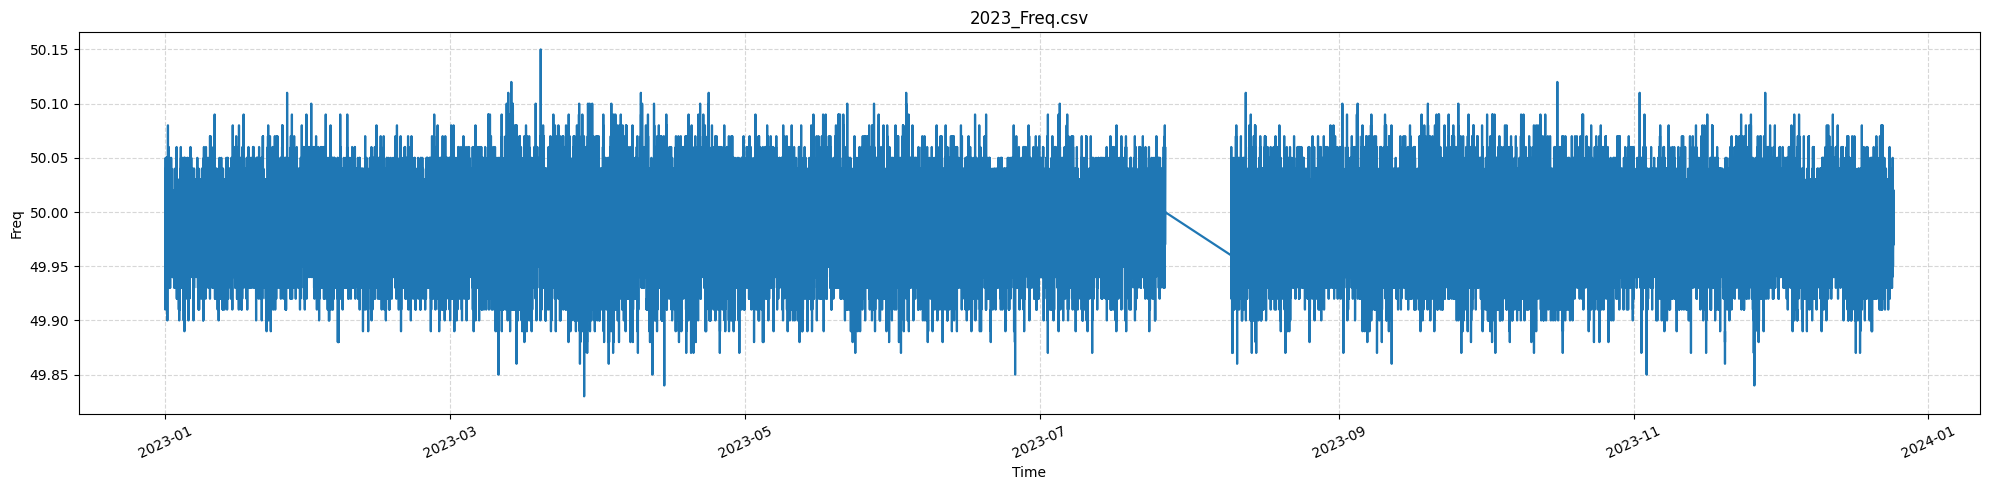

In [2]:
plot_series(r"..\dataset_clean\EPI_ChipPress\Freq\2023_Freq.csv.xz", start=0, end=-1)

min: 0.0 @ 2024-01-01 00:00:00
max: 10570.0 @ 2024-03-28 10:16:40


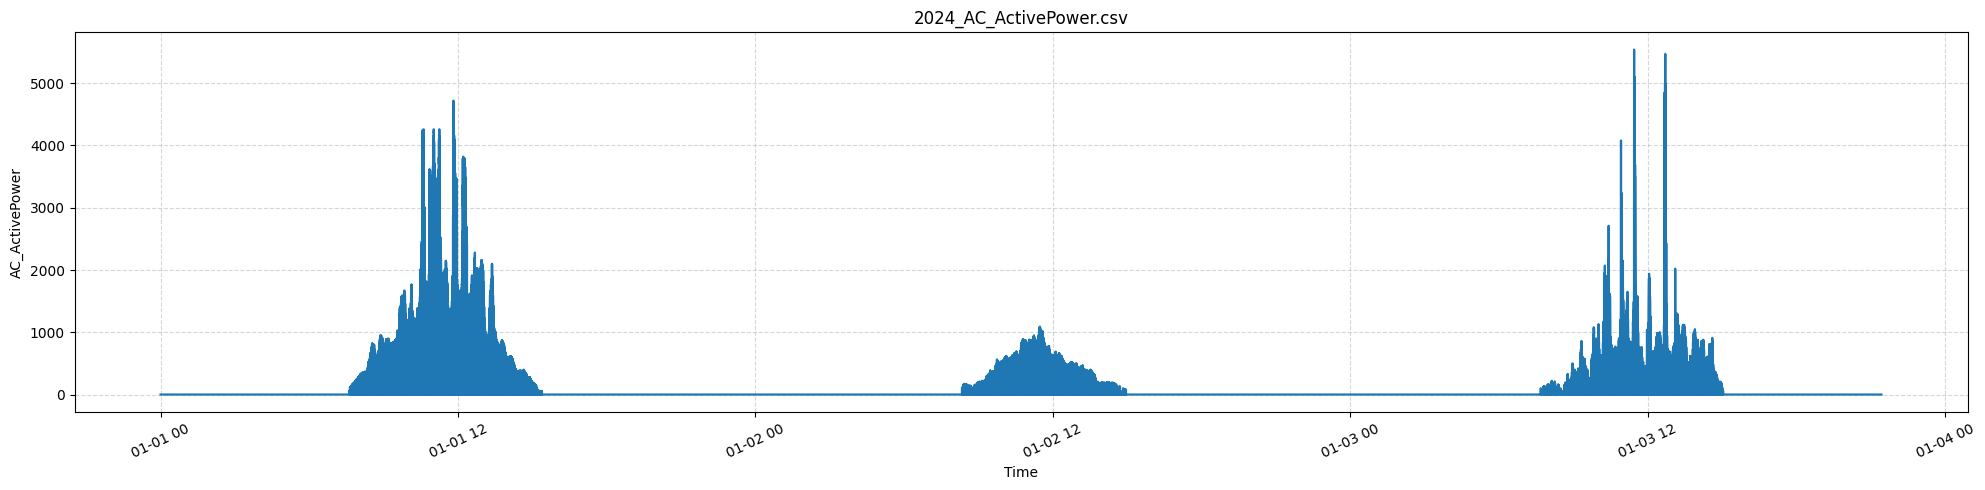

min: 0.0 @ 2024-01-01 00:00:00
max: 34390.0 @ 2024-03-25 17:38:50


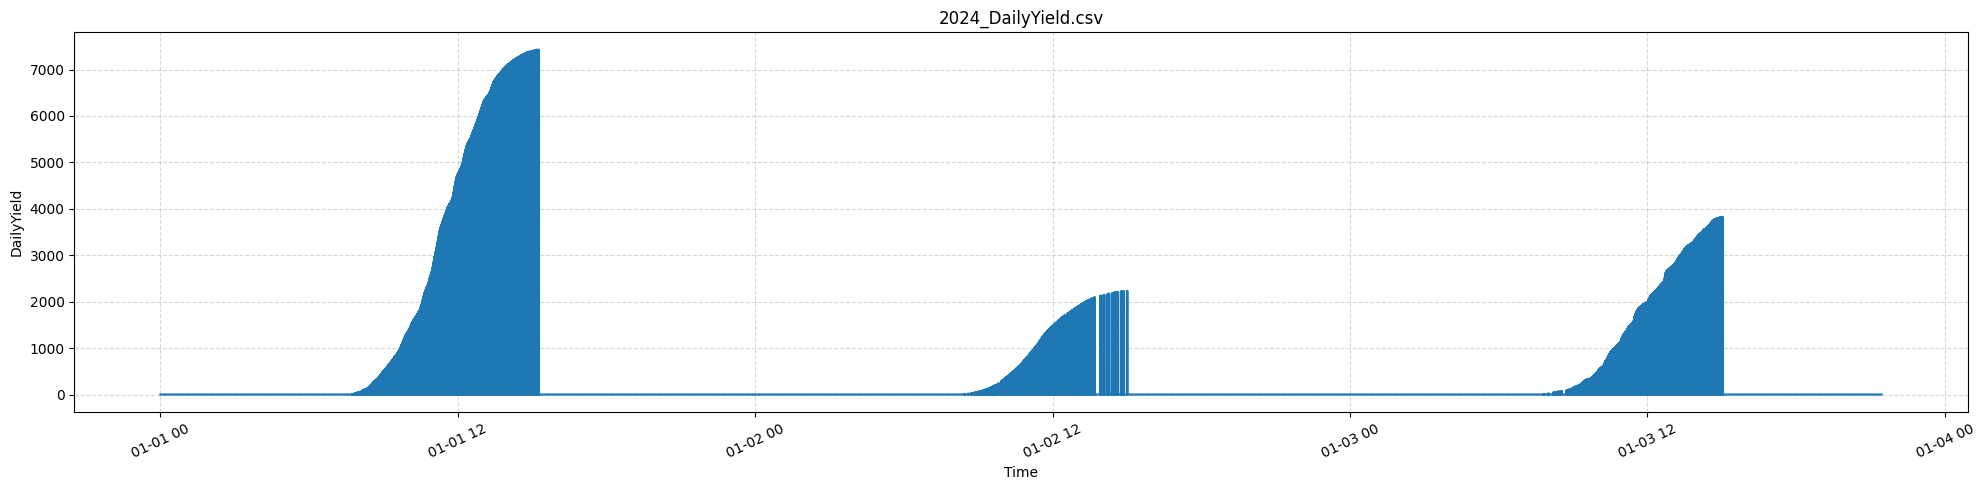

min: 0.0 @ 2024-01-01 00:00:00
max: 481.28 @ 2024-03-25 08:02:55


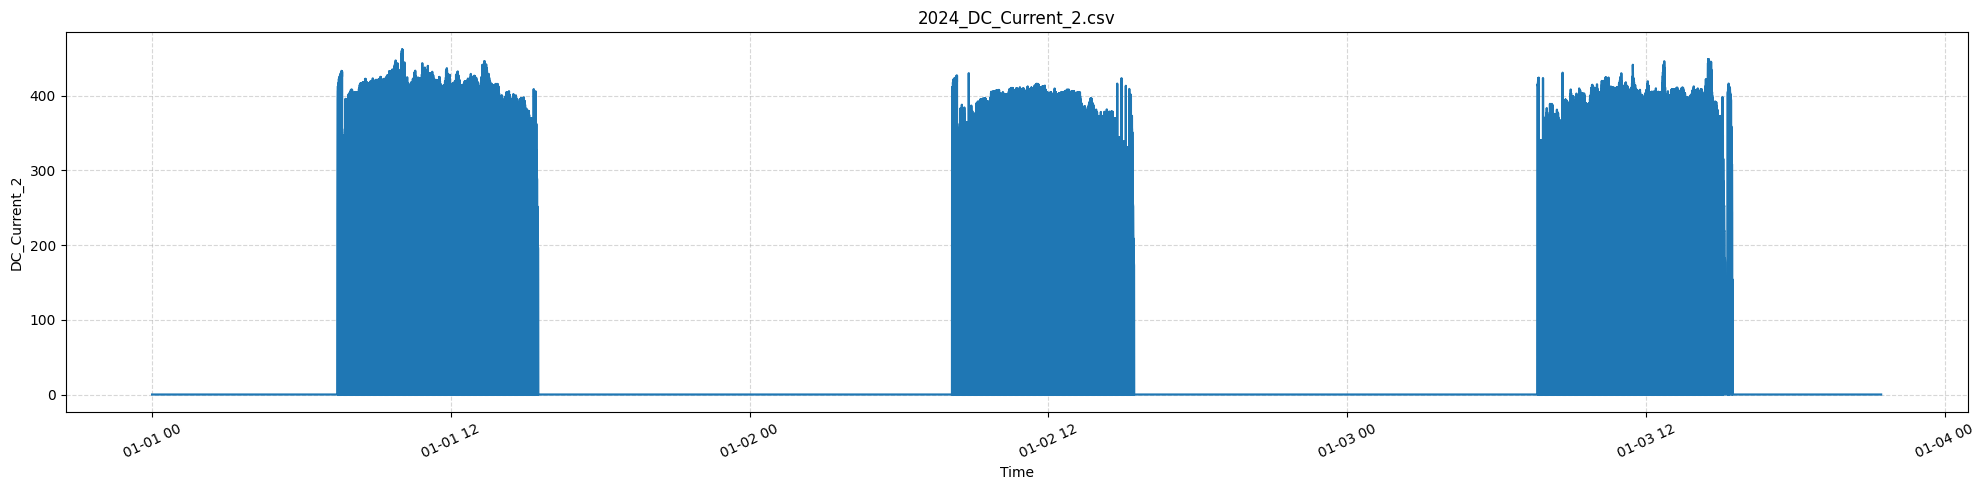

min: 0.0 @ 2024-01-01 00:00:00
max: 4185.0 @ 2024-04-02 11:11:45


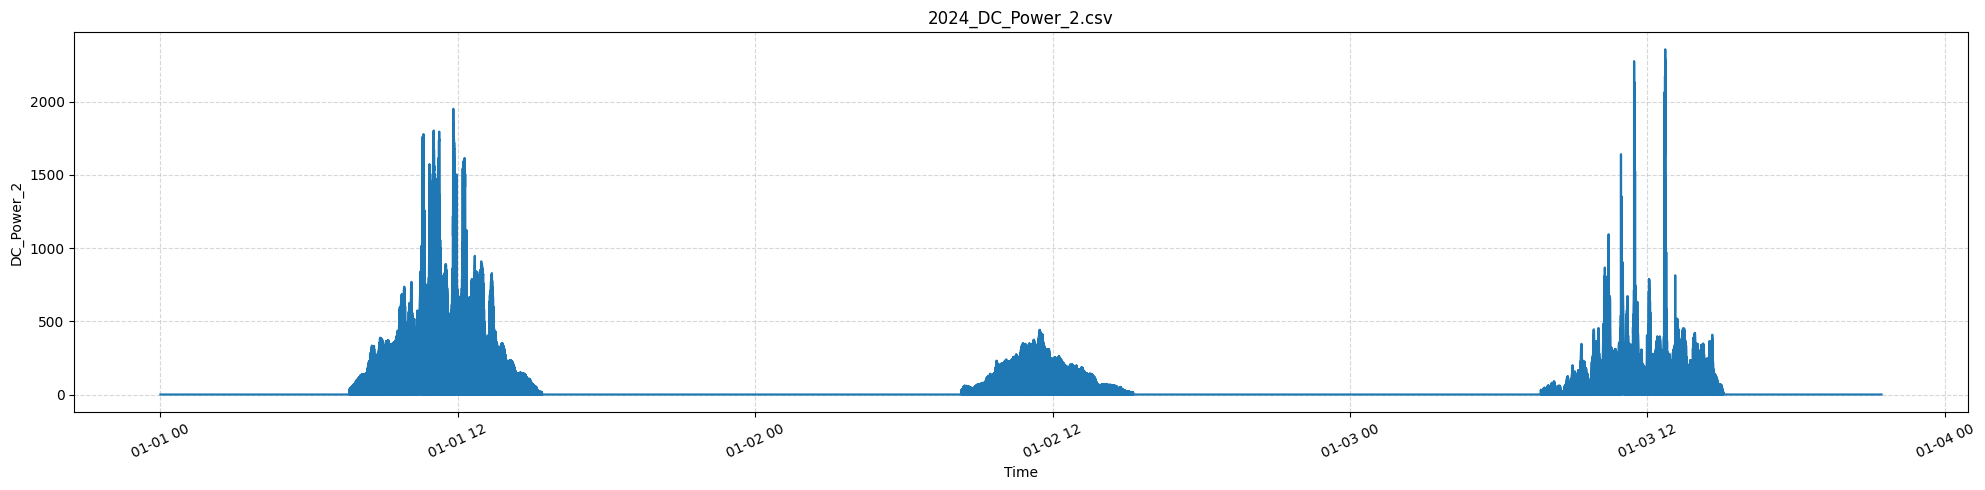

min: 0.0 @ 2024-01-01 00:00:00
max: 4196.0 @ 2024-03-28 10:16:40


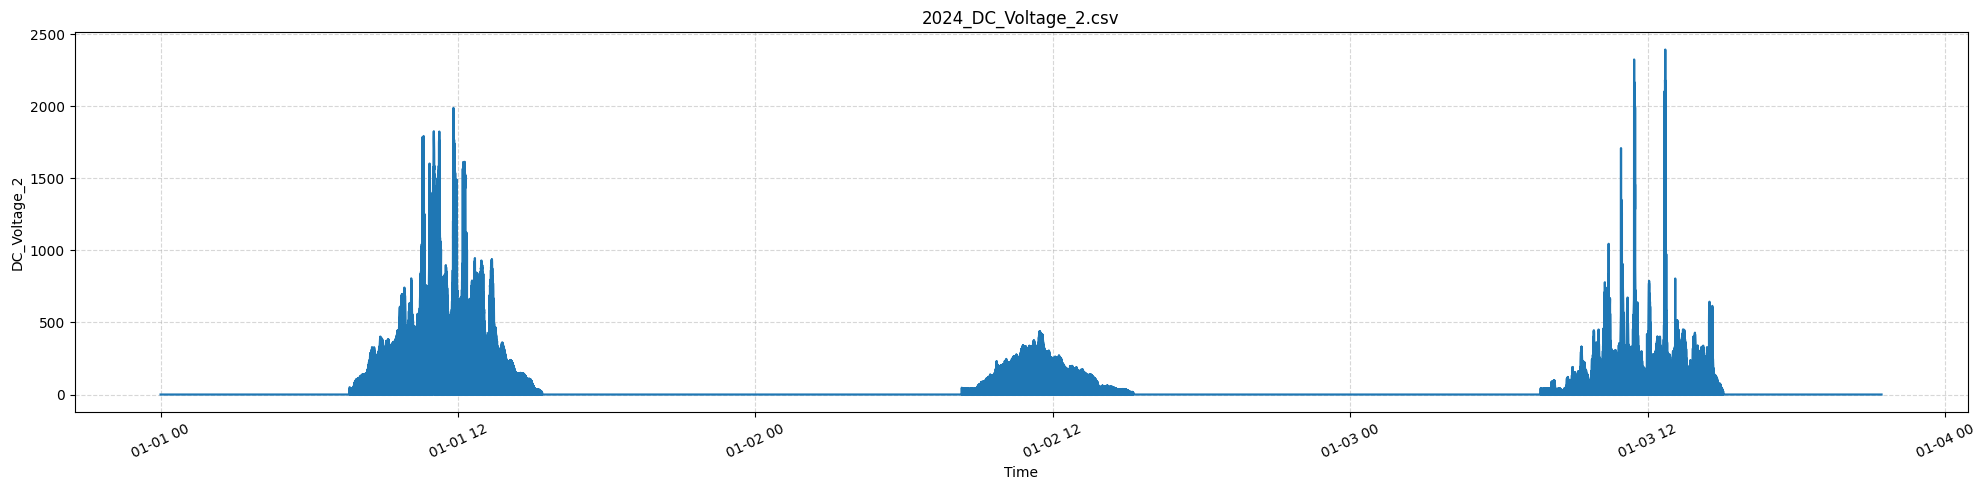

In [55]:
plot_series(r"../dataset_clean/EPI_PV/AC_ActivePower/2024_AC_ActivePower.csv.xz")
plot_series(r"../dataset_clean/EPI_PV/DailyYield/2024_DailyYield.csv.xz")

#plot_series(r"../dataset_clean/EPI_PV\DC_Current_1/2024_DC_Current_1.csv.xz")
plot_series(r"../dataset_clean/EPI_PV/DC_Current_2/2024_DC_Current_2.csv.xz")

#plot_series(r"../dataset_clean/EPI_PV\DC_Power_1/2024_DC_Power_1.csv.xz")
plot_series(r"../dataset_clean/EPI_PV\DC_Power_2/2024_DC_Power_2.csv.xz")

#plot_series(r"../dataset_clean/EPI_PV\DC_Voltage_1/2024_DC_Voltage_1.csv.xz")
plot_series(r"../dataset_clean/EPI_PV\DC_Voltage_2/2024_DC_Voltage_2.csv.xz")


In [8]:
extended["measurement"]

0      AC_ActivePower
1            Angle_U1
2          Angle_U1_f
3            Angle_U2
4          Angle_U2_f
            ...      
312        cos_phi1_f
313          cos_phi2
314        cos_phi2_f
315          cos_phi3
316        cos_phi3_f
Name: measurement, Length: 317, dtype: object

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(extended["measurement"])

0        AC_ActivePower
1              Angle_U1
2            Angle_U1_f
3              Angle_U2
4            Angle_U2_f
5              Angle_U3
6            Angle_U3_f
7             Angle_UI1
8           Angle_UI1_f
9             Angle_UI2
10          Angle_UI2_f
11            Angle_UI3
12          Angle_UI3_f
13         DC_Current_1
14         DC_Current_2
15           DC_Power_1
16           DC_Power_2
17         DC_Voltage_1
18         DC_Voltage_2
19           DailyYield
20                 Freq
21               Freq_f
22             GridFreq
23                   I1
24                I1_DC
25          I1_RMS_fund
26                 I1_f
27              I1_fund
28               I1_h11
29               I1_h13
30               I1_h15
31               I1_h17
32               I1_h19
33                I1_h2
34               I1_h21
35               I1_h23
36               I1_h25
37               I1_h27
38               I1_h29
39                I1_h3
40               I1_h31
41              

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(extended)

,measurement,unit,source,long_desc,machines_count,machine_ranges,existing_min,existing_max,mean_value,q05,q95,suggested_range
0,AC_ActivePower,W,PV,AC active power output of the inverter,1,"[[0.0, 10.57]]",0.000000,1.057000e+01,4.031061e-01,0.000000,3.110000e+00,"[0.0, 6.54]"
1,Angle_U1,°,TH,Voltage angle of phase U1,11,"[[0.0, 5.877472e-39], [-120.05834, 0.0], [-119...",-120.058340,1.200162e+02,-1.561679e+00,0.000000,0.000000e+00,"[-180.0, 180.0]"
2,Angle_U1_f,°,TH,Voltage angle of phase U1 (fundamental),11,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,"[-180.0, 180.0]"
3,Angle_U2,°,TH,Voltage angle of phase U2,11,"[[-120.260574, 5.877472e-39], [-120.350296, 11...",-120.600390,1.206766e+02,-5.439880e+01,-119.912440,-1.196159e+02,"[-180.0, 180.0]"
4,Angle_U2_f,°,TH,Voltage angle of phase U2 (fundamental),11,"[[-120.588585, 0.0], [-120.33569, 0.0], [-120....",-120.652250,1.205209e+02,-5.438880e+01,-119.906860,-1.196148e+02,"[-180.0, 180.0]"
5,Angle_U3,°,TH,Voltage angle of phase U3,11,"[[0.0, 120.756966], [0.0, 120.42682], [0.0, 12...",-177.596850,1.417862e+02,5.466157e+01,120.079080,1.203754e+02,"[-180.0, 180.0]"
6,Angle_U3_f,°,TH,Voltage angle of phase U3 (fundamental),11,"[[0.0, 120.72785], [0.0, 140.88354], [0.0, 120...",-177.597400,1.625261e+02,5.465334e+01,120.077510,1.203764e+02,"[-180.0, 180.0]"
7,Angle_UI1,°,TH,Phase angle between U and I in phase 1,11,"[[-9.848675, 83.497475], [-77.87879, 86.03513]...",-179.999800,1.799994e+02,-1.801276e+01,-17.101527,1.684715e+01,"[-180.0, 180.0]"
8,Angle_UI1_f,°,TH,Phase angle between voltage and current in pha...,11,"[[-19.455744, 83.356285], [-80.16096, 99.9759]...",-179.999730,1.799999e+02,-1.822214e+01,-17.109684,1.669545e+01,"[-180.0, 180.0]"
9,Angle_UI2,°,TH,Phase angle between U and I in phase 2,11,"[[0.0, 87.532974], [-14.928881, 61.505844], [-...",-179.997570,1.800000e+02,-2.364092e+01,-88.157809,3.128532e+01,"[-180.0, 180.0]"


In [26]:
# Assumes you already have:
# - df_measurement_limits (with columns like: measurement, observed_min, observed_max,
#   mean_of_means, typical_q05, typical_q95, typical_q01, typical_q99, q01_min_from_mins, q99_max_from_maxs)
# - the "groups" dictionary from the previous step (unit-pure grouping + ranges)

import pandas as pd
import math

# ---------- Helper: build lookup from measurement -> (group_name, unit, group_range) ----------
def build_group_lookup(groups_dict):
    meas2group = {}
    for gname, ginfo in groups_dict.items():
        unit = ginfo.get("unit")
        grange = ginfo.get("range")  # either [min, max] or None
        for m in ginfo.get("measurements", []):
            if m in meas2group:
                # If duplicates exist across groups, last one wins; you can assert instead if preferred
                pass
            meas2group[m] = (gname, unit, grange)
    return meas2group

meas2group = build_group_lookup(groups)

# ---------- Utilities ----------
def _first_num(*vals):
    """Return first value in vals that is a finite number (not NaN/None)."""
    for v in vals:
        if v is None:
            continue
        try:
            fv = float(v)
            if math.isfinite(fv):
                return fv
        except Exception:
            continue
    return None

def _mk_range_str(lo, hi):
    if lo is None or hi is None:
        return None
    try:
        return f"[{float(lo)}, {float(hi)}]"
    except Exception:
        return None

def _is_outlier(observed_min, observed_max, smin, smax):
    if smin is None or smax is None:
        return False
    try:
        omin = float(observed_min)
        omax = float(observed_max)
        return (omin < float(smin)) or (omax > float(smax))
    except Exception:
        return False

# ---------- Suggested range logic (fallbacks when group has no fixed range) ----------
def suggest_range(measurement, group_name, group_range, row):
    """
    Returns (smin, smax) for the measurement, using:
    1) group_range if provided (unit-pure constants, e.g., angles, frequency, PF, voltage windows, THD)
    2) group-specific fallbacks based on df statistics (q01..q99, observed_max, etc.)
    """
    if isinstance(group_range, (list, tuple)) and len(group_range) == 2:
        return float(group_range[0]), float(group_range[1])

    # pull useful stats from the row with safe fallbacks
    q01 = _first_num(row.get("typical_q01"), row.get("q01_min_from_mins"), row.get("observed_min"))
    q05 = _first_num(row.get("typical_q05"), row.get("typical_q01"), row.get("observed_min"))
    q95 = _first_num(row.get("typical_q95"), row.get("typical_q99"), row.get("observed_max"))
    q99 = _first_num(row.get("typical_q99"), row.get("q99_max_from_maxs"), row.get("observed_max"))
    omin = _first_num(row.get("observed_min"))
    omax = _first_num(row.get("observed_max"))

    # Group-specific fallbacks
    if group_name == "Real Power (W)":
        # PV and DC power are non-negative; others may be signed
        if measurement in {"AC_ActivePower"} or measurement.startswith("DC_Power_"):
            return 0.0, _first_num(q99, omax)
        else:
            return _first_num(q01, omin), _first_num(q99, omax)

    if group_name == "Reactive Power (var)":
        return _first_num(q01, omin), _first_num(q99, omax)

    if group_name == "Apparent Power (VA)":
        return 0.0, _first_num(q99, omax)

    if group_name == "Current (A)":
        # DC offsets (near zero) can be signed small
        if measurement.endswith("_DC"):
            return _first_num(q01, omin), _first_num(q99, omax)
        # RMS/fund magnitudes are non-negative
        return 0.0, _first_num(q99, omax)

    if group_name == "Voltage DC components (V)":
        # Near zero, may be signed small
        return _first_num(q01, omin), _first_num(q99, omax)

    if group_name == "Yields / Hours (count)":
        # Counters: >= 0 up to observed max
        return 0.0, _first_num(omax, q99)

    # Non-numeric/discrete or categories/timestamps: no numeric range
    if group_name in {"Rotation Field (discrete)", "Categorical", "Timestamp"}:
        return None, None

    # Default conservative fallback
    return _first_num(q01, omin), _first_num(q99, omax)

# ---------- Build the final per-measurement DataFrame ----------
# Ensure required columns exist (create NaNs if missing)
needed_cols = ["measurement","observed_min","observed_max","mean_of_means",
               "typical_q05","typical_q95","typical_q01","typical_q99","q01_min_from_mins","q99_max_from_maxs"]
for c in needed_cols:
    if c not in df_measurement_limits.columns:
        df_measurement_limits[c] = pd.NA

df = df_measurement_limits.copy()

# attach group info
df["group"] = df["measurement"].apply(lambda m: meas2group.get(m, ("Unassigned", None, None))[0])
df["_unit"] = df["measurement"].apply(lambda m: meas2group.get(m, ("Unassigned", None, None))[1])
df["_group_range"] = df["measurement"].apply(lambda m: meas2group.get(m, ("Unassigned", None, None))[2])

# compute q05, q95 with fallbacks
df["q05"] = df.apply(lambda r: _first_num(r["typical_q05"], r["typical_q01"], r["observed_min"]), axis=1)
df["q95"] = df.apply(lambda r: _first_num(r["typical_q95"], r["typical_q99"], r["observed_max"]), axis=1)

# compute suggested_range and outlier flag
smins, smaxs, srange_strs, outlier_flags = [], [], [], []
for _, r in df.iterrows():
    smin, smax = suggest_range(r["measurement"], r["group"], r["_group_range"], r)
    smins.append(smin); smaxs.append(smax)
    srange_strs.append(_mk_range_str(smin, smax))
    outlier_flags.append(_is_outlier(r["observed_min"], r["observed_max"], smin, smax))

df["suggested_min"] = smins
df["suggested_max"] = smaxs
df["suggested_range"] = srange_strs
df["outliers_detected"] = outlier_flags

# Final selection & nice ordering
final_cols = [
    "measurement",
    "group",
    "observed_min",
    "observed_max",
    "mean_of_means",
    "q05",
    "q95",
    "outliers_detected",
    "suggested_range",
]
df_final = df[final_cols].sort_values(["group","measurement"]).reset_index(drop=True)

# --- Print (or display) result ---
#print(df_final.to_string(index=False))

# Quick summary (optional):
#display("\n# measurements:", df_final["measurement"].nunique())
#print("# groups used:", df_final["group"].nunique())


In [30]:
# List unique groups from df_final["group"]
unique_groups = df_final["group"].dropna().unique().tolist()

print(f"Unique groups ({len(unique_groups)}):")
for i, g in enumerate(sorted(unique_groups), 1):
    print(f"{i}. {g}")

Unique groups (19):
1. Angles (°)
2. Apparent Power (VA)
3. Categorical
4. Current (A)
5. Current Harmonics (%)
6. Frequency (Hz)
7. Power Factor (–)
8. Reactive Power (var)
9. Real Power (W)
10. Rotation Field (discrete)
11. THD Current (%)
12. THD Voltage (%)
13. Timestamp
14. Unassigned
15. Voltage DC components (V)
16. Voltage Harmonics (%)
17. Voltage L–L (V)
18. Voltage L–N (V)
19. Yields / Hours (count)


Group: 
"Angles (°)" ->         Fine -> Ranges [-180, 180]

Apparent Power (VA) ->  Challanging -> Ranges [0, ???] Outlier check!
Categorical ->          Challanging -> Load Type ???

Current (A)                 -> [0,???]
Current Harmonics (%)       -> [0,???]
Frequency (Hz)
Power Factor (–)            -> ???
Reactive Power (var)
Real Power (W)
Rotation Field (discrete)
THD Current (%)
THD Voltage (%)
Timestamp
Unassigned
Voltage DC components (V)
Voltage Harmonics (%)       -> [0,???]
Voltage L–L (V)
Voltage L–N (V)
Yields / Hours (count)


,WsDateTime,DailyYield
count,6324480,1.486088e+06
mean,2024-07-01 23:59:57.500012800,8.826142e+02
min,2024-01-01 00:00:00,0.000000e+00
25%,2024-04-01 11:59:58.750000128,0.000000e+00
50%,2024-07-01 23:59:57.500000,0.000000e+00
75%,2024-10-01 11:59:56.249999872,0.000000e+00
max,2024-12-31 23:59:55,3.439000e+04
std,NaN,3.598899e+03


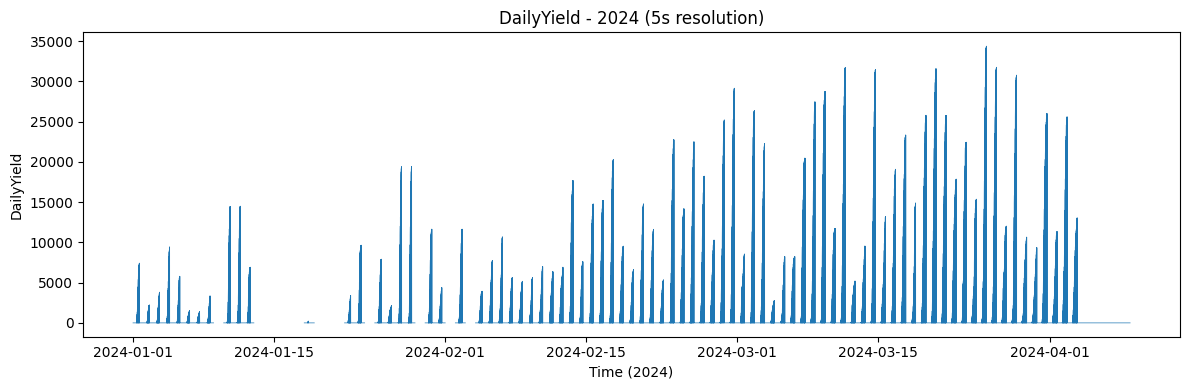

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File path
path = r"dataset_clean\IPE_PV\DailyYield\2024_DailyYield.csv.xz"

# Extract measurement from folder name
measurement = os.path.basename(os.path.dirname(path))

# Load file
df = pd.read_csv(path)
df["WsDateTime"] = pd.to_datetime(df["WsDateTime"])

# Rename column
df = df.rename(columns={"MEASURMENT": measurement})
display(df.describe())

# Plot
plt.figure(figsize=(12,4))
plt.plot(df["WsDateTime"], df[measurement], lw=0.5)
plt.xlabel("Time (2024)")
plt.ylabel(measurement)
plt.title(f"{measurement} - 2024 (5s resolution)")
plt.tight_layout()
plt.show()

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_final)

,measurement,group,observed_min,observed_max,mean_of_means,q05,q95,outliers_detected,suggested_range
0,Angle_U1,Angles (°),-120.058340,1.200162e+02,-1.561679e+00,0.000000,0.000000e+00,False,"[-180.0, 180.0]"
1,Angle_U1_f,Angles (°),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,False,"[-180.0, 180.0]"
2,Angle_U2,Angles (°),-120.600390,1.206766e+02,-5.439880e+01,-119.912440,-1.196159e+02,False,"[-180.0, 180.0]"
3,Angle_U2_f,Angles (°),-120.652250,1.205209e+02,-5.438880e+01,-119.906860,-1.196148e+02,False,"[-180.0, 180.0]"
4,Angle_U3,Angles (°),-177.596850,1.417862e+02,5.466157e+01,120.079080,1.203754e+02,False,"[-180.0, 180.0]"
5,Angle_U3_f,Angles (°),-177.597400,1.625261e+02,5.465334e+01,120.077510,1.203764e+02,False,"[-180.0, 180.0]"
6,Angle_UI1,Angles (°),-179.999800,1.799994e+02,-1.801276e+01,-17.101527,1.684715e+01,False,"[-180.0, 180.0]"
7,Angle_UI1_f,Angles (°),-179.999730,1.799999e+02,-1.822214e+01,-17.109684,1.669545e+01,False,"[-180.0, 180.0]"
8,Angle_UI2,Angles (°),-179.997570,1.800000e+02,-2.364092e+01,-88.157809,3.128532e+01,False,"[-180.0, 180.0]"
9,Angle_UI2_f,Angles (°),-179.999950,1.799997e+02,-2.364176e+01,-87.759613,1.074998e+00,False,"[-180.0, 180.0]"


In [11]:
# Show all columns
pd.set_option("display.max_columns", None)

display(df_machine_stats_wide)

# (Optional) Reset back to default after
pd.reset_option("display.max_columns")


,measurement,EPI_ChipPress__min,EPI_ChipPress__max,EPI_ChipPress__mean,EPI_ChipSaw__min,EPI_ChipSaw__max,EPI_ChipSaw__mean,EPI_HighTempOven__min,EPI_HighTempOven__max,EPI_HighTempOven__mean,EPI_PickAndPlace__min,EPI_PickAndPlace__max,EPI_PickAndPlace__mean,EPI_PumpStation1__min,EPI_PumpStation1__max,EPI_PumpStation1__mean,EPI_PumpStation2__min,EPI_PumpStation2__max,EPI_PumpStation2__mean,EPI_ScreenPrinter__min,EPI_ScreenPrinter__max,EPI_ScreenPrinter__mean,EPI_SolderOven__min,EPI_SolderOven__max,EPI_SolderOven__mean,EPI_TotalLoad__min,EPI_TotalLoad__max,EPI_TotalLoad__mean,EPI_VacuumSoldering__min,EPI_VacuumSoldering__max,EPI_VacuumSoldering__mean,EPI_WashingMachine__min,EPI_WashingMachine__max,EPI_WashingMachine__mean,IPE_PV__min,IPE_PV__max,IPE_PV__mean,TEC_48S__min,TEC_48S__max,TEC_48S__mean,TEC_CFST161__min,TEC_CFST161__max,TEC_CFST161__mean,TEC_CTX800TC__min,TEC_CTX800TC__max,TEC_CTX800TC__mean,TEC_Chiron800__min,TEC_Chiron800__max,TEC_Chiron800__mean,TEC_DMF3008__min,TEC_DMF3008__max,TEC_DMF3008__mean,TEC_DMU125MB__min,TEC_DMU125MB__max,TEC_DMU125MB__mean,TEC_DNG50evo__min,TEC_DNG50evo__max,TEC_DNG50evo__mean,TEC_E110__min,TEC_E110__max,TEC_E110__mean,TEC_E30D2__min,TEC_E30D2__max,TEC_E30D2__mean,TEC_JWA24__min,TEC_JWA24__max,TEC_JWA24__mean,TEC_MV2400R__min,TEC_MV2400R__max,TEC_MV2400R__mean
0,AC_ActivePower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.57,0.403106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Angle_U1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.877472e-39,2.806552e-40,-120.058340,0.000000,-5.732865,-119.927410,0.00000,-5.726794,-119.910100,0.000000,-5.725792,0.000000,120.016230,5.730856,0.000000,120.00956,5.730672,-119.924900,0.000000,-5.726716,0.000000,120.009480,5.730572,0.000000,5.877472e-39,2.806566e-40,-120.051390,0.000000,-5.732665,-119.906750,0.00000,-5.725735
2,Angle_U1_f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,Angle_U2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.260574,5.877472e-39,-1.197817e+02,-120.350296,119.906220,-119.911417,-120.198920,120.09248,-119.776606,-120.600390,120.083490,-119.773430,-119.976340,120.676575,120.039413,-119.970570,120.49986,120.025184,-120.208080,120.095580,-119.776743,-119.974990,120.488686,120.033733,-120.548860,5.877472e-39,-1.197782e+02,-120.332600,119.907740,-119.911811,-120.172740,120.08781,-119.775213
4,Angle_U2_f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.588585,0.000000e+00,-1.197627e+02,-120.335690,0.000000,-119.893026,-120.204056,0.00000,-119.758174,-120.600390,0.000000,-119.755303,0.000000,120.520950,120.027254,0.000000,120.48650,120.012903,-120.628624,0.000000,-119.758006,0.000000,120.501366,120.019361,-120.480576,0.000000e+00,-1.197581e+02,-120.652250,0.000000,-119.893147,-120.436806,0.00000,-119.757981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,cos_phi1_f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
print(*unique_measurements)

AC_ActivePower Angle_U1 Angle_U1_f Angle_U2 Angle_U2_f Angle_U3 Angle_U3_f Angle_UI1 Angle_UI1_f Angle_UI2 Angle_UI2_f Angle_UI3 Angle_UI3_f DC_Current_1 DC_Current_2 DC_Power_1 DC_Power_2 DC_Voltage_1 DC_Voltage_2 DailyYield Freq Freq_f GridFreq I1 I1_DC I1_RMS_fund I1_f I1_fund I1_h11 I1_h13 I1_h15 I1_h17 I1_h19 I1_h2 I1_h21 I1_h23 I1_h25 I1_h27 I1_h29 I1_h3 I1_h31 I1_h4 I1_h5 I1_h7 I1_h9 I2 I2_DC I2_RMS_fund I2_f I2_fund I2_h11 I2_h13 I2_h15 I2_h17 I2_h19 I2_h2 I2_h21 I2_h23 I2_h25 I2_h27 I2_h29 I2_h3 I2_h31 I2_h4 I2_h5 I2_h7 I2_h9 I3 I3_DC I3_RMS_fund I3_f I3_fund I3_h11 I3_h13 I3_h15 I3_h17 I3_h19 I3_h2 I3_h21 I3_h23 I3_h25 I3_h27 I3_h29 I3_h3 I3_h31 I3_h4 I3_h5 I3_h7 I3_h9 IN IN_DC IN_RMS_fund IN_f IN_fund IN_h11 IN_h13 IN_h15 IN_h17 IN_h19 IN_h2 IN_h21 IN_h23 IN_h25 IN_h27 IN_h29 IN_h3 IN_h31 IN_h4 IN_h5 IN_h7 IN_h9 I_sys I_sys_f LoadType1 LoadType1_f LoadType2 LoadType2_f LoadType3 LoadType3_f OpHours P1 P1_f P2 P2_f P3 P3_f PF1 PF1_h PF2 PF2_h PF3 PF3_h PF_total PF_total_arith

In [13]:
from __future__ import annotations

import numpy as np
import pandas as pd
import re


def derive_measurement_ranges(
    df_machine_stats_wide: pd.DataFrame,
    q_low: float = 0.01,
    q_high: float = 0.99,
    slack_ratio: float = 0.02,
    apply_physical_clamps: bool = True,
) -> pd.DataFrame:
    """
    Build per-measurement limits from a wide per-machine table.

    Inputs
    ------
    df_machine_stats_wide : DataFrame
        One row per measurement. Columns include:
          'measurement', and for each machine: '<Machine>__min', '__max', '__mean'.

    Parameters
    ----------
    q_low, q_high : float
        Quantiles computed across *machines* for the per-machine mins and maxes.
        Used to reduce the impact of outliers (e.g., 0.01 and 0.99).
    slack_ratio : float
        Extra margin added on each side as a fraction of the empirical range.
    apply_physical_clamps : bool
        If True, clip suggested bounds to simple, conservative physical limits
        for known families (PF, THD, angles, RotField/LoadType, OpHours, Freq).

    Returns
    -------
    df_measurement_limits : DataFrame
        Columns:
          measurement,
          observed_min, observed_max,
          mean_of_means, median_of_means, mad_of_means,
          q01_min, q99_max,
          suggested_min, suggested_max,
          n_machines_min, n_machines_max, n_machines_mean,
          clamp_rule (pattern used for any physical clamp, else None).
    """
    # Identify per-machine columns
    cols_min = [c for c in df_machine_stats_wide.columns if c.endswith("__min")]
    cols_max = [c for c in df_machine_stats_wide.columns if c.endswith("__max")]
    cols_mean = [c for c in df_machine_stats_wide.columns if c.endswith("__mean")]

    # Compile simple physical clamps (very conservative)
    # NOTE: These are *optional* and only clip extremes, they do not set the range alone.
    clamp_rules: list[tuple[re.Pattern, tuple[float | None, float | None]]] = [
        # Power factor & cos(phi): bounded by [-1, 1]
        (re.compile(r"^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[123]?(_f)?)$"), (-1.0, 1.0)),
        # Rotation field & load type indicators: in {-1,0,1}
        (re.compile(r"^(RotField(_f)?)$"), (-1.0, 1.0)),
        (re.compile(r"^LoadType[123](_f)?$"), (-1.0, 1.0)),
        # THD percentages: non-negative, set a wide ceiling
        (re.compile(r"^THD_.*$"), (0.0, 300.0)),
        # Operating hours: non-negative
        (re.compile(r"^OpHours$"), (0.0, None)),
        # Angles (degrees): keep within a generous circle bound
        (re.compile(r"^(Angle_.*|.*_Angle_.*)$"), (-360.0, 360.0)),
        # Frequency: non-negative, very broad ceiling to avoid over-clipping
        (re.compile(r"^(Freq(_f)?|GridFreq)$"), (0.0, 100.0)),
    ]

    def apply_clamp(name: str, lo: float, hi: float) -> tuple[float, float, str | None]:
        """Optionally clip [lo, hi] to simple physical limits based on name."""
        rule_used = None
        if not apply_physical_clamps:
            return lo, hi, rule_used
        for pat, (c_lo, c_hi) in clamp_rules:
            if pat.match(name):
                rule_used = pat.pattern
                if c_lo is not None and not np.isnan(lo):
                    lo = max(lo, c_lo)
                if c_hi is not None and not np.isnan(hi):
                    hi = min(hi, c_hi)
                break
        return lo, hi, rule_used

    def row_limits(row: pd.Series) -> pd.Series:
        name = row["measurement"]

        vmins = row[cols_min].astype(float).to_numpy()
        vmaxs = row[cols_max].astype(float).to_numpy()
        vmeans = row[cols_mean].astype(float).to_numpy()

        vmins = vmins[~np.isnan(vmins)]
        vmaxs = vmaxs[~np.isnan(vmaxs)]
        vmeans = vmeans[~np.isnan(vmeans)]

        n_min = int(vmins.size)
        n_max = int(vmaxs.size)
        n_mean = int(vmeans.size)

        observed_min = np.nanmin(vmins) if n_min else np.nan
        observed_max = np.nanmax(vmaxs) if n_max else np.nan
        mean_of_means = float(np.nanmean(vmeans)) if n_mean else np.nan
        median_of_means = float(np.nanmedian(vmeans)) if n_mean else np.nan

        # Robust spread via MAD (converted to ~std using 1.4826)
        if n_mean:
            mad = float(np.nanmedian(np.abs(vmeans - median_of_means)))
            mad_std = 1.4826 * mad
        else:
            mad = np.nan
            mad_std = np.nan

        # Robust quantiles across machines for mins/maxs
        q_lo = float(np.quantile(vmins, q_low)) if n_min else np.nan
        q_hi = float(np.quantile(vmaxs, q_high)) if n_max else np.nan

        # Empirical base range (use quantiles if available, else observed)
        base_lo = q_lo if not np.isnan(q_lo) else observed_min
        base_hi = q_hi if not np.isnan(q_hi) else observed_max

        # If we have variability across per-machine means, expand toward mean ± 4 * MAD-std
        if not np.isnan(mad_std) and mad_std > 0:
            m_lo = median_of_means - 4.0 * mad_std
            m_hi = median_of_means + 4.0 * mad_std
            cand_lo = np.nanmin([base_lo, m_lo]) if not np.isnan(base_lo) else m_lo
            cand_hi = np.nanmax([base_hi, m_hi]) if not np.isnan(base_hi) else m_hi
        else:
            cand_lo, cand_hi = base_lo, base_hi

        # Add small slack margin on both sides
        if not np.isnan(cand_lo) and not np.isnan(cand_hi) and cand_hi > cand_lo:
            rng = cand_hi - cand_lo
            slack = slack_ratio * rng
            sugg_lo = cand_lo - slack
            sugg_hi = cand_hi + slack
        else:
            # Fallback: if range is degenerate, pad around the central value
            center = median_of_means if not np.isnan(median_of_means) else mean_of_means
            if np.isnan(center):
                sugg_lo, sugg_hi = cand_lo, cand_hi
            else:
                pad = 0.05 * abs(center) if center != 0 else 1.0
                sugg_lo, sugg_hi = center - pad, center + pad

        # Ensure suggested bounds at least cover observed extremes
        if not np.isnan(observed_min):
            sugg_lo = np.nanmin([sugg_lo, observed_min])
        if not np.isnan(observed_max):
            sugg_hi = np.nanmax([sugg_hi, observed_max])

        # Optional: clip to conservative physical limits (no aggressive shrinking)
        sugg_lo, sugg_hi, rule = apply_clamp(name, sugg_lo, sugg_hi)

        return pd.Series(
            {
                "measurement": name,
                "observed_min": observed_min,
                "observed_max": observed_max,
                "mean_of_means": mean_of_means,
                "median_of_means": median_of_means,
                "mad_of_means": mad,
                f"q{int(100*q_low):02d}_min": q_lo,
                f"q{int(100*q_high):02d}_max": q_hi,
                "suggested_min": sugg_lo,
                "suggested_max": sugg_hi,
                "n_machines_min": n_min,
                "n_machines_max": n_max,
                "n_machines_mean": n_mean,
                "clamp_rule": rule,
            }
        )

    out = df_machine_stats_wide.apply(row_limits, axis=1)
    # Order columns nicely
    order = [
        "measurement",
        "observed_min", "observed_max",
        "mean_of_means", "median_of_means", "mad_of_means",
        f"q{int(100*q_low):02d}_min", f"q{int(100*q_high):02d}_max",
        "suggested_min", "suggested_max",
        "n_machines_min", "n_machines_max", "n_machines_mean",
        "clamp_rule",
    ]
    return out[order].sort_values("measurement").reset_index(drop=True)


# -------------------------
# Example usage (no saving):
# -------------------------

# df_machine_stats_wide is your existing table (one row per measurement)
# unique_measurements = df_machine_stats_wide["measurement"].sort_values().tolist()

df_measurement_limits = derive_measurement_ranges(
    df_machine_stats_wide,
    q_low=0.01,       # use 1st percentile of per-machine minima
    q_high=0.99,      # 99th percentile of per-machine maxima
    slack_ratio=0.02, # add 2% margin around that range
    apply_physical_clamps=True
)

# Peek
display(df_measurement_limits)


,measurement,observed_min,observed_max,mean_of_means,median_of_means,mad_of_means,q01_min,q99_max,suggested_min,suggested_max,n_machines_min,n_machines_max,n_machines_mean,clamp_rule
0,AC_ActivePower,0.00000,10.570000,0.403106,0.403106,0.000000,0.000000,10.570000,-0.211400,10.781400,1,1,1,None
1,Angle_U1,-120.05834,120.016230,-1.561679,-5.725735,0.007129,-120.057645,120.015563,-124.859109,124.817027,11,11,11,^(Angle_.*|.*_Angle_.*)$
2,Angle_U1_f,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,11,11,11,^(Angle_.*|.*_Angle_.*)$
3,Angle_U2,-120.60039,120.676575,-54.398796,-119.776606,0.005105,-120.595237,120.658903,-125.420320,125.483986,11,11,11,^(Angle_.*|.*_Angle_.*)$
4,Angle_U2_f,-120.65225,120.520950,-54.388805,-119.758006,0.004644,-120.649887,120.518992,-125.473265,125.342369,11,11,11,^(Angle_.*|.*_Angle_.*)$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,cos_phi1_f,-1.00000,1.000000,0.688621,0.911630,0.080324,-1.000000,1.000000,-1.000000,1.000000,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
330,cos_phi2,-1.00000,1.000000,0.605914,0.853013,0.102443,-1.000000,1.000000,-1.000000,1.000000,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
331,cos_phi2_f,-1.00000,1.000000,0.604986,0.851226,0.093033,-1.000000,1.000000,-1.000000,1.000000,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
332,cos_phi3,-1.00000,1.000000,0.594527,0.764405,0.182680,-1.000000,1.000000,-1.000000,1.000000,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...


In [14]:
from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd


# -----------------------
# Loading & preprocessing
# -----------------------

def discover_stat_files(base_dir: Path) -> list[Path]:
    """Find all '*_stats.csv' files under base_dir."""
    return sorted(base_dir.rglob("*_stats.csv"))

def parse_context(file_path: Path, base_dir: Path) -> tuple[str, str, str]:
    """
    Extract (machine, measurement, year) from path structure:
      validation_results/<MACHINE>/<MEASUREMENT>/<YEAR>_<MEASUREMENT>_stats.csv
    """
    rel = file_path.relative_to(base_dir)
    if len(rel.parts) < 3:
        raise ValueError(f"Unexpected path depth for stats file: {file_path}")

    machine = rel.parts[0]
    measurement = rel.parts[1]

    m = re.match(r"^(\d{4})_.*?_stats\.csv$", rel.name)
    if not m:
        raise ValueError(f"Filename does not match '<year>_<measurement>_stats.csv': {file_path}")
    year = m.group(1)
    return machine, measurement, year


def load_stats(base_dir: Path) -> pd.DataFrame:
    """
    Load and concatenate all stats files into a single DataFrame with columns:
      ['file_path','min','max','mean','std','q01','q05','q25','q50','q75','q95','q99',
       'machine','measurement','year']
    """
    files = discover_stat_files(base_dir)
    if not files:
        raise FileNotFoundError(f"No '*_stats.csv' files found under {base_dir}")

    frames = []
    for fp in files:
        machine, measurement, year = parse_context(fp, base_dir)
        df = pd.read_csv(fp)

        expected = [
            "file_path", "min", "max", "mean", "std",
            "q01", "q05", "q25", "q50", "q75", "q95", "q99",
        ]
        missing = [c for c in expected if c not in df.columns]
        if missing:
            raise ValueError(f"Missing columns {missing} in file {fp}")

        for col in expected[1:]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        df["machine"] = machine
        df["measurement"] = measurement
        df["year"] = year
        frames.append(df)

    all_stats = pd.concat(frames, ignore_index=True)
    cols_order = [
        "machine", "measurement", "year",
        "file_path", "min", "max", "mean", "std",
        "q01", "q05", "q25", "q50", "q75", "q95", "q99",
    ]
    return all_stats[cols_order]


def list_unique_measurements(stats_df: pd.DataFrame) -> list[str]:
    """Return a sorted list of all unique measurement names."""
    return sorted(stats_df["measurement"].dropna().unique().tolist())


# ----------------------------------------
# Summarize per (measurement, machine/year)
# ----------------------------------------

def summarize_by_measurement_machine(stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Per-(measurement, machine) summary across years:
      - min_observed: min of yearly 'min'
      - max_observed: max of yearly 'max'
      - mean_of_means: mean of yearly 'mean' (unweighted)

      Quantiles (aggregated across years):
      - qXX_mean: mean of yearly qXX (q01, q05, q25, q50, q75, q95, q99)
      - q01_min_year: min of yearly q01  (very conservative lower tail across years)
      - q99_max_year: max of yearly q99  (very conservative upper tail across years)
      - years: comma-separated list of years observed
    """
    grouped = stats_df.groupby(["measurement", "machine"], dropna=False)

    agg_dict = {
        "min": ["min"],
        "max": ["max"],
        "mean": ["mean"],
        "q01": ["mean", "min"],
        "q05": ["mean"],
        "q25": ["mean"],
        "q50": ["mean"],
        "q75": ["mean"],
        "q95": ["mean"],
        "q99": ["mean", "max"],
        "year": [lambda s: ",".join(sorted(map(str, set(s))))],
    }

    gb = grouped.agg(agg_dict)

    # Flatten the MultiIndex columns
    gb.columns = [
        ("min_observed" if (c == "min" and a == "min") else
         "max_observed" if (c == "max" and a == "max") else
         "mean_of_means" if (c == "mean" and a == "mean") else
         "q01_mean" if (c == "q01" and a == "mean") else
         "q01_min_year" if (c == "q01" and a == "min") else
         "q05_mean" if (c == "q05" and a == "mean") else
         "q25_mean" if (c == "q25" and a == "mean") else
         "q50_mean" if (c == "q50" and a == "mean") else
         "q75_mean" if (c == "q75" and a == "mean") else
         "q95_mean" if (c == "q95" and a == "mean") else
         "q99_mean" if (c == "q99" and a == "mean") else
         "q99_max_year" if (c == "q99" and a == "max") else
         "years")
        for c, a in gb.columns
    ]
    gb = gb.reset_index()

    # Ensure numeric types on new columns
    num_cols = [
        "min_observed", "max_observed", "mean_of_means",
        "q01_mean", "q05_mean", "q25_mean", "q50_mean", "q75_mean", "q95_mean", "q99_mean",
        "q01_min_year", "q99_max_year",
    ]
    for c in num_cols:
        if c in gb.columns:
            gb[c] = pd.to_numeric(gb[c], errors="coerce")

    gb = gb.sort_values(["measurement", "machine"]).reset_index(drop=True)
    return gb


# --------------------------------------------
# Wide per-measurement table with quantiles in
# --------------------------------------------

def build_wide_measurement_machine_stats(
    summary_df: pd.DataFrame,
    col_sep: str = "__",
    include_stats: tuple[str, ...] = ("min", "max", "mean", "q01", "q05", "q25", "q50", "q75", "q95", "q99"),
) -> pd.DataFrame:
    """
    Create a wide table with one row per measurement and columns per machine:
      <Machine>__<stat> where <stat> in include_stats

    Uses summary columns:
      - 'min_observed'  -> 'min'
      - 'max_observed'  -> 'max'
      - 'mean_of_means' -> 'mean'
      - 'qXX_mean'      -> 'qXX' for XX in {01,05,25,50,75,95,99}
    """
    # map summary col -> flattened stat suffix
    stat_map = {
        "min_observed": "min",
        "max_observed": "max",
        "mean_of_means": "mean",
        "q01_mean": "q01",
        "q05_mean": "q05",
        "q25_mean": "q25",
        "q50_mean": "q50",
        "q75_mean": "q75",
        "q95_mean": "q95",
        "q99_mean": "q99",
    }

    # Only pivot the stats requested
    pivot_values = [k for k, v in stat_map.items() if v in include_stats]

    pv = summary_df.pivot(
        index="measurement",
        columns="machine",
        values=pivot_values,
    )

    machines = sorted(summary_df["machine"].unique())

    # Desired MultiIndex column order: per machine, all requested stats
    desired_multi_cols = []
    for m in machines:
        for src_col in pivot_values:
            key = (src_col, m)
            if key in pv.columns:
                desired_multi_cols.append(key)

    pv = pv.reindex(columns=pd.MultiIndex.from_tuples(desired_multi_cols))

    # Flatten: '<Machine>__<stat>'
    flat_cols = [f"{m}{col_sep}{stat_map[src]}" for (src, m) in pv.columns]
    pv.columns = flat_cols

    return pv.reset_index()  # keep 'measurement'


# ------------------------------------
# Range derivation using quantiles too
# ------------------------------------

def derive_measurement_ranges(
    df_machine_stats_wide: pd.DataFrame,
    q_low: float = 0.01,
    q_high: float = 0.99,
    slack_ratio: float = 0.02,
    apply_physical_clamps: bool = True,
) -> pd.DataFrame:
    """
    Build per-measurement limits from the wide per-machine table.
    Now leverages per-machine quantiles (q01..q99) in addition to min/max/mean.

    Output columns:
      measurement,
      observed_min, observed_max,
      mean_of_means, median_of_means, mad_of_means,
      typical_q01, typical_q05, typical_q50, typical_q95, typical_q99,
      q{low*100:02d}_min_from_mins, q{high*100:02d}_max_from_maxs,
      suggested_min, suggested_max,
      n_machines_min, n_machines_max, n_machines_mean, n_machines_q
      clamp_rule
    """
    # Collect column groups
    def cols_end(suffix: str) -> list[str]:
        return [c for c in df_machine_stats_wide.columns if c.endswith(suffix)]

    cols_min = cols_end("__min")
    cols_max = cols_end("__max")
    cols_mean = cols_end("__mean")
    cols_q01 = cols_end("__q01")
    cols_q05 = cols_end("__q05")
    cols_q25 = cols_end("__q25")
    cols_q50 = cols_end("__q50")
    cols_q75 = cols_end("__q75")
    cols_q95 = cols_end("__q95")
    cols_q99 = cols_end("__q99")

    # Conservative physical clamps (optional)
    clamp_rules: list[tuple[re.Pattern, tuple[float | None, float | None]]] = [
        (re.compile(r"^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[123]?(_f)?)$"), (-1.0, 1.0)),
        (re.compile(r"^(RotField(_f)?)$"), (-1.0, 1.0)),
        (re.compile(r"^LoadType[123](_f)?$"), (-1.0, 1.0)),
        (re.compile(r"^THD_.*$"), (0.0, 300.0)),
        (re.compile(r"^OpHours$"), (0.0, None)),
        (re.compile(r"^(Angle_.*|.*_Angle_.*)$"), (-360.0, 360.0)),
        (re.compile(r"^(Freq(_f)?|GridFreq)$"), (0.0, 100.0)),
    ]

    def apply_clamp(name: str, lo: float, hi: float) -> tuple[float, float, str | None]:
        rule_used = None
        if not apply_physical_clamps:
            return lo, hi, rule_used
        for pat, (c_lo, c_hi) in clamp_rules:
            if pat.match(name):
                rule_used = pat.pattern
                if c_lo is not None and not np.isnan(lo):
                    lo = max(lo, c_lo)
                if c_hi is not None and not np.isnan(hi):
                    hi = min(hi, c_hi)
                break
        return lo, hi, rule_used

    def row_limits(row: pd.Series) -> pd.Series:
        name = row["measurement"]

        vmins  = row[cols_min ].astype(float).to_numpy()
        vmaxs  = row[cols_max ].astype(float).to_numpy()
        vmeans = row[cols_mean].astype(float).to_numpy()
        vq01   = row[cols_q01].astype(float).to_numpy()
        vq05   = row[cols_q05].astype(float).to_numpy()
        vq25   = row[cols_q25].astype(float).to_numpy()
        vq50   = row[cols_q50].astype(float).to_numpy()
        vq75   = row[cols_q75].astype(float).to_numpy()
        vq95   = row[cols_q95].astype(float).to_numpy()
        vq99   = row[cols_q99].astype(float).to_numpy()

        vmins  = vmins[~np.isnan(vmins)]
        vmaxs  = vmaxs[~np.isnan(vmaxs)]
        vmeans = vmeans[~np.isnan(vmeans)]
        vq01   = vq01[~np.isnan(vq01)]
        vq05   = vq05[~np.isnan(vq05)]
        vq25   = vq25[~np.isnan(vq25)]
        vq50   = vq50[~np.isnan(vq50)]
        vq75   = vq75[~np.isnan(vq75)]
        vq95   = vq95[~np.isnan(vq95)]
        vq99   = vq99[~np.isnan(vq99)]

        n_min, n_max, n_mean = int(vmins.size), int(vmaxs.size), int(vmeans.size)
        n_q = int(max(vq01.size, vq05.size, vq25.size, vq50.size, vq75.size, vq95.size, vq99.size))

        observed_min = np.nanmin(vmins) if n_min else np.nan
        observed_max = np.nanmax(vmaxs) if n_max else np.nan
        mean_of_means = float(np.nanmean(vmeans)) if n_mean else np.nan
        median_of_means = float(np.nanmedian(vmeans)) if n_mean else np.nan

        # Typical quantiles across machines (median to reduce outliers)
        typical_q01 = float(np.nanmedian(vq01)) if vq01.size else np.nan
        typical_q05 = float(np.nanmedian(vq05)) if vq05.size else np.nan
        typical_q50 = float(np.nanmedian(vq50)) if vq50.size else np.nan
        typical_q95 = float(np.nanmedian(vq95)) if vq95.size else np.nan
        typical_q99 = float(np.nanmedian(vq99)) if vq99.size else np.nan

        # Robust spread via MAD on per-machine means (convert to ~std using 1.4826)
        if n_mean:
            mad = float(np.nanmedian(np.abs(vmeans - median_of_means)))
            mad_std = 1.4826 * mad
        else:
            mad = np.nan
            mad_std = np.nan

        # Robust quantiles across machines for mins/maxs
        q_lo_from_mins = float(np.quantile(vmins, q_low)) if n_min else np.nan
        q_hi_from_maxs = float(np.quantile(vmaxs, q_high)) if n_max else np.nan

        # Use both extremes & typical per-machine tails as candidates
        low_candidates = []
        high_candidates = []

        if not np.isnan(q_lo_from_mins):
            low_candidates.append(q_lo_from_mins)
        if not np.isnan(observed_min):
            low_candidates.append(observed_min)
        if not np.isnan(typical_q01):
            low_candidates.append(typical_q01)
        if not np.isnan(typical_q05):
            low_candidates.append(typical_q05)

        if not np.isnan(q_hi_from_maxs):
            high_candidates.append(q_hi_from_maxs)
        if not np.isnan(observed_max):
            high_candidates.append(observed_max)
        if not np.isnan(typical_q99):
            high_candidates.append(typical_q99)
        if not np.isnan(typical_q95):
            high_candidates.append(typical_q95)

        base_lo = np.nanmin(low_candidates) if len(low_candidates) else np.nan
        base_hi = np.nanmax(high_candidates) if len(high_candidates) else np.nan

        # Expand toward mean ± 4 * MAD-std if we have variability across machines
        if not np.isnan(mad_std) and mad_std > 0:
            m_lo = median_of_means - 4.0 * mad_std
            m_hi = median_of_means + 4.0 * mad_std
            cand_lo = np.nanmin([base_lo, m_lo]) if not np.isnan(base_lo) else m_lo
            cand_hi = np.nanmax([base_hi, m_hi]) if not np.isnan(base_hi) else m_hi
        else:
            cand_lo, cand_hi = base_lo, base_hi

        # Add slack
        if not np.isnan(cand_lo) and not np.isnan(cand_hi) and cand_hi > cand_lo:
            rng = cand_hi - cand_lo
            slack = slack_ratio * rng
            sugg_lo = cand_lo - slack
            sugg_hi = cand_hi + slack
        else:
            center = median_of_means if not np.isnan(median_of_means) else mean_of_means
            if np.isnan(center):
                sugg_lo, sugg_hi = cand_lo, cand_hi
            else:
                pad = 0.05 * abs(center) if center != 0 else 1.0
                sugg_lo, sugg_hi = center - pad, center + pad

        # Ensure coverage of observed extremes
        if not np.isnan(observed_min):
            sugg_lo = np.nanmin([sugg_lo, observed_min])
        if not np.isnan(observed_max):
            sugg_hi = np.nanmax([sugg_hi, observed_max])

        # Optional physical clamps
        sugg_lo, sugg_hi, rule = apply_clamp(name, sugg_lo, sugg_hi)

        return pd.Series(
            {
                "measurement": name,
                "observed_min": observed_min,
                "observed_max": observed_max,
                "mean_of_means": mean_of_means,
                "median_of_means": median_of_means,
                "mad_of_means": mad,
                f"q{int(100*q_low):02d}_min_from_mins": q_lo_from_mins,
                f"q{int(100*q_high):02d}_max_from_maxs": q_hi_from_maxs,
                "typical_q01": typical_q01,
                "typical_q05": typical_q05,
                "typical_q50": typical_q50,
                "typical_q95": typical_q95,
                "typical_q99": typical_q99,
                "suggested_min": sugg_lo,
                "suggested_max": sugg_hi,
                "n_machines_min": n_min,
                "n_machines_max": n_max,
                "n_machines_mean": n_mean,
                "n_machines_q": n_q,
                "clamp_rule": rule,
            }
        )

    out = df_machine_stats_wide.apply(row_limits, axis=1)

    order = [
        "measurement",
        "observed_min", "observed_max",
        "mean_of_means", "median_of_means", "mad_of_means",
        f"q{int(100*q_low):02d}_min_from_mins", f"q{int(100*q_high):02d}_max_from_maxs",
        "typical_q01", "typical_q05", "typical_q50", "typical_q95", "typical_q99",
        "suggested_min", "suggested_max",
        "n_machines_min", "n_machines_max", "n_machines_mean", "n_machines_q",
        "clamp_rule",
    ]
    # Some columns might be missing if no mins/maxs were present; reindex safely
    order = [c for c in order if c in out.columns]
    return out[order].sort_values("measurement").reset_index(drop=True)


# --------------
# Example usage
# --------------

if __name__ == "__main__":
    BASE_DIR = Path("validation_results")

    # 1) Load all per-file stats
    df_all_stats = load_stats(BASE_DIR)

    # 2) Unique measurements
    unique_measurements = list_unique_measurements(df_all_stats)
    print(f"Found {len(unique_measurements)} unique measurements.")

    # 3) Summaries per (measurement, machine) across years (includes quantiles)
    df_summary = summarize_by_measurement_machine(df_all_stats)

    # 4) Wide, one-row-per-measurement with per-machine min/max/mean and quantiles
    df_machine_stats_wide = build_wide_measurement_machine_stats(
        df_summary,
        include_stats=("min", "max", "mean", "q01", "q05", "q25", "q50", "q75", "q95", "q99"),
    )

    # 5) Derive robust suggested ranges using quantiles + extremes
    df_measurement_limits = derive_measurement_ranges(
        df_machine_stats_wide,
        q_low=0.01,        # 1st percentile across machines of per-machine mins
        q_high=0.99,       # 99th percentile across machines of per-machine maxs
        slack_ratio=0.02,  # 2% slack
        apply_physical_clamps=True
    )

    # Nothing is saved; display/print as you like (e.g., in a notebook):
    # display(unique_measurements)
    # display(df_machine_stats_wide.head())
    # display(df_measurement_limits.head())
    print(f"\nFound {len(unique_measurements)} measurements:")
    display(df_measurement_limits)


Found 334 unique measurements.

Found 334 measurements:


,measurement,observed_min,observed_max,mean_of_means,median_of_means,mad_of_means,q01_min_from_mins,q99_max_from_maxs,typical_q01,typical_q05,typical_q50,typical_q95,typical_q99,suggested_min,suggested_max,n_machines_min,n_machines_max,n_machines_mean,n_machines_q,clamp_rule
0,AC_ActivePower,0.00000,10.570000,0.403106,0.403106,0.000000,0.000000,10.570000,0.000000,0.000000,0.000000,3.110000,6.540000,-0.211400,10.781400,1,1,1,1,None
1,Angle_U1,-120.05834,120.016230,-1.561679,-5.725735,0.007129,-120.057645,120.015563,-119.906750,0.000000,0.000000,0.000000,0.000000,-124.859831,124.817721,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
2,Angle_U1_f,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
3,Angle_U2,-120.60039,120.676575,-54.398796,-119.776606,0.005105,-120.595237,120.658903,-119.959340,-119.912440,-119.798360,-119.615920,-119.510110,-125.425929,125.502114,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
4,Angle_U2_f,-120.65225,120.520950,-54.388805,-119.758006,0.004644,-120.649887,120.518992,-119.946970,-119.906860,-119.796486,-119.614830,-119.507095,-125.475714,125.344414,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,cos_phi1_f,-1.00000,1.000000,0.688621,0.911630,0.080324,-1.000000,1.000000,0.648665,0.652926,1.000000,1.000000,1.000000,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
330,cos_phi2,-1.00000,1.000000,0.605914,0.853013,0.102443,-1.000000,1.000000,0.029987,0.041298,0.879136,0.966912,0.977374,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
331,cos_phi2_f,-1.00000,1.000000,0.604986,0.851226,0.093033,-1.000000,1.000000,0.029920,0.038826,0.878626,0.966676,0.977654,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
332,cos_phi3,-1.00000,1.000000,0.594527,0.764405,0.182680,-1.000000,1.000000,0.045027,0.423571,1.000000,1.000000,1.000000,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...


In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_measurement_limits)

,measurement,observed_min,observed_max,mean_of_means,median_of_means,mad_of_means,q01_min_from_mins,q99_max_from_maxs,typical_q01,typical_q05,typical_q50,typical_q95,typical_q99,suggested_min,suggested_max,n_machines_min,n_machines_max,n_machines_mean,n_machines_q,clamp_rule
0,AC_ActivePower,0.000000,1.057000e+01,4.031061e-01,4.031061e-01,0.000000e+00,0.000000,1.057000e+01,0.000000,0.000000,0.000000e+00,3.110000e+00,6.540000e+00,-2.114000e-01,1.078140e+01,1,1,1,1,None
1,Angle_U1,-120.058340,1.200162e+02,-1.561679e+00,-5.725735e+00,7.129318e-03,-120.057645,1.200156e+02,-119.906750,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.248598e+02,1.248177e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
2,Angle_U1_f,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
3,Angle_U2,-120.600390,1.206766e+02,-5.439880e+01,-1.197766e+02,5.104842e-03,-120.595237,1.206589e+02,-119.959340,-119.912440,-1.197984e+02,-1.196159e+02,-1.195101e+02,-1.254259e+02,1.255021e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
4,Angle_U2_f,-120.652250,1.205209e+02,-5.438880e+01,-1.197580e+02,4.644260e-03,-120.649887,1.205190e+02,-119.946970,-119.906860,-1.197965e+02,-1.196148e+02,-1.195071e+02,-1.254757e+02,1.253444e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
5,Angle_U3,-177.596850,1.417862e+02,5.466157e+01,1.202224e+02,1.172562e-02,-176.774018,1.416426e+02,120.039680,120.079080,1.202344e+02,1.203754e+02,1.204347e+02,-1.839845e+02,1.481739e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
6,Angle_U3_f,-177.597400,1.625261e+02,5.465334e+01,1.202031e+02,1.240252e-02,-173.676721,1.603619e+02,120.038470,120.077510,1.202316e+02,1.203764e+02,1.204361e+02,-1.843999e+02,1.693286e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
7,Angle_UI1,-179.999800,1.799994e+02,-1.801276e+01,1.665183e+00,1.323200e+01,-179.998305,1.799987e+02,-17.497783,-17.101527,0.000000e+00,1.684715e+01,4.163807e+01,-1.871998e+02,1.871994e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
8,Angle_UI1_f,-179.999730,1.799999e+02,-1.822214e+01,9.659642e-01,1.100559e+01,-179.998988,1.799962e+02,-17.516339,-17.109684,0.000000e+00,1.669545e+01,1.909537e+01,-1.871997e+02,1.871999e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
9,Angle_UI2,-179.997570,1.800000e+02,-2.364092e+01,-1.488208e+01,3.204335e+01,-179.997555,1.799955e+02,-88.430810,-88.157809,0.000000e+00,3.128532e+01,3.200171e+01,-2.126102e+02,1.876982e+02,11,11,11,11,^(Angle_.*|.*_Angle_.*)$


In [ ]:
print(*unique_measurements)
print(f"\nFound {len(unique_measurements)} measurements:")
display(df_measurement_limits)

AC_ActivePower Angle_U1 Angle_U1_f Angle_U2 Angle_U2_f Angle_U3 Angle_U3_f Angle_UI1 Angle_UI1_f Angle_UI2 Angle_UI2_f Angle_UI3 Angle_UI3_f DC_Current_1 DC_Current_2 DC_Power_1 DC_Power_2 DC_Voltage_1 DC_Voltage_2 DailyYield Freq Freq_f GridFreq I1 I1_DC I1_RMS_fund I1_f I1_fund I1_h11 I1_h13 I1_h15 I1_h17 I1_h19 I1_h2 I1_h21 I1_h23 I1_h25 I1_h27 I1_h29 I1_h3 I1_h31 I1_h4 I1_h5 I1_h7 I1_h9 I2 I2_DC I2_RMS_fund I2_f I2_fund I2_h11 I2_h13 I2_h15 I2_h17 I2_h19 I2_h2 I2_h21 I2_h23 I2_h25 I2_h27 I2_h29 I2_h3 I2_h31 I2_h4 I2_h5 I2_h7 I2_h9 I3 I3_DC I3_RMS_fund I3_f I3_fund I3_h11 I3_h13 I3_h15 I3_h17 I3_h19 I3_h2 I3_h21 I3_h23 I3_h25 I3_h27 I3_h29 I3_h3 I3_h31 I3_h4 I3_h5 I3_h7 I3_h9 IN IN_DC IN_RMS_fund IN_f IN_fund IN_h11 IN_h13 IN_h15 IN_h17 IN_h19 IN_h2 IN_h21 IN_h23 IN_h25 IN_h27 IN_h29 IN_h3 IN_h31 IN_h4 IN_h5 IN_h7 IN_h9 I_sys I_sys_f LoadType1 LoadType1_f LoadType2 LoadType2_f LoadType3 LoadType3_f OpHours P1 P1_f P2 P2_f P3 P3_f PF1 PF1_h PF2 PF2_h PF3 PF3_h PF_total PF_total_arith

,measurement,observed_min,observed_max,mean_of_means,median_of_means,mad_of_means,q01_min_from_mins,q99_max_from_maxs,typical_q01,typical_q05,typical_q50,typical_q95,typical_q99,suggested_min,suggested_max,n_machines_min,n_machines_max,n_machines_mean,n_machines_q,clamp_rule
0,AC_ActivePower,0.00000,10.570000,0.403106,0.403106,0.000000,0.000000,10.570000,0.000000,0.000000,0.000000,3.110000,6.540000,-0.211400,10.781400,1,1,1,1,None
1,Angle_U1,-120.05834,120.016230,-1.561679,-5.725735,0.007129,-120.057645,120.015563,-119.906750,0.000000,0.000000,0.000000,0.000000,-124.859831,124.817721,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
2,Angle_U1_f,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
3,Angle_U2,-120.60039,120.676575,-54.398796,-119.776606,0.005105,-120.595237,120.658903,-119.959340,-119.912440,-119.798360,-119.615920,-119.510110,-125.425929,125.502114,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
4,Angle_U2_f,-120.65225,120.520950,-54.388805,-119.758006,0.004644,-120.649887,120.518992,-119.946970,-119.906860,-119.796486,-119.614830,-119.507095,-125.475714,125.344414,11,11,11,11,^(Angle_.*|.*_Angle_.*)$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,cos_phi1_f,-1.00000,1.000000,0.688621,0.911630,0.080324,-1.000000,1.000000,0.648665,0.652926,1.000000,1.000000,1.000000,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
330,cos_phi2,-1.00000,1.000000,0.605914,0.853013,0.102443,-1.000000,1.000000,0.029987,0.041298,0.879136,0.966912,0.977374,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
331,cos_phi2_f,-1.00000,1.000000,0.604986,0.851226,0.093033,-1.000000,1.000000,0.029920,0.038826,0.878626,0.966676,0.977654,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...
332,cos_phi3,-1.00000,1.000000,0.594527,0.764405,0.182680,-1.000000,1.000000,0.045027,0.423571,1.000000,1.000000,1.000000,-1.000000,1.000000,11,11,11,11,^(PF(_total(_.*)?)?|PF[123](_h)?(_f)?|cos_phi[...


In [20]:
import re
import pandas as pd

# --- REQUIRED: your DataFrame from earlier ---
# df_measurement_limits must have at least:
# ['measurement','observed_min','observed_max','typical_q01','typical_q99','q99_max_from_maxs','q01_min_from_mins']
df = df_measurement_limits.copy()

# ---- Group definitions: pattern + rule on how to suggest ranges ----
GROUPS = [
    # name, regex pattern, rule
    ("Angles (deg)", r"^(Angle_.*|.*_Angle_.*)$", "angles"),
    ("Frequency (Hz)", r"^(GridFreq|Freq(_f)?)$", "freq"),
    ("Power factor / cos phi", r"^(PF(_total(_(arith|vec|f))?)?|PF[123](_h)?(_f)?|cos_phi[123]?(_f)?)$", "pf"),
    ("THD (%)", r"^THD_.*$", "thd"),

    ("Phase currents (A)", r"^I[123](_(f|fund|RMS_fund))?$", "nonneg_q99"),
    ("Neutral & total current (A)", r"^(IN(_(f|fund|RMS_fund))?|I_sys(_f)?)$", "nonneg_q99"),
    ("Current harmonics (A)", r"^(I[123]_h\d+|IN_h\d+)$", "nonneg_q99"),
    ("Current DC offsets (A)", r"^I([123]|N)_DC$", "signed_q01q99"),

    ("L–N voltages (V)", r"^(U[123](_(f|fund|RMS_fund))?|V1)$", "nonneg_q99_105"),
    ("L–L voltages (V)", r"^U(12|23|31)(_f|_fund|_RMS_fund)?$", "nonneg_q99_105"),
    ("Voltage harmonics (V)", r"^(U(1|2|3|12|23|31)_h\d+|V1_h\d+)$", "nonneg_q99"),
    ("Voltage averages (V)", r"^U_(line|phase)_avg(_f)?$", "nonneg_q99_105"),
    ("Voltage DC components (V)", r"^(U(12|23|31|[123])_DC)$", "signed_q01q99"),

    ("DC (PV) currents/volts/power", r"^(DC_Current_\d+|DC_Voltage_\d+|DC_Power_\d+)$", "nonneg_q99"),
    ("PV AC active power (W)", r"^AC_ActivePower$", "nonneg_q99"),

    ("Active power (signed, W)", r"^(P[123](_f)?|P_total(_f)?)$", "signed_q01q99"),
    ("Active power (arith, ≥0, W)", r"^P_total_arith(_f)?$", "nonneg_q99"),
    ("Reactive power (±, var)", r"^(Q[123](_f)?|Q_total(_(arith|vec|f))?)$", "signed_q01q99"),
    ("Apparent power (≥0, VA)", r"^(S[123](_f)?|S_total(_(arith|vec|f))?)$", "nonneg_q99"),

    ("Yields / hours (≥0)", r"^(DailyYield|TotalYield|OpHours)$", "nonneg_obsmax"),
    ("Rotation field (discrete)", r"^RotField(_f)?$", "rotfield"),

    # Skip / ignore (not ranged numerics)
    # "LoadType*", "Systemtime"
]

skip_patterns = [r"^LoadType\d(_f)?$", r"^Systemtime$"]

# Compile
GROUPS = [(name, re.compile(p), rule) for (name, p, rule) in GROUPS]
skip_res = [re.compile(p) for p in skip_patterns]

def first_group_for(meas: str):
    if any(r.match(meas) for r in skip_res):
        return None
    for (name, rex, rule) in GROUPS:
        if rex.match(meas):
            return (name, rule)
    return ("Unassigned", "signed_q01q99")  # default fallback: keep signed using q01..q99

# Assign groups
assignments = df['measurement'].apply(first_group_for)
df['_group'] = assignments.apply(lambda x: x[0] if x else None)
df['_rule'] = assignments.apply(lambda x: x[1] if x else None)

# Drop skipped
df_groups = df[~df['_group'].isna()].copy()

# Helper: safe min/max across group columns
def gmin(s): 
    return float(pd.to_numeric(s, errors='coerce').min())
def gmax(s): 
    return float(pd.to_numeric(s, errors='coerce').max())

rows = []
for (grp, sub) in df_groups.groupby('_group', sort=True):
    rule = sub['_rule'].mode().iat[0]

    observed_min = gmin(sub['observed_min'])
    observed_max = gmax(sub['observed_max'])

    typical_min = gmin(sub['typical_q01']) if 'typical_q01' in sub else observed_min
    typical_max = gmax(sub['typical_q99']) if 'typical_q99' in sub else observed_max

    # Suggested ranges based on rule
    if rule == "angles":
        smin, smax = -180.0, 180.0
    elif rule == "freq":
        smin, smax = 49.0, 51.0
    elif rule == "pf":
        smin, smax = -1.0, 1.0
    elif rule == "thd":
        smin, smax = 0.0, min(100.0, max(typical_max, observed_max))
    elif rule == "nonneg_q99":
        smin, smax = 0.0, typical_max
    elif rule == "nonneg_q99_105":
        smin, smax = 0.0, typical_max * 1.05  # small headroom
    elif rule == "nonneg_obsmax":
        smin, smax = 0.0, observed_max
    elif rule == "signed_q01q99":
        smin, smax = typical_min, typical_max
    elif rule == "rotfield":
        smin, smax = -1.0, 1.0
    else:
        smin, smax = typical_min, typical_max  # conservative default

    # Round for readability
    def rnd(x):
        try:
            return float(pd.Series([x]).round(6).iat[0])
        except Exception:
            return x

    smin, smax = rnd(smin), rnd(smax)
    o_min, o_max = rnd(observed_min), rnd(observed_max)
    t_min, t_max = rnd(typical_min), rnd(typical_max)

    measurements = ", ".join(sorted(sub['measurement'].tolist()))
    rows.append({
        "group": grp,
        "measurements": measurements,
        "observed_range": f"[{o_min}, {o_max}]",
        "observed_typical_range": f"[{t_min}, {t_max}]",
        "suggested_range": f"[{smin}, {smax}]",
        "n_meas": len(sub)
    })

df_group_ranges = pd.DataFrame(rows).sort_values("group").reset_index(drop=True)

# Show final (one row per group)
print(df_group_ranges[["group","n_meas","measurements","observed_range","observed_typical_range","suggested_range"]].to_string(index=False))

# If you want the list of measurements that didn't match any group:
unassigned = sorted(df.loc[df['_group']=="Unassigned","measurement"].unique()) if (df['_group']=="Unassigned").any() else []
if unassigned:
    print("\nUnassigned measurements (please review):")
    print(", ".join(unassigned))



                       group  n_meas                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      measurements           observe

In [21]:
df_group_ranges

,group,measurements,observed_range,observed_typical_range,suggested_range,n_meas
0,"Active power (signed, W)","P1, P1_f, P2, P2_f, P3, P3_f, P_total, P_total_f","[-46159.043, 42949670.0]","[-0.001429, 6894.979]","[-0.001429, 6894.979]",8
1,Angles (deg),"Angle_U1, Angle_U1_f, Angle_U2, Angle_U2_f, An...","[-179.99995, 179.99998]","[-119.95934, 120.43615]","[-180.0, 180.0]",12
2,"Apparent power (≥0, VA)","S1, S1_f, S2, S2_f, S3, S3_f, S_total, S_total...","[0.0, 119239.38]","[0.0, 10257.528]","[0.0, 10257.528]",10
3,Current DC offsets (A),"I1_DC, I2_DC, I3_DC, IN_DC","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",4
4,Current harmonics (A),"I1_h11, I1_h13, I1_h15, I1_h17, I1_h19, I1_h2,...","[0.0, 32767.0]","[0.0, 137.5]","[0.0, 137.5]",68
5,DC (PV) currents/volts/power,"DC_Current_1, DC_Current_2, DC_Power_1, DC_Pow...","[0.0, 42949670.0]","[0.0, 12844706.52]","[0.0, 12844706.52]",6
6,Frequency (Hz),"Freq, Freq_f, GridFreq","[0.0, 12451.99]","[0.0, 430.72]","[49.0, 51.0]",3
7,L–L voltages (V),"U12, U12_RMS_fund, U12_f, U12_fund, U23, U23_R...","[0.0, 1558446.1]","[401.63818, 1000.0]","[0.0, 1050.0]",12
8,L–N voltages (V),"U1, U1_RMS_fund, U1_f, U1_fund, U2, U2_RMS_fun...","[0.0, 25559.34]","[198.588571, 1000.0]","[0.0, 1050.0]",13
9,Neutral & total current (A),"IN, IN_RMS_fund, IN_f, IN_fund, I_sys, I_sys_f","[0.0, 65532.0]","[0.0, 1000.0]","[0.0, 1000.0]",6
